In [49]:
!pip install -q livelossplot

In [50]:
import gc
import glob
import os
import random
import re
import time

import albumentations as A
import cv2
import numpy as np
import pandas as pd
import scikitplot as skplt
import seaborn as sns
import torch
from albumentations.pytorch import ToTensorV2
from collections import Counter
from cv2 import imread
from imblearn.over_sampling import RandomOverSampler
from livelossplot import PlotLosses
from matplotlib import pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
from PIL import Image
from skimage import io
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from torch import nn
from torch.optim import Adam, AdamW
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets, models, transforms
from tqdm import tqdm

In [51]:
data_path = "../input/224-224-cervical-cancer-screening/kaggle/train/train"
images = [
    os.path.join(root,file) for root, _, files in os.walk(data_path) for file in files
]

# Additional data (V2)
extra_data_path = [
    "../input/224-224-cervical-cancer-screening/kaggle/additional_Type_1_v2",
    "../input/224-224-cervical-cancer-screening/kaggle/additional_Type_2_v2",
    "../input/224-224-cervical-cancer-screening/kaggle/additional_Type_3_v2"
]
for extra_data in extra_data_path:
    images += [
        os.path.join(root,file)
        for root, _, files in os.walk(extra_data)
        for file in files
    ]
labels = [
    int(re.findall(r'.%s(\d+)' % '/Type_', i)[0])-1 for i in images
]

In [52]:
resampling = False

In [53]:
if resampling:
    print('Count of each class before oversampling:',str(Counter(labels))[9:-2])
    ros = RandomOverSampler()
    images_over, labels_over = ros.fit_resample(np.array(images).reshape(-1,1), labels)
    images_over = images_over.reshape(-1).tolist()
    print('Count of each class after oversampling:',str(Counter(labels_over))[9:-2])
else:
    images_over, labels_over = images, labels

In [54]:
# shuffling
shuffle_dataset = np.hstack((np.array(images_over).reshape(-1, 1), np.array(labels_over).reshape(-1, 1)))
np.random.shuffle(shuffle_dataset)
images_over = shuffle_dataset[:, 0].tolist()
labels_over = shuffle_dataset[:, 1].astype(int).tolist()

In [55]:
EPOCHS = 150
BATCH_SIZE = 64
IMAGE_SIZE = 224
STEP_SIZE = 5

lr = 0.01

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [56]:
class Cervical_Dataset(Dataset):
    def __init__(self, image_path, target, train_transform = None, test_transform = None):
        super().__init__()
        self.image_path = image_path
        self.target = target
        self.train_transform = train_transform
        self.test_transform = test_transform
        self.transform = None
    
    def __len__(self):
        return len(self.image_path)
    
    def __getitem__(self, index):
        path = self.image_path[index]
        image = cv2.imread(path)
        label = self.target[index]
        if self.transform:
            image = self.transform(image)
        return image, label
    
    def train_mode(self):
        self.transform = self.train_transform
    
    def test_mode(self):
        self.transform = self.test_transform

In [57]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [58]:
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(p=0.4),
    transforms.RandomVerticalFlip(p=0.4),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.RandomApply([AddGaussianNoise(0., 0.1)], p=0.5),
])
test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()
])

In [59]:
cervical_dataset = Cervical_Dataset(images_over, labels_over, train_transform, test_transform)
train_size= int(0.65*len(cervical_dataset))
test_size = int(0.2*len(cervical_dataset))
validation_size = len(cervical_dataset) - train_size - test_size
train_dataset, validation_dataset, test_dataset = random_split(
    cervical_dataset, [train_size, validation_size, test_size]
)

In [60]:
if resampling:
    train_dataset_indices = [2808, 4654, 7819, 10871, 6469, 4068, 8325, 313, 11383, 165, 4740, 3743, 11280, 7314, 12428, 12115, 2293, 9073, 10365, 6779, 5568, 6786, 1765, 11422, 12825, 7358, 5100, 10788, 9092, 5960, 10650, 6997, 5782, 12194, 7023, 12047, 8332, 11133, 11677, 4747, 6035, 759, 10097, 12726, 1214, 1889, 1645, 8387, 9713, 740, 4135, 6478, 11979, 4590, 7941, 82, 10203, 5816, 12026, 7174, 10605, 9549, 12629, 2613, 3521, 3077, 10799, 9649, 4644, 1081, 951, 11637, 2322, 10354, 1621, 5209, 10984, 10600, 3770, 7176, 1752, 8759, 5702, 1489, 10120, 5890, 588, 3868, 5855, 1497, 10492, 6770, 12824, 9350, 10368, 11507, 12338, 3019, 1414, 12750, 970, 9554, 7952, 11132, 2740, 6639, 11786, 5569, 9156, 12277, 2305, 3669, 2444, 7086, 10875, 10495, 8202, 5090, 11664, 372, 4882, 11921, 5291, 3502, 1701, 7205, 9563, 5290, 2269, 3709, 12164, 1948, 1098, 2566, 1501, 9187, 6394, 8653, 6200, 10151, 6379, 1618, 8783, 2160, 2087, 7296, 2651, 3310, 5936, 10010, 5894, 9373, 3003, 8127, 10246, 6795, 7503, 10704, 5376, 3520, 6211, 13037, 5594, 3120, 3616, 4118, 7360, 11022, 10651, 5008, 2487, 9694, 4763, 9624, 8085, 10953, 8133, 9639, 1262, 9275, 9621, 5316, 11548, 6131, 906, 12004, 1421, 5359, 11035, 1554, 1438, 11253, 493, 1175, 750, 12451, 1638, 5426, 11938, 6036, 12176, 3560, 5538, 3415, 2406, 3318, 4742, 5047, 3478, 3041, 849, 7797, 11592, 487, 1261, 1584, 9710, 6454, 8035, 7958, 9877, 1578, 4991, 4759, 2792, 2560, 11017, 5837, 530, 7242, 4310, 10431, 4231, 6102, 1466, 8230, 8632, 9110, 12907, 11506, 7775, 10740, 12122, 9946, 10775, 3879, 10027, 4730, 12963, 10644, 11647, 8522, 10308, 1867, 1913, 10800, 11529, 6070, 7000, 7241, 6703, 12067, 679, 358, 3219, 11522, 10991, 10863, 3573, 3141, 7392, 9677, 4666, 10486, 5017, 553, 3568, 8108, 7066, 4780, 6473, 5904, 5853, 473, 10582, 1551, 3494, 3930, 5255, 4496, 7281, 3103, 1525, 4940, 639, 5257, 12435, 6836, 5887, 12640, 11547, 9594, 10865, 12372, 5273, 6227, 12975, 7372, 10710, 1430, 13021, 1344, 10552, 7249, 12265, 11326, 7109, 11869, 11074, 4719, 2662, 8629, 3526, 3237, 10392, 456, 760, 7524, 11780, 9585, 5056, 7432, 1411, 6266, 12400, 8639, 9282, 1737, 6545, 600, 9860, 2493, 8909, 9165, 2441, 4456, 9367, 2108, 9447, 2775, 3114, 4089, 12270, 12028, 7589, 98, 1257, 10919, 12427, 491, 8641, 7789, 9231, 9821, 9985, 5979, 72, 872, 828, 6826, 10577, 12193, 6695, 7992, 8400, 7529, 4500, 2527, 10001, 7966, 3801, 990, 1499, 1632, 1038, 11853, 2221, 11419, 8212, 11121, 3291, 6304, 11485, 9044, 6271, 7942, 9320, 7213, 5775, 3561, 3493, 7040, 6715, 3261, 10490, 7347, 12780, 9678, 536, 12898, 10003, 2234, 6548, 10996, 328, 5352, 765, 3687, 1878, 2084, 2393, 4230, 3462, 6007, 10327, 11208, 1483, 2760, 2448, 5342, 7084, 10235, 1689, 12672, 12831, 12197, 7654, 5241, 10430, 9454, 2335, 6258, 836, 54, 12601, 10737, 4775, 8161, 10795, 9883, 10917, 3530, 5952, 7641, 9184, 1612, 2746, 5659, 11557, 212, 6374, 7607, 1392, 2440, 12050, 12137, 2327, 12367, 8402, 12385, 4981, 3738, 859, 11293, 632, 4416, 7483, 897, 10221, 10493, 11914, 10125, 816, 11972, 563, 498, 8003, 8719, 11296, 2849, 8847, 513, 7325, 6169, 11888, 10228, 6087, 11330, 5964, 3950, 9166, 7115, 595, 798, 2601, 461, 6857, 8148, 10126, 11175, 12300, 11006, 2022, 5169, 9319, 8681, 5533, 3042, 8224, 6539, 367, 786, 4004, 9076, 5664, 5570, 2080, 3143, 10299, 11446, 1710, 4085, 13011, 10569, 10811, 9754, 6228, 1698, 1518, 9039, 8671, 9878, 3871, 2316, 6091, 6978, 5510, 12571, 9328, 11606, 3177, 6170, 7283, 3839, 1258, 3676, 4892, 4007, 5884, 11885, 12457, 2144, 3827, 11058, 7924, 6105, 12232, 1601, 6101, 8601, 2685, 2217, 4052, 12088, 12829, 11356, 12106, 5331, 11997, 4587, 1928, 12388, 5596, 4519, 1598, 5205, 12764, 11874, 4241, 12250, 6625, 1071, 2628, 4872, 676, 4883, 2716, 8851, 5593, 3647, 1111, 12569, 7628, 8360, 10381, 2731, 12910, 9936, 4029, 8730, 10071, 2977, 4487, 4616, 9627, 5994, 4121, 4813, 5184, 10879, 9437, 5036, 11334, 1398, 5794, 1563, 10118, 4904, 5621, 4661, 3375, 348, 9610, 224, 12143, 5231, 1355, 1354, 4896, 6182, 4374, 205, 9002, 4942, 2948, 883, 4783, 4516, 6719, 9791, 7371, 5495, 11288, 4712, 1419, 4447, 4335, 10275, 8355, 5586, 10853, 725, 3196, 10680, 5306, 8736, 11785, 7691, 4317, 10411, 6059, 6152, 9623, 4619, 1729, 3004, 10751, 6532, 9337, 10890, 771, 2474, 9263, 279, 2381, 3465, 2375, 1899, 1656, 7969, 3006, 12659, 10813, 6290, 8651, 2507, 6474, 9997, 1353, 4953, 7088, 909, 3361, 964, 9612, 3157, 4249, 190, 7309, 10575, 12074, 4697, 7807, 168, 3788, 411, 11410, 1413, 9849, 7155, 1607, 6621, 2477, 5000, 6348, 4745, 6419, 9884, 8694, 5267, 2999, 2386, 3336, 6415, 9216, 2609, 2189, 9986, 4715, 6676, 12836, 7120, 10375, 7591, 7580, 4625, 3763, 5076, 6991, 9480, 5995, 2629, 5895, 3504, 9045, 6814, 6622, 1967, 11037, 8903, 3613, 4485, 4710, 12075, 4207, 7200, 10918, 11849, 4336, 3829, 12355, 3817, 11041, 7317, 6531, 5028, 7699, 11859, 9099, 8131, 2751, 101, 2921, 1966, 1629, 7405, 131, 6701, 3223, 3894, 5503, 9369, 1187, 9993, 1446, 4078, 10306, 1315, 12708, 2314, 2714, 149, 4474, 8263, 3033, 5487, 6448, 10676, 11794, 700, 11689, 5354, 9952, 3986, 7971, 7843, 12903, 4913, 2968, 8162, 9163, 9925, 5351, 1620, 9420, 10401, 2337, 11513, 4069, 4476, 601, 5302, 5435, 8333, 8119, 6492, 4432, 9869, 5326, 10944, 10112, 7057, 2910, 571, 2206, 3849, 40, 6130, 11060, 12256, 5187, 3080, 5567, 2653, 5987, 4650, 12773, 3039, 5728, 9495, 6668, 1326, 4334, 7280, 1006, 3944, 5494, 1263, 11457, 4912, 749, 10029, 10952, 1862, 11805, 8872, 9210, 10483, 10026, 4057, 9712, 4312, 12889, 10837, 4700, 5452, 3066, 465, 32, 7868, 1996, 5645, 8247, 5213, 7828, 2360, 6513, 3924, 4509, 11130, 7420, 2660, 7657, 10752, 8310, 9267, 11482, 3627, 10715, 5534, 9675, 5747, 355, 6123, 6338, 5363, 304, 476, 13036, 6483, 3799, 11723, 12444, 4923, 4970, 7273, 10008, 2686, 11162, 5542, 11158, 1704, 27, 3461, 591, 2446, 1195, 11111, 778, 11696, 1776, 11320, 12970, 9141, 2892, 5583, 12775, 9915, 8166, 10723, 8020, 12933, 1007, 646, 3786, 7989, 12034, 3864, 5390, 9913, 6603, 4846, 4282, 6288, 9264, 12064, 6709, 2491, 11883, 9928, 3744, 6253, 714, 3030, 4362, 7912, 1788, 294, 7725, 1196, 12993, 10106, 175, 754, 5649, 9362, 12763, 4847, 164, 1912, 784, 4552, 2482, 10880, 6990, 6994, 3133, 3032, 178, 12054, 2017, 5801, 11500, 8807, 1492, 11898, 10080, 2466, 2300, 9086, 455, 377, 5459, 12358, 7717, 3994, 8717, 4158, 12288, 3364, 2294, 8769, 3916, 6794, 7169, 4270, 1674, 11941, 2435, 4394, 9843, 10675, 11100, 1626, 7972, 6370, 6983, 11620, 499, 830, 11495, 1474, 9664, 4563, 8142, 11720, 6614, 6931, 9931, 2952, 177, 9691, 2463, 4174, 4944, 1471, 112, 9717, 1870, 2750, 7742, 9743, 2239, 11590, 9980, 5001, 8136, 12359, 8143, 11150, 237, 9781, 2210, 2159, 3278, 10601, 7246, 6368, 5902, 2331, 8312, 9185, 2410, 2178, 123, 9452, 8324, 7484, 7999, 1168, 3286, 10760, 2974, 1058, 7270, 1599, 6982, 12008, 11715, 6913, 7985, 2909, 10418, 4875, 7825, 5993, 2002, 5417, 12120, 5721, 10543, 4405, 3421, 7805, 359, 4276, 5380, 4777, 9017, 4333, 5907, 5740, 3170, 2313, 5749, 1296, 8016, 12811, 2924, 3435, 3392, 9953, 10571, 84, 12727, 10983, 3354, 8493, 6080, 6985, 3247, 4538, 2498, 264, 7533, 235, 9148, 7024, 4920, 1416, 12876, 850, 5110, 7861, 1496, 3870, 7933, 2513, 9127, 77, 2825, 3984, 2925, 1962, 1260, 4337, 8813, 3861, 2722, 11586, 8269, 2431, 9391, 648, 6635, 713, 4248, 1185, 9807, 6944, 2864, 11322, 7301, 10405, 8799, 5767, 199, 7672, 10239, 11163, 10985, 7947, 2268, 12789, 8896, 10344, 7583, 2013, 5925, 8541, 5130, 1925, 10359, 10921, 12297, 7768, 11331, 7255, 9487, 6452, 12648, 9189, 5841, 12142, 12556, 431, 10238, 2207, 262, 11683, 5768, 9234, 2443, 10186, 6988, 3187, 8938, 4415, 6092, 9041, 9026, 11591, 5662, 5299, 6744, 12315, 2904, 10998, 1457, 7567, 11568, 9120, 3451, 5656, 3150, 3254, 9630, 8078, 805, 10874, 1096, 9368, 7686, 4751, 3596, 993, 1485, 10595, 5809, 2492, 11429, 4322, 8219, 6439, 2611, 7095, 353, 5060, 5737, 1980, 5637, 8303, 3126, 9589, 3800, 7774, 6553, 11612, 4548, 3544, 5548, 6697, 2121, 10328, 10159, 12802, 681, 10646, 3085, 1388, 12007, 6511, 3512, 1766, 2915, 11159, 1150, 2338, 7321, 188, 4225, 334, 6378, 5414, 3614, 3348, 12003, 2228, 9984, 5026, 10491, 578, 6588, 10249, 686, 7551, 11572, 2754, 6340, 6690, 2926, 7335, 8002, 11779, 774, 1219, 7929, 10276, 2164, 4181, 2067, 11931, 12532, 3256, 8417, 2163, 4723, 11624, 6388, 6115, 12227, 7610, 4894, 9128, 606, 4428, 813, 2074, 1603, 5681, 7956, 3534, 2797, 5856, 1312, 1662, 3197, 3567, 3937, 12919, 4809, 1930, 7015, 9688, 5014, 3577, 10730, 5176, 5079, 4453, 6176, 9456, 6126, 6214, 5516, 2041, 7528, 10383, 6578, 6769, 7737, 11991, 10338, 12513, 1581, 3776, 3701, 12055, 6431, 5320, 5610, 9608, 1242, 12200, 3542, 2233, 8424, 3160, 11540, 9912, 8585, 12473, 8578, 1679, 7385, 7076, 12749, 5358, 12732, 6506, 7083, 3227, 10466, 3234, 7593, 7337, 452, 11669, 7892, 3458, 4925, 10558, 3920, 1646, 3238, 12753, 11995, 9772, 8051, 4682, 10264, 4283, 1122, 1255, 9852, 2034, 9455, 8237, 1569, 8523, 5199, 4072, 7128, 11841, 1617, 3726, 3523, 6331, 307, 831, 4876, 12177, 5127, 8405, 6222, 3940, 9383, 5139, 8146, 10724, 6954, 5043, 8239, 669, 2943, 10798, 5181, 1835, 4988, 11950, 2372, 7975, 3599, 8468, 8752, 5309, 8124, 556, 9500, 794, 8840, 3027, 10593, 11309, 4701, 9186, 8548, 2649, 440, 10716, 11002, 1873, 1816, 11784, 7546, 726, 6653, 10158, 8041, 10566, 11178, 247, 1030, 12960, 9258, 3050, 10757, 3026, 10190, 10807, 7159, 11587, 11181, 8430, 1220, 6034, 2594, 12504, 11168, 9787, 496, 7650, 8191, 6407, 12852, 417, 10374, 734, 7215, 2934, 7181, 12769, 1302, 6912, 1121, 10025, 3725, 2738, 11147, 8494, 9515, 6148, 4125, 7763, 5559, 6332, 7888, 7876, 10234, 1298, 9737, 4562, 9800, 9620, 5722, 6106, 2068, 6435, 687, 7571, 8529, 2764, 4462, 9923, 12792, 12499, 11913, 6019, 10693, 9467, 3295, 3903, 10394, 8534, 12204, 568, 2615, 4420, 387, 8920, 5552, 7700, 4302, 3932, 8404, 4435, 6860, 12097, 12496, 8648, 6045, 8490, 11125, 6751, 2935, 10227, 12494, 10994, 10790, 11263, 5633, 8330, 1515, 9523, 8674, 10266, 7968, 564, 3268, 5696, 6220, 12169, 7621, 11000, 8005, 11698, 48, 7379, 2973, 6274, 253, 4112, 9576, 3491, 7651, 2081, 4382, 2501, 5286, 7402, 6405, 12917, 5806, 8185, 8921, 7689, 1349, 11347, 2875, 12269, 1334, 10137, 11014, 11029, 7105, 8689, 1757, 7204, 5098, 12756, 2994, 3740, 2467, 988, 12093, 4097, 12720, 2582, 5193, 4037, 12610, 11924, 3692, 2807, 4997, 809, 8047, 6297, 4237, 3226, 2663, 582, 7659, 8149, 2650, 10659, 30, 8326, 3250, 13023, 12066, 8053, 8697, 5643, 890, 7574, 5095, 11668, 4123, 7712, 7350, 4529, 5609, 6687, 8375, 8957, 7478, 7439, 8335, 9833, 6400, 10851, 896, 11880, 8351, 6420, 12152, 117, 10432, 7559, 6027, 9537, 7761, 5471, 5321, 7286, 3681, 6722, 2129, 5312, 2285, 10455, 1565, 8199, 7858, 8361, 8795, 4886, 866, 11980, 3017, 3856, 3853, 6499, 6932, 11145, 12354, 8286, 18, 1872, 3651, 9831, 9212, 9466, 2419, 109, 4219, 7604, 4996, 3948, 5470, 4458, 9140, 851, 12207, 11283, 5525, 5361, 2858, 9568, 3457, 4513, 8173, 4077, 7566, 1695, 8415, 12239, 1401, 4046, 11193, 9565, 2698, 10482, 11088, 3936, 4501, 10450, 10376, 8260, 1608, 1027, 11025, 1593, 8213, 12063, 5479, 1292, 9493, 4238, 5804, 10498, 9304, 12736, 1377, 12800, 9389, 10658, 1594, 1233, 9562, 5396, 3515, 436, 6567, 6233, 5118, 10494, 166, 4467, 10750, 2236, 2402, 1927, 2325, 11634, 5164, 7748, 11701, 11341, 12257, 2861, 12173, 10722, 3191, 11699, 486, 7457, 1423, 8880, 11929, 9316, 7160, 10313, 3867, 208, 5787, 3477, 12656, 7229, 10058, 729, 5009, 7645, 11093, 10636, 7355, 10047, 5606, 5461, 973, 5292, 3125, 4951, 6114, 4429, 12489, 10367, 8721, 7435, 2278, 1628, 3988, 12554, 1080, 1604, 9990, 5509, 6705, 6357, 6068, 10657, 4530, 7163, 7145, 9047, 6289, 10473, 9651, 8487, 10054, 3129, 1123, 1825, 5865, 10663, 5784, 11819, 10422, 9779, 3878, 7471, 7336, 11708, 12909, 6952, 10243, 9768, 10668, 6643, 10804, 4457, 2636, 12636, 2821, 7588, 12991, 12964, 9322, 3862, 4035, 11167, 2605, 6802, 6372, 3334, 11923, 1979, 1940, 12317, 12483, 6411, 6025, 9379, 6464, 11526, 8704, 9932, 5953, 7536, 10825, 2617, 5214, 2065, 5732, 13032, 91, 9241, 3833, 7443, 11772, 5641, 3131, 10204, 5742, 11287, 4247, 7745, 6675, 12946, 2475, 9559, 9963, 335, 5224, 7203, 4, 11790, 811, 8302, 4138, 12518, 3100, 692, 12791, 11797, 2771, 7254, 10111, 2468, 15, 3096, 667, 10954, 11581, 5743, 11762, 6900, 7897, 4803, 11408, 3249, 8278, 6946, 3353, 5448, 8536, 763, 12185, 10015, 138, 871, 8615, 5978, 7776, 6356, 2318, 5368, 2286, 12575, 433, 658, 9756, 4943, 12205, 6806, 558, 3718, 5966, 9313, 107, 7521, 965, 2237, 6476, 6333, 8381, 6276, 11822, 8195, 1994, 547, 12020, 7027, 2018, 9812, 8875, 4488, 583, 9941, 4753, 4978, 10172, 1513, 6544, 7125, 1228, 5939, 1715, 9111, 7798, 6717, 6904, 12752, 9286, 5381, 1602, 11967, 8104, 12757, 7658, 12135, 6190, 4549, 12440, 7967, 11084, 11718, 10598, 2270, 10932, 6891, 3390, 11365, 9548, 12469, 10766, 5736, 4168, 6466, 2447, 8950, 5828, 5929, 518, 12446, 12713, 11061, 4584, 409, 4259, 3484, 1085, 7366, 6313, 10496, 3887, 999, 3158, 7182, 9031, 10713, 7179, 5404, 3093, 9482, 3749, 2548, 3090, 11686, 9025, 12647, 12724, 7338, 12206, 4246, 7253, 7477, 7398, 12625, 5408, 5370, 10006, 5122, 6367, 8832, 3121, 2735, 12382, 11629, 11042, 6509, 8015, 12033, 4136, 11542, 8159, 8854, 11373, 4204, 12583, 12892, 540, 8061, 12962, 6132, 12768, 11486, 6881, 2298, 7079, 2450, 5899, 12507, 1197, 9498, 2643, 10867, 10329, 2891, 8226, 9802, 4721, 9246, 12198, 5239, 5618, 11628, 12798, 3283, 8200, 12108, 12336, 4255, 10272, 9348, 5427, 485, 1410, 12059, 2432, 11532, 4455, 5758, 11850, 756, 11098, 8284, 363, 1016, 3472, 5901, 6895, 11146, 5398, 10176, 810, 5862, 6734, 3796, 2371, 10630, 5943, 4987, 9132, 1868, 2682, 12390, 4224, 3351, 7531, 6371, 10000, 7445, 9253, 5431, 2061, 3051, 9207, 90, 9179, 11425, 720, 5272, 4378, 7184, 8467, 218, 8918, 3537, 10408, 16, 10834, 8180, 5336, 8859, 2026, 5330, 6360, 10355, 9424, 969, 11097, 5803, 10506, 12599, 8882, 9494, 5159, 5344, 51, 1876, 1286, 7073, 9967, 4755, 5955, 1452, 11451, 12850, 6403, 12498, 1637, 7866, 7759, 6542, 6796, 6521, 8039, 11324, 3969, 231, 8567, 6002, 10843, 8853, 12190, 9995, 10581, 10210, 2182, 378, 9430, 10378, 10840, 3220, 6428, 8967, 4962, 10538, 12299, 2712, 3123, 7970, 6441, 11816, 1938, 4307, 4815, 7771, 9478, 4615, 9421, 3580, 7600, 512, 11975, 5629, 1140, 11007, 9499, 1008, 12470, 10522, 4949, 10780, 6731, 6194, 4693, 7739, 10746, 11974, 10154, 614, 6319, 5744, 7925, 4130, 12742, 11655, 5754, 6790, 8652, 1824, 8391, 11351, 6974, 8777, 6587, 4824, 7490, 3654, 9220, 1945, 5356, 2680, 661, 3811, 11574, 9213, 11517, 9363, 6844, 4221, 10423, 6502, 10157, 3416, 4544, 9805, 9665, 12235, 12182, 10633, 9579, 785, 7962, 929, 7702, 9289, 8592, 9824, 5777, 6674, 3532, 6928, 5814, 6524, 7681, 326, 3068, 3601, 3699, 5140, 9700, 7230, 8367, 5189, 3228, 5617, 226, 1114, 5872, 5259, 1661, 11234, 12783, 10040, 827, 11473, 347, 8514, 1272, 383, 4206, 3222, 6940, 4025, 337, 6240, 9295, 12649, 5827, 7526, 5310, 7891, 10609, 1787, 5073, 5197, 6962, 6572, 819, 4515, 8008, 11725, 6693, 7896, 9629, 5688, 2826, 269, 10018, 12128, 1488, 12936, 10160, 2426, 10200, 11970, 11840, 4340, 5988, 5786, 7961, 11010, 7494, 1251, 13007, 9046, 4850, 4612, 10686, 7542, 11753, 9333, 13020, 8238, 10124, 6246, 12371, 4665, 12057, 7221, 9895, 12620, 8135, 12101, 5457, 3658, 10762, 5383, 6599, 8894, 3057, 8253, 7646, 7304, 6783, 3609, 10116, 4631, 2937, 7433, 508, 5840, 10846, 8465, 11631, 12864, 8073, 2449, 4184, 12699, 8898, 6425, 961, 9204, 6098, 2932, 7820, 11643, 1288, 9603, 12145, 1755, 11519, 5727, 5996, 8217, 12545, 2696, 9937, 10603, 10232, 2119, 4223, 3287, 2241, 1711, 13004, 950, 8555, 8722, 10794, 758, 12781, 4273, 3259, 6634, 5984, 3401, 6318, 8044, 877, 4254, 9871, 4559, 108, 4861, 2811, 3452, 4139, 2116, 58, 8744, 4748, 12961, 1746, 12552, 9918, 3748, 3052, 9400, 170, 3407, 10417, 11799, 954, 719, 114, 3965, 6235, 4553, 4902, 8395, 2830, 11409, 291, 7327, 11776, 537, 7889, 2930, 1542, 11771, 10471, 4889, 5908, 287, 2805, 3736, 10425, 11934, 8242, 2484, 3710, 1665, 955, 1720, 1820, 3822, 12229, 6852, 10325, 4101, 1721, 11198, 8153, 11069, 5469, 7377, 4177, 7210, 5333, 11742, 6450, 5756, 3151, 8839, 10640, 4268, 1572, 1230, 2031, 925, 9374, 9609, 9483, 2674, 201, 9751, 12163, 6012, 2855, 3264, 2753, 12304, 8734, 3162, 1327, 7698, 10830, 2520, 6672, 7416, 299, 2901, 8266, 8365, 4819, 9637, 4757, 11066, 3391, 6139, 2425, 7397, 0, 3913, 967, 7943, 11461, 1409, 2688, 9083, 195, 4652, 11030, 5468, 11209, 5196, 11709, 505, 7119, 7602, 11026, 3300, 6465, 7516, 6882, 5871, 4684, 1097, 12490, 7173, 12560, 8097, 1277, 8868, 1625, 4522, 11569, 4647, 7290, 2476, 7749, 1640, 3144, 3830, 703, 10143, 3821, 8040, 5308, 1376, 12818, 976, 6151, 11118, 5759, 428, 4459, 10324, 10815, 1840, 6363, 11249, 1697, 12477, 12694, 11847, 203, 10002, 2940, 3745, 2059, 3087, 8261, 6142, 6618, 9669, 11447, 12959, 1003, 1676, 9444, 5954, 9841, 3115, 12080, 1939, 3664, 10734, 1342, 12721, 5178, 5395, 1550, 12307, 9341, 10048, 9570, 1730, 1671, 3640, 5053, 7653, 8857, 10578, 8670, 6231, 5543, 4531, 4594, 12215, 11577, 8349, 2703, 2641, 5772, 11575, 5166, 8656, 12508, 4840, 4157, 7832, 10341, 3183, 6923, 11763, 11210, 12590, 4009, 11008, 7813, 5687, 9251, 651, 8121, 7523, 8009, 8100, 2479, 8032, 3001, 1917, 2965, 8283, 4423, 7990, 12895, 11675, 242, 4419, 9996, 12375, 1248, 12587, 7647, 4180, 2654, 385, 4946, 8916, 5648, 10855, 9729, 1482, 1, 7178, 7643, 10256, 3905, 5679, 2404, 1328, 3649, 1317, 11472, 1293, 11703, 12199, 7570, 11600, 5093, 6016, 3319, 1798, 4284, 878, 9670, 8533, 7447, 2019, 803, 275, 1437, 1576, 5150, 5945, 7080, 5207, 2328, 1229, 9446, 8257, 6346, 11611, 4673, 1580, 9819, 12608, 4082, 11448, 1225, 12765, 9545, 11781, 6660, 5698, 3082, 8664, 8618, 585, 4990, 5394, 7781, 12871, 11625, 1549, 9276, 8030, 3005, 2506, 12772, 7784, 4354, 5998, 10656, 12084, 3272, 10607, 10092, 5729, 7214, 11044, 2279, 5044, 7409, 5243, 2307, 6865, 12807, 8384, 5608, 8575, 11261, 191, 3130, 10174, 7058, 3015, 4989, 89, 297, 8729, 5037, 697, 4031, 10816, 9645, 3260, 3907, 635, 105, 6202, 11767, 12564, 9475, 7639, 2281, 11862, 1949, 10877, 10353, 5575, 978, 9012, 1536, 8021, 9978, 10363, 9544, 1943, 7855, 11918, 2422, 790, 5745, 7796, 8045, 3221, 5517, 4482, 5905, 8293, 6187, 141, 9079, 9203, 7093, 7, 6571, 10533, 11262, 11109, 11705, 2655, 3053, 3091, 3265, 7012, 10436, 11370, 6207, 2377, 1013, 2213, 10193, 10664, 4762, 225, 2579, 11038, 1023, 6281, 8846, 12211, 743, 4258, 776, 6749, 2931, 12294, 10127, 11329, 6074, 10086, 8899, 260, 1235, 8733, 8413, 2473, 8443, 2595, 12761, 10897, 11024, 653, 2793, 12522, 11901, 437, 4150, 158, 5460, 11354, 8304, 7497, 9342, 13002, 7744, 4105, 10895, 11730, 8171, 9764, 1407, 3945, 4061, 706, 12597, 5105, 4019, 6608, 3094, 12787, 8168, 9215, 2412, 2265, 6155, 10690, 286, 11478, 2306, 2185, 552, 11608, 3620, 3668, 3966, 6953, 8221, 8216, 6968, 7264, 11823, 3352, 8550, 12619, 8566, 12405, 9376, 1901, 4358, 8978, 1215, 4832, 9816, 6720, 6921, 3727, 542, 1609, 4778, 5434, 7172, 5766, 9112, 9567, 1125, 10033, 9118, 1722, 12, 5415, 10016, 5521, 7251, 10964, 12078, 4355, 1627, 1648, 2958, 8072, 2451, 1634, 4725, 768, 12212, 7846, 10857, 6344, 8068, 1791, 56, 9093, 2785, 10682, 994, 10516, 6654, 7837, 11205, 650, 2918, 8642, 6551, 4724, 1318, 251, 605, 10073, 10826, 12899, 11765, 6883, 405, 11528, 1305, 4056, 1087, 4013, 7425, 9760, 5668, 767, 4859, 11264, 8712, 2012, 6216, 9000, 6347, 10784, 6670, 3169, 7300, 6162, 2854, 5831, 9521, 1204, 10931, 6645, 283, 249, 9734, 1694, 822, 9647, 7764, 5148, 4402, 11759, 10594, 10683, 6382, 6204, 3442, 12460, 7134, 2219, 10518, 9949, 12013, 2993, 1842, 12465, 12370, 10377, 9411, 12094, 6652, 10343, 4395, 8336, 11388, 7167, 12016, 11184, 12740, 3152, 12433, 2540, 5099, 10362, 12914, 1759, 2851, 4703, 617, 9214, 11378, 12561, 3942, 1338, 2866, 3630, 4681, 6828, 4609, 2721, 7103, 9100, 12170, 3110, 4106, 12616, 5685, 4799, 3195, 735, 11487, 5244, 11, 2352, 37, 10231, 8890, 6315, 6547, 7495, 11870, 6358, 7232, 1772, 1449, 11126, 7135, 3092, 9129, 11741, 4289, 10397, 5335, 2982, 2796, 3667, 8755, 5397, 1984, 8888, 1063, 6141, 11012, 3885, 12408, 7346, 2658, 2708, 4463, 11654, 6593, 4814, 6640, 2983, 2831, 11775, 3429, 8535, 1161, 7289, 12068, 4690, 12114, 6889, 2525, 3105, 1915, 7078, 3806, 7216, 12321, 7883, 4520, 3602, 8472, 2191, 8562, 11960, 4835, 2810, 3369, 5713, 3947, 3731, 7287, 3678, 11630, 5891, 174, 5514, 10, 8749, 416, 6251, 11339, 12168, 11476, 11828, 10937, 11749, 8048, 4556, 12437, 7116, 11049, 4186, 8667, 7418, 12282, 11501, 424, 5941, 3088, 6287, 9810, 8344, 7842, 2134, 3619, 9666, 12676, 7937, 8699, 10881, 4300, 11001, 11137, 1500, 2230, 2996, 1470, 3328, 2551, 3154, 11657, 1394, 2659, 12181, 8646, 10370, 933, 9183, 829, 6899, 7239, 10100, 3320, 9085, 1734, 9914, 5120, 8141, 9364, 3467, 5825, 916, 4080, 10360, 3563, 8485, 1064, 1345, 9769, 4499, 7812, 9268, 2272, 5374, 1041, 2572, 3225, 9552, 11096, 7766, 8050, 5249, 10844, 2574, 9721, 1408, 6525, 3628, 3662, 129, 4073, 1728, 380, 8113, 6832, 12136, 4400, 9745, 1357, 324, 1527, 12249, 2614, 2504, 3684, 6055, 5362, 7904, 3230, 8915, 10546, 11707, 11537, 10860, 12280, 3964, 2589, 7540, 4083, 11750, 6925, 5215, 2016, 10481, 10744, 8334, 1921, 4534, 3529, 11131, 9778, 2960, 12790, 1786, 1831, 4634, 10641, 5485, 7168, 1884, 6001, 10387, 2408, 12867, 11455, 11727, 5481, 8779, 12116, 8052, 7783, 8849, 6961, 4110, 1864, 11949, 9722, 11982, 132, 5830, 2642, 12187, 873, 11416, 6838, 382, 894, 9390, 11106, 9167, 1983, 7099, 3159, 8929, 6077, 3680, 5673, 10758, 2349, 2027, 6295, 12660, 4608, 2198, 12394, 5116, 10339, 8577, 2719, 6773, 12533, 12689, 1105, 6937, 9574, 11078, 10699, 12180, 272, 6167, 10110, 7332, 2804, 2788, 11161, 3409, 4687, 12995, 8331, 989, 7586, 744, 10349, 9686, 8771, 3845, 11700, 6884, 12915, 4789, 9134, 903, 1933, 10183, 6008, 7407, 7491, 4018, 11521, 7669, 4214, 5523, 8690, 9278, 2455, 3514, 6159, 4577, 8773, 8802, 8491, 12127, 1340, 9393, 3397, 11350, 5961, 6093, 210, 9680, 509, 2556, 9784, 6536, 8955, 8475, 8546, 236, 8927, 321, 12391, 2616, 4278, 5532, 6522, 2707, 1447, 9506, 8993, 10500, 228, 7029, 10891, 10173, 10580, 5657, 557, 11835, 9059, 8087, 11297, 7263, 8320, 5274, 5114, 10672, 959, 3315, 1321, 1400, 792, 4521, 1046, 3008, 8788, 9365, 6391, 10093, 3813, 10140, 11414, 7055, 3919, 8745, 5493, 8612, 3199, 12953, 7279, 2602, 9053, 451, 7637, 4271, 10321, 920, 10476, 12938, 3190, 10540, 5418, 8570, 3642, 4637, 3586, 5674, 3757, 6605, 1611, 7175, 5761, 1250, 3312, 9838, 8826, 2874, 4677, 4063, 11276, 8594, 3161, 7285, 8586, 11904, 6236, 7863, 4451, 7951, 5788, 9249, 3289, 9097, 9090, 5402, 12275, 11031, 10171, 8262, 5857, 11004, 10169, 1807, 9409, 656, 1406, 6972, 1748, 2275, 3589, 1774, 7562, 6099, 10808, 11525, 11021, 12255, 8793, 6406, 10477, 7635, 10848, 2394, 4021, 8604, 12392, 4504, 3897, 2816, 5162, 7575, 7479, 10776, 5406, 7343, 11845, 6799, 6329, 5163, 4178, 10117, 7123, 4804, 8747, 5409, 2621, 4217, 2919, 95, 7884, 7098, 145, 11726, 11020, 152, 11566, 12031, 29, 11301, 4672, 12559, 1993, 10265, 1364, 742, 3418, 8805, 116, 4506, 2324, 3895, 693, 2518, 10063, 10564, 1879, 10281, 4222, 2779, 1460, 11744, 6596, 2577, 10922, 6839, 2137, 9847, 4900, 6238, 12510, 3772, 5620, 1785, 3112, 7788, 6611, 9719, 4810, 5800, 6063, 9863, 6507, 1193, 6264, 1373, 8207, 6505, 404, 2086, 3972, 10082, 2101, 11436, 7428, 8062, 655, 6712, 2028, 9492, 9299, 6218, 10147, 2780, 12042, 11230, 21, 5348, 10293, 4483, 4450, 2661, 3388, 7685, 12678, 11245, 5475, 7576, 12240, 8256, 12723, 10689, 12795, 2345, 9125, 4100, 7010, 1332, 8935, 6107, 8824, 12111, 11492, 13025, 1511, 12686, 3116, 137, 3326, 11090, 7723, 2340, 3153, 7198, 477, 7298, 823, 9874, 9592, 3377, 3547, 1254, 1707, 7401, 9309, 6042, 674, 10057, 5965, 8597, 4331, 12035, 2035, 4439, 8037, 1048, 6501, 10253, 9037, 12886, 5119, 12856, 1170, 5220, 10717, 3657, 6777, 1544, 3949, 6468, 9882, 3784, 3569, 10331, 10078, 10270, 4937, 12475, 10087, 2257, 11595, 423, 5109, 12890, 2511, 5921, 7373, 3456, 11619, 3432, 4301, 2633, 11589, 1443, 6840, 516, 1117, 9881, 6048, 1444, 5386, 6934, 5091, 12242, 12131, 3644, 1363, 12376, 2912, 9740, 11556, 12536, 551, 11695, 6423, 3755, 8810, 3267, 10487, 7211, 2127, 6886, 8710, 9463, 9224, 9248, 8223, 7623, 6438, 3322, 4373, 17, 305, 628, 10927, 10388, 11754, 1001, 3156, 4642, 10361, 11005, 10192, 2970, 3266, 982, 3072, 162, 7367, 3466, 3172, 4641, 8869, 4568, 6798, 8603, 12992, 3552, 3996, 9228, 3244, 9681, 9428, 2870, 2089, 12344, 13003, 3931, 8418, 4574, 573, 8979, 8808, 3939, 2329, 5654, 10196, 2343, 2453, 854, 439, 4107, 8099, 10602, 844, 5882, 8804, 9160, 4182, 7548, 445, 7560, 3180, 7505, 12718, 4228, 3990, 8421, 2177, 936, 2229, 5694, 6748, 4932, 9591, 9663, 8416, 7552, 12815, 10709, 4287, 227, 3450, 6111, 12254, 11095, 12362, 9448, 4050, 11192, 3789, 529, 9528, 1389, 12357, 7065, 10287, 1846, 9903, 2168, 8470, 12653, 4194, 5707, 5918, 10763, 9823, 4114, 3155, 6682, 2078, 10608, 5287, 1138, 5579, 6302, 7110, 3661, 3386, 4152, 6700, 12345, 5121, 1652, 11722, 4266, 3582, 10107, 5030, 10201, 3194, 2156, 6517, 12087, 1099, 9015, 5703, 3519, 6659, 2563, 12312, 6853, 11254, 2814, 1384, 364, 4325, 3809, 9117, 6764, 6797, 11401, 12160, 6445, 8584, 7563, 8616, 320, 548, 12406, 5540, 870, 11916, 4694, 2075, 2623, 7114, 2040, 4554, 9535, 12431, 3097, 196, 7514, 11951, 8919, 3732, 6922, 4015, 4570, 1289, 9776, 7158, 4286, 7792, 10132, 5897, 6316, 10119, 654, 3769, 717, 8495, 4653, 1324, 4099, 11432, 3262, 12683, 9323, 10935, 5626, 3571, 893, 3075, 7856, 8043, 5818, 11802, 10099, 7535, 10474, 8770, 4752, 11843, 11493, 6530, 3711, 2683, 2607, 620, 1982, 7806, 2173, 8397, 2214, 6716, 3565, 6977, 12875, 1145, 12642, 6812, 8398, 8209, 1385, 161, 8643, 11615, 7161, 2006, 5300, 2389, 10081, 8454, 2748, 3346, 5683, 5226, 11691, 7539, 7578, 11953, 9490, 4706, 7122, 8661, 4006, 9930, 6052, 11019, 9116, 6120, 33, 4387, 11702, 8767, 5007, 6498, 12947, 3696, 1998, 10433, 1796, 6519, 102, 8510, 482, 2397, 6615, 12452, 1981, 11508, 4059, 10034, 1180, 963, 9573, 10061, 2604, 2880, 11544, 12997, 935, 349, 4239, 5236, 739, 9168, 8505, 10916, 7719, 10989, 7406, 4347, 5808, 11149, 1319, 8981, 12988, 12737, 874, 9353, 4163, 9292, 887, 622, 4093, 6457, 2334, 11986, 12986, 8410, 8867, 2247, 12913, 12941, 7940, 10674, 7735, 11760, 8987, 5051, 2564, 12461, 1103, 10886, 1281, 2398, 952, 12879, 8946, 2062, 9029, 11112, 7007, 5624, 2534, 10279, 5544, 3424, 3500, 8477, 6224, 3927, 501, 2976, 10839, 2418, 3011, 7275, 670, 10555, 4311, 8233, 243, 12729, 8835, 3379, 6735, 4236, 9961, 1985, 11640, 8165, 12233, 992, 10829, 6071, 438, 5511, 5796, 11964, 6963, 8130, 5238, 2886, 6217, 9839, 8816, 10728, 5430, 12274, 7069, 11218, 12429, 1678, 7248, 7294, 7188, 2148, 2914, 7039, 11233, 9339, 5151, 520, 10535, 11981, 10869, 12957, 8507, 5911, 4924, 6577, 8700, 1531, 11384, 4109, 4319, 6004, 10771, 7351, 11598, 7949, 4845, 9346, 6696, 1916, 9788, 5141, 8997, 12495, 8236, 6552, 5202, 12018, 5111, 560, 7473, 3797, 3374, 8553, 5313, 5499, 11861, 5360, 12849, 5075, 997, 2, 10077, 5581, 3387, 5364, 401, 8516, 3258, 9640, 3963, 11152, 1613, 3513, 10055, 12830, 943, 3675, 5020, 8066, 9169, 3707, 4784, 5423, 8790, 1614, 1033, 8581, 4545, 770, 7476, 9875, 5675, 6782, 9652, 4070, 413, 6011, 7378, 1433, 2085, 2972, 7233, 63, 11582, 3084, 7914, 10854, 11081, 7840, 11897, 9746, 2519, 4867, 11444, 9770, 4588, 396, 8451, 7220, 8170, 1761, 12594, 2942, 3737, 2071, 4244, 12511, 6533, 5474, 1207, 1855, 12918, 12627, 9382, 1920, 6872, 2908, 11377, 8818, 70, 4094, 2423, 5944, 12159, 3370, 5022, 799, 7423, 4671, 9, 6260, 913, 223, 2057, 273, 9378, 8382, 9122, 4708, 7752, 631, 10783, 845, 6565, 6119, 10464, 1539, 4558, 1895, 10588, 9708, 154, 8647, 3730, 80, 9069, 11857, 8574, 6785, 6869, 4790, 8327, 12337, 7018, 11315, 4503, 10749, 7564, 3297, 11441, 3549, 11321, 7199, 2109, 8029, 9209, 12621, 9311, 9739, 8758, 3775, 8866, 6980, 2947, 9697, 4966, 8613, 7033, 8723, 10565, 7923, 11415, 4240, 10820, 11601, 5623, 11173, 1083, 7877, 3119, 1817, 6140, 8352, 5228, 672, 4592, 5233, 6993, 5261, 2847, 11959, 885, 3408, 7878, 9260, 4611, 8886, 12153, 10182, 9484, 6935, 9450, 5669, 7324, 339, 9453, 10012, 6354, 6060, 6527, 11488, 12488, 4785, 2056, 4985, 8063, 1188, 1183, 352, 5946, 1691, 727, 577, 5170, 11597, 319, 11474, 8774, 3062, 3054, 4137, 9580, 11994, 5866, 12267, 5094, 2222, 9068, 5565, 1826, 4440, 7834, 2242, 9414, 4546, 12622, 4986, 11420, 1951, 12264, 6633, 12263, 8343, 6455, 444, 7694, 4915, 6989, 11394, 8483, 3208, 12383, 4091, 2226, 6941, 8563, 99, 1253, 10372, 13035, 7108, 11139, 8254, 11246, 6976, 12834, 4090, 8455, 172, 10695, 10198, 1978, 5746, 3422, 9891, 1356, 11183, 3820, 8638, 248, 10072, 6817, 10461, 9360, 6366, 3978, 9049, 370, 11704, 5524, 7087, 10754, 11863, 8231, 12423, 9893, 11216, 4288, 10342, 6630, 2112, 3148, 6385, 12682, 6945, 6041, 1417, 3031, 4043, 6173, 9371, 2347, 8503, 1176, 5405, 12979, 7865, 3834, 7931, 357, 1304, 11260, 11480, 3380, 8787, 11367, 7561, 1310, 1112, 6451, 11527, 8376, 9300, 3906, 2888, 8060, 5653, 8895, 7441, 3299, 4413, 1675, 2530, 797, 5870, 4633, 6916, 6585, 5200, 11203, 4245, 9293, 3961, 1348, 441, 6626, 3921, 8620, 531, 7195, 3896, 9011, 7208, 11893, 8621, 4047, 3782, 500, 241, 6230, 4776, 12162, 9434, 8444, 11958, 4812, 11697, 6600, 1818, 6311, 2869, 1265, 4437, 7926, 2037, 12083, 1506, 10290, 8018, 3632, 3673, 4430, 9096, 1836, 12932, 4979, 1914, 4732, 11977, 9720, 12231, 5491, 124, 8138, 10245, 4359, 11344, 8390, 11933, 3124, 10542, 7060, 6624, 11353, 10703, 9377, 2576, 2922, 3349, 11555, 4975, 7044, 4086, 6698, 3840, 8184, 9194, 6339, 1888, 12949, 11796, 4154, 8007, 8814, 4571, 8353, 11909, 1908, 9130, 9944, 369, 3176, 10195, 7507, 3524, 12285, 1050, 11690, 4433, 843, 11222, 4175, 10779, 9644, 1475, 8366, 4935, 4820, 4537, 6496, 8650, 5665, 8655, 6979, 7488, 12785, 5385, 9440, 12954, 11565, 4576, 678, 7860, 6810, 6619, 1442, 3979, 2155, 12412, 3841, 2706, 11307, 7515, 12821, 7193, 12951, 5647, 2093, 9701, 11545, 1784, 12586, 5661, 5571, 9547, 9077, 6021, 4768, 3747, 11082, 6023, 10052, 10357, 10929, 12442, 10091, 12595, 8552, 7624, 7177, 12340, 10323, 6561, 5128, 4298, 8756, 4489, 3136, 7894, 118, 3134, 11062, 9174, 6489, 5264, 8096, 9976, 11946, 12758, 757, 3253, 4208, 6827, 7333, 3436, 9705, 9693, 4680, 9880, 6723, 10969, 12837, 11489, 1146, 280, 4907, 3280, 2809, 66, 11984, 11806, 4565, 8234, 722, 11265, 9566, 9230, 2790, 293, 12762, 3898, 7965, 11622, 6410, 8726, 7266, 12417, 5619, 6760, 5066, 12046, 4477, 789, 182, 11127, 8502, 6362, 8720, 11258, 12293, 9238, 7849, 12888, 11180, 12754, 10437, 12826, 11450, 3074, 4676, 12661, 12581, 3672, 1308, 12454, 4854, 9774, 1740, 3873, 8695, 1968, 1379, 12635, 9723, 8196, 6686, 10725, 11033, 4441, 10801, 6326, 202, 6837, 2517, 4950, 6197, 7786, 1633, 5526, 8268, 8982, 3660, 7067, 12702, 6134, 4274, 11174, 7758, 4550, 3275, 6453, 1201, 1495, 8944, 3538, 8792, 6739, 12175, 5598, 10770, 3962, 4916, 7426, 4983, 8389, 6713, 8369, 2939, 5959, 3556, 1672, 5718, 4825, 4998, 5753, 5812, 7987, 3439, 12600, 2966, 6208, 1182, 6349, 8235, 12558, 7061, 6632, 5845, 6459, 8940, 5021, 11244, 12373, 6569, 11277, 6718, 6850, 7364, 9667, 10223, 9386, 11717, 3804, 6083, 7831, 391, 8435, 10130, 2303, 11440, 4196, 3118, 3163, 11366, 8809, 4713, 3943, 8368, 4675, 9225, 12537, 10028, 3643, 1852, 755, 6051, 11251, 2469, 12666, 3704, 9842, 9287, 4764, 4020, 12859, 6392, 2436, 3819, 1369, 12662, 2955, 13014, 7150, 12000, 2485, 2374, 2216, 7613, 9410, 5690, 1271, 4691, 1405, 5931, 5741, 9321, 408, 9888, 7554, 10294, 8429, 6184, 12291, 10677, 908, 2481, 6666, 12786, 9586, 8877, 189, 10809, 5125, 861, 9618, 846, 3314, 9714, 8154, 10962, 11268, 4295, 6488, 5260, 7644, 10024, 12189, 6811, 4027, 11418, 773, 12481, 541, 2246, 5632, 4774, 10924, 2415, 8014, 11920, 4291, 2964, 6100, 1256, 884, 3488, 2838, 1503, 5757, 11804, 1181, 3185, 12384, 11818, 8508, 5027, 5958, 8011, 10817, 7808, 10178, 7900, 9707, 7341, 4551, 12980, 923, 4512, 6662, 354, 2846, 7162, 11349, 5384, 8452, 4864, 2420, 11195, 7403, 5167, 12389, 7422, 12244, 12865, 5789, 25, 4905, 10067, 8781, 10930, 4910, 5065, 12842, 10133, 5343, 1169, 699, 6831, 12680, 2700, 151, 6647, 938, 8934, 4185, 4561, 5498, 3056, 10380, 11842, 4115, 2196, 9958, 12543, 1610, 10519, 1680, 8873, 1644, 8852, 11166, 6959, 6242, 5439, 8658, 4308, 2183, 3311, 2920, 1942, 11583, 2789, 3345, 12614, 7375, 11311, 2550, 4414, 5113, 5697, 9461, 5155, 3741, 3591, 71, 9243, 10785, 11976, 5124, 5157, 12129, 8346, 2333, 6191, 12717, 1274, 1487, 5025, 3837, 5512, 8821, 1244, 8942, 11534, 1709, 2092, 11729, 11421, 10739, 9009, 1714, 12252, 4741, 7278, 4717, 10631, 1477, 10066, 6186, 9150, 8822, 11413, 5168, 12617, 10410, 6017, 4392, 10670, 8194, 10458, 898, 12171, 3912, 1032, 6050, 11316, 966, 10075, 9237, 2396, 10873, 7835, 9854, 2066, 10859, 4865, 9298, 3107, 3216, 8676, 5558, 2174, 3779, 6721, 8388, 6868, 10792, 8842, 9272, 2243, 3828, 11748, 4933, 5704, 5064, 11728, 5210, 665, 5844, 8277, 5923, 1431, 1881, 403, 12801, 11834, 9736, 10386, 12612, 3982, 9317, 2699, 4495, 3999, 2030, 140, 8811, 9625, 2465, 11343, 6877, 10852, 10511, 11169, 7131, 6471, 11176, 2945, 3637, 1294, 3910, 6472, 2122, 9698, 2140, 3764, 4984, 3975, 11302, 11018, 204, 4484, 2528, 11935, 8784, 11626, 2879, 11936, 4533, 1295, 7326, 7915, 5572, 9727, 13034, 9338, 2839, 5006, 10549, 1553, 2558, 9782, 7126, 2893, 9486, 86, 1221, 8027, 5854, 6981, 298, 5823, 11926, 127, 12070, 10514, 8856, 718, 6582, 947, 12844, 2102, 4702, 3290, 6345, 5061, 11016, 7383, 8158, 10691, 3022, 13024, 603, 510, 1811, 8220, 5462, 9507, 2188, 10821, 2150, 5625, 399, 6967, 11332, 5708, 7769, 11171, 10241, 2718, 12485, 3765, 701, 7995, 9312, 10513, 7430, 9023, 1043, 8891, 2200, 1189, 8401, 3325, 4390, 8879, 4253, 6221, 11227, 11186, 8280, 5974, 6196, 12192, 5601, 1076, 6694, 6299, 10488, 9075, 899, 9091, 5500, 7550, 5049, 9660, 6144, 6763, 3188, 3035, 6361, 5353, 7720, 11584, 2781, 7237, 9172, 6145, 10990, 8883, 11490, 1558, 3807, 6820, 6526, 8004, 12056, 3372, 8732, 2218, 3734, 8939, 3276, 4397, 9661, 3089, 1040, 4041, 7498, 11788, 7736, 2852, 11505, 4054, 11593, 2622, 6500, 4573, 390, 11142, 6914, 9899, 8524, 2684, 11965, 11252, 12998, 8716, 5373, 9828, 8943, 3453, 723, 11968, 12150, 2691, 5447, 2521, 5421, 10379, 3857, 8557, 2146, 7234, 8089, 8862, 12565, 9695, 1974, 8012, 9497, 2802, 9818, 9646, 9696, 5889, 6535, 783, 11310, 927, 3859, 9406, 3915, 9748, 4131, 9460, 2297, 4166, 2758, 7582, 8706, 8222, 11136, 9929, 4148, 3044, 9315, 5611, 8858, 490, 11872, 10406, 362, 3671, 7267, 8157, 8204, 11011, 4738, 1078, 1507, 5204, 1865, 8933, 7504, 6918, 5868, 11071, 12426, 7695, 643, 10827, 4076, 1936, 9762, 2434, 1017, 6056, 3301, 12606, 4038, 9783, 11810, 6252, 7180, 2571, 10743, 8794, 5298, 9024, 3145, 1931, 5324, 6046, 1561, 2959, 9347, 5935, 2225, 6158, 3139, 5347, 12121, 6523, 11156, 11838, 1823, 10076, 2542, 10767, 7493, 2073, 7678, 1094, 2367, 11653, 3670, 3933, 9920, 1906, 6277, 193, 3498, 3650, 12812, 559, 2569, 5087, 12039, 12401, 6951, 1622, 1375, 9685, 855, 1022, 9801, 1439, 9553, 9054, 8834, 3553, 8228, 8289, 10035, 11910, 8480, 10653, 10673, 6893, 8850, 9921, 10893, 9634, 8590, 9868, 6324, 1283, 1316, 3805, 11220, 7953, 4973, 6822, 5341, 31, 5031, 2724, 8163, 12149, 12592, 5504, 6317, 11424, 2020, 3914, 5283, 9417, 470, 8843, 4958, 3578, 6427, 2979, 8904, 4187, 10942, 5909, 11993, 11363, 2820, 5642, 2902, 3402, 12952, 9575, 10366, 10350, 9512, 8183, 9401, 4153, 2383, 12691, 6206, 8602, 8589, 6446, 3973, 7577, 6559, 6679, 6195, 942, 3818, 4802, 6823, 4707, 10539, 9380, 10736, 12715, 6321, 6234, 2437, 712, 3652, 10726, 3719, 6803, 11694, 11902, 6327, 8409, 6818, 10974, 7170, 7186, 11117, 11973, 4585, 3000, 222, 6342, 9331, 1708, 4364, 8684, 4343, 8214, 8498, 2336, 802, 7726, 10956, 10572, 12808, 9335, 2898, 8309, 12119, 2302, 6590, 3359, 2889, 2064, 1875, 12118, 576, 400, 3792, 5577, 11868, 6303, 2836, 615, 7265, 7573, 393, 9631, 10447, 3343, 7139, 641, 42, 2588, 4663, 12566, 5285, 8132, 3282, 8537, 3810, 1719, 10632, 1919, 11466, 5191, 3240, 7348, 11290, 6784, 9103, 1736, 1077, 1972, 9600, 2165, 2723, 8316, 8211, 11197, 9108, 406, 3016, 3277, 4060, 12853, 4842, 9157, 1619, 5508, 10700, 11561, 3677, 10756, 2025, 12779, 3617, 10226, 10660, 2936, 3803, 1834, 7363, 68, 1995, 7209, 11385, 6655, 1684, 10277, 12132, 12230, 3440, 9469, 2818, 4936, 4363, 2471, 11102, 1861, 5054, 11129, 5829, 6910, 10219, 2292, 3446, 5137, 4442, 9441, 3716, 9153, 1700, 10841, 1768, 657, 10415, 11170, 10257, 2149, 5873, 2592, 5793, 9066, 4140, 4191, 1571, 748, 2841, 1086, 1352, 4743, 5024, 2554, 5156, 7919, 1042, 6906, 12326, 5160, 9626, 12430, 1845, 5529, 1208, 1167, 1827, 5807, 10502, 3858, 9474, 12884, 11989, 12667, 10229, 9922, 6595, 7620, 6787, 6642, 2666, 10992, 11308, 4770, 12854, 392, 2867, 12739, 12584, 10527, 10114, 2752, 8458, 12043, 2949, 6984, 9859, 4857, 13019, 1727, 7772, 1653, 9035, 8947, 10413, 11426, 11191, 10530, 4827, 12134, 4733, 8267, 728, 10981, 5536, 9513, 788, 4209, 10665, 7142, 7412, 6736, 4299, 2008, 4376, 8911, 4486, 8144, 1062, 10059, 9065, 6259, 7649, 5131, 545, 11458, 1657, 6617, 3167, 12220, 5603, 11270, 4411, 2770, 11644, 862, 7634, 1892, 4443, 841, 5585, 7631, 2472, 4589, 1015, 5085, 5123, 9536, 10639, 5103, 12512, 7664, 4800, 10898, 4341, 3012, 9979, 4833, 8076, 7434, 4660, 781, 8976, 11609, 12711, 3338, 8660, 3213, 6866, 3850, 96, 11865, 9217, 9584, 2806, 1959, 2180, 12701, 1808, 4257, 1857, 9587, 2095, 5265, 10148, 6422, 519, 6328, 11764, 12234, 10224, 4968, 1313, 10812, 3038, 4192, 2009, 7359, 11228, 9496, 3211, 12803, 1213, 9752, 11211, 8977, 2878, 8913, 6540, 5763, 7448, 11153, 2421, 3204, 7465, 864, 4750, 12154, 11335, 7740, 5792, 11200, 10733, 10005, 10149, 10520, 4203, 2857, 11110, 4839, 6365, 5859, 74, 9648, 4149, 4511, 11599, 9851, 8026, 11362, 981, 8633, 7438, 7485, 8328, 6156, 3717, 10661, 6870, 83, 9485, 8077, 11830, 11292, 6005, 8081, 11141, 9613, 8232, 7449, 407, 1987, 1137, 3363, 11281, 6165, 8740, 9285, 521, 12528, 647, 1108, 9577, 931, 12038, 10625, 1600, 6212, 8912, 2131, 9473, 6076, 11053, 1453, 11063, 8357, 9910, 8713, 1902, 12124, 5986, 2923, 6833, 9001, 7656, 1964, 4899, 1155, 5849, 1359, 4739, 3168, 2301, 11860, 345, 8456, 10551, 4632, 10745, 11094, 11638, 5530, 11509, 8437, 8544, 2005, 3655, 4623, 1589, 2373, 5153, 6761, 5710, 2405, 1203, 4342, 5337, 634, 2570, 8559, 3760, 561, 6461, 4134, 10910, 2995, 1149, 1642, 6254, 7059, 8318, 5263, 9917, 9306, 6205, 4490, 12714, 460, 3076, 7838, 12950, 11449, 8190, 11299, 7340, 2099, 7274, 5379, 7959, 12673, 2152, 9325, 6537, 7626, 12415, 8975, 3729, 8393, 7370, 8031, 6147, 1538, 4636, 10443, 381, 1247, 7140, 6322, 6232, 2871, 4527, 12623, 1480, 8693, 4294, 11731, 9955, 1770, 1793, 12005, 11966, 3347, 148, 4948, 1152, 2354, 6094, 10961, 11516, 4014, 1778, 9551, 4626, 6684, 10242, 9615, 5541, 10311, 1773, 5850, 11711, 1670, 4165, 11943, 2494, 7035, 12908, 4843, 833, 1194, 11673, 7157, 10352, 2620, 4927, 11364, 6804, 8083, 1199, 2692, 12922, 7666, 5412, 5089, 5734, 8412, 4393, 10585, 6113, 6780, 7886, 10032, 602, 11576, 1089, 7793, 1650, 4349, 8871, 5410, 11515, 10818, 2496, 5785, 1224, 7893, 3399, 9794, 6226, 12416, 11962, 8623, 113, 1849, 8600, 10300, 11481, 2845, 4001, 9154, 880, 1154, 6137, 1813, 9439, 9177, 5778, 6108, 857, 1462, 2060, 9982, 3575, 10191, 489, 8177, 3985, 3505, 5015, 7773, 11580, 9798, 2317, 3025, 12506, 8294, 11594, 8056, 5903, 3987, 4705, 1115, 9830, 9288, 5880, 3109, 7469, 2557, 619, 5940, 7252, 8092, 1110, 3722, 5956, 9240, 2669, 2232, 5898, 8772, 5318, 6161, 12404, 11814, 4766, 9530, 9281, 9966, 5751, 12707, 3768, 4202, 10334, 8560, 8407, 732, 11445, 5557, 3059, 11687, 2749, 11399, 10610, 12911, 801, 12463, 12262, 12939, 4695, 9200, 9735, 9123, 10864, 11348, 3496, 2944, 4466, 7565, 8403, 10187, 8501, 5230, 7045, 3865, 9223, 14, 10307, 5604, 11284, 9605, 7660, 11939, 6293, 4572, 3009, 10681, 4352, 3426, 7754, 630, 9943, 6458, 5805, 4591, 9572, 5879, 11423, 2725, 8644, 11672, 2862, 10507, 483, 5490, 13006, 7192, 1102, 2645, 10626, 10503, 5235, 1724, 1841, 2201, 7512, 8287, 698, 11379, 5149, 11357, 7627, 5799, 5388, 3417, 6725, 10021, 9703, 10517, 10529, 11232, 7801, 675, 10446, 1134, 4980, 9753, 9488, 6924, 5322, 1072, 4837, 3646, 9435, 2624, 4579, 10905, 2063, 10509, 4469, 2194, 10662, 6193, 6178, 12982, 11065, 3356, 7185, 593, 12024, 1127, 5833, 2135, 4103, 6085, 1546, 1543, 8080, 8434, 3443, 5101, 11278, 9104, 4782, 1534, 10915, 7778, 6110, 12468, 1287, 384, 8506, 4704, 11484, 2154, 8549, 5400, 6750, 5715, 4734, 2417, 8687, 11036, 7802, 7829, 5154, 12438, 6859, 209, 10258, 10479, 6248, 8820, 11164, 4911, 6789, 7938, 3263, 10589, 5938, 5393, 3781, 5276, 5165, 12851, 9581, 1368, 2885, 10532, 10271, 8305, 10833, 5564, 11194, 12287, 471, 2250, 3395, 5422, 2509, 261, 9947, 7632, 12579, 1522, 677, 12637, 3071, 3790, 5484, 1631, 6816, 6711, 325, 1481, 9981, 8607, 4791, 5339, 12929, 4088, 7421, 7228, 7844, 8741, 12471, 731, 346, 11468, 365, 450, 2992, 3543, 10295, 1856, 183, 9252, 8088, 259, 10251, 2969, 12641, 11337, 7944, 2987, 3946, 2128, 5790, 7257, 121, 3880, 8751, 7547, 4598, 6263, 5067, 394, 11559, 2153, 5042, 922, 1205, 8504, 6199, 9180, 160, 3014, 12459, 8156, 9229, 1159, 8561, 1815, 9541, 879, 6529, 9199, 2872, 2256, 3273, 2673, 10963, 10205, 9101, 858, 4689, 8992, 184, 10731, 1838, 3214, 1767, 360, 12458, 12567, 8754, 10550, 1847, 12165, 6862, 7464, 6607, 696, 5561, 10528, 7948, 8187, 1383, 1828, 10404, 1832, 3248, 715, 9221, 9314, 2470, 3901, 4578, 5863, 2730, 1202, 10145, 4124, 7062, 4853, 6646, 4806, 9074, 2717, 1476, 6825, 1106, 9016, 4643, 11214, 9682, 673, 562, 7673, 3682, 10460, 7480, 2981, 8925, 6528, 1135, 100, 7859, 7867, 1231, 1971, 240, 12141, 5323, 9062, 9078, 2460, 395, 34, 9560, 5550, 8385, 10947, 1726, 6058, 6014, 10288, 7411, 8798, 2058, 4848, 6307, 11009, 9516, 6028, 6095, 11255, 10393, 6955, 12017, 3306, 2632, 1264, 4903, 8711, 11917, 5874, 11491, 869, 10617, 1448, 11524, 3666, 7751, 11087, 10796, 9356, 6758, 8249, 12491, 3373, 12009, 12529, 2172, 544, 4618, 11456, 2208, 11437, 9340, 11879, 7870, 6376, 366, 3449, 361, 11782, 2287, 5695, 2376, 12258, 9622, 11878, 103, 4624, 10926, 12748, 10774, 3925, 12990, 4795, 12881, 5539, 10060, 2167, 12784, 13000, 7002, 5660, 11256, 7950, 6434, 2894, 9143, 9604, 12161, 11523, 2130, 12484, 10068, 2104, 5433, 8714, 1745, 12916, 702, 1172, 5605, 12012, 3473, 2630, 8599, 179, 11453, 9964, 2133, 1654, 683, 2315, 5289, 4147, 8478, 12334, 3454, 12999, 12413, 6018, 9254, 8192, 2123, 1533, 914, 10524, 4582, 766, 9867, 4096, 3321, 8210, 6890, 10090, 6482, 6279, 5650, 9668, 5957, 11792, 10345, 10289, 5478, 2227, 3735, 3313, 6907, 8379, 11520, 9366, 7857, 9509, 11107, 3935, 7353, 5731, 230, 5092, 1975, 6729, 1950, 528, 554, 9138, 7244, 6724, 3998, 6103, 10336, 1535, 12346, 12695, 3362, 6875, 3892, 11360, 8244, 4709, 2464, 12976, 7091, 8317, 9269, 2262, 6128, 12052, 6661, 75, 7587, 1450, 1924, 4218, 1464, 7722, 11438, 12788, 7733, 3111, 3791, 9837, 10426, 3086, 5765, 12434, 314, 1821, 5327, 10903, 8259, 12148, 7247, 3331, 10155, 9505, 4918, 371, 1999, 570, 12516, 2004, 5776, 7130, 2076, 12072, 2356, 5699, 11231, 3587, 1222, 11237, 2289, 3659, 6897, 2179, 3431, 3863, 10233, 3279, 11375, 11407, 2819, 12090, 7037, 8172, 310, 1749, 153, 12086, 10194, 13018, 7101, 5600, 5527, 8914, 2647, 5413, 4030, 12877, 1399, 12630, 3541, 4042, 7046, 12295, 10041, 7297, 6730, 10273, 4267, 3762, 4929, 10122, 3108, 6677, 8426, 10976, 4526, 11242, 3708, 1362, 4613, 2458, 3404, 8892, 8564, 8709, 6834, 2442, 2736, 12303, 356, 2911, 4388, 12670, 2384, 12381, 5630, 3210, 8708, 7472, 3826, 206, 7871, 9959, 9532, 8299, 10521, 753, 579, 7757, 11434, 10671, 7236, 11682, 12685, 8101, 9808, 11800, 4781, 5247, 1206, 10832, 6562, 5145, 5217, 7446, 1800, 971, 11903, 627, 7331, 11617, 8300, 12646, 3690, 9643, 7598, 11381, 1458, 2500, 11067, 986, 12309, 3215, 2115, 2118, 1932, 9242, 2147, 10856, 3739, 7663, 6732, 10525, 1897, 10217, 11291, 5317, 5545, 4372, 8760, 3588, 6971, 10268, 1802, 10146, 4479, 2245, 8057, 1126, 1819, 10298, 9146, 9926, 581, 5667, 5932, 4868, 52, 11969, 3823, 5962, 10925, 4449, 9813, 1395, 3233, 468, 6995, 6915, 10599, 10666, 8608, 8431, 10267, 5107, 11876, 9711, 625, 9109, 2689, 2562, 5574, 217, 6049, 1559, 565, 6992, 1009, 5795, 6821, 3752, 4371, 2975, 7311, 9171, 11267, 10043, 2445, 11052, 7212, 1322, 2529, 8963, 12073, 11342, 6125, 6249, 626, 8271, 1731, 1065, 6265, 4771, 4497, 1116, 6408, 2767, 7585, 7648, 8739, 9465, 301, 28, 886, 2280, 2729, 6262, 11712, 2739, 9679, 9942, 6443, 11756, 6788, 6845, 7096, 7853, 2539, 5802, 7661, 7823, 1246, 12363, 10037, 3323, 3688, 3536, 3047, 5636, 3995, 1851, 3304, 1426, 6353, 10144, 3842, 3419, 9027, 7920, 5472, 2537, 5563, 10150, 7025, 7534, 8965, 9094, 1894, 10434, 5428, 92, 2762, 2350, 6685, 8094, 1156, 12102, 3489, 11940, 6650, 3597, 7250, 3746, 9491, 11406, 12774, 3497, 9611, 662, 4982, 12530, 10373, 12284, 8419, 12352, 11596, 6373, 7800, 8174, 9003, 9539, 2510, 4749, 10318, 6163, 11190, 7518, 7905, 8282, 11925, 2710, 2251, 691, 8954, 12728, 12298, 10960, 3342, 1732, 12503, 7638, 6708, 4494, 1059, 26, 8134, 10421, 3917, 3184, 6871, 120, 5983, 4880, 11427, 3759, 4128, 8315, 4425, 10209, 1883, 379, 876, 5502, 6747, 2618, 12994, 12112, 12109, 6393, 12082, 10113, 5774, 6610, 3174, 454, 11826, 12734, 9656, 7272, 8466, 285, 4801, 919, 1021, 7939, 8937, 268, 12036, 10079, 11103, 7466, 7682, 10845, 6965, 322, 1387, 6888, 12577, 3316, 5531, 6987, 4323, 11937, 9602, 6950, 4656, 12091, 11119, 6010, 7395, 12519, 7496, 10332, 8125, 1179, 2928, 7414, 1960, 3761, 9540, 1882, 11652, 5034, 5070, 1285, 9283, 11048, 5074, 7344, 1463, 344, 4541, 2827, 12048, 4279, 10943, 2833, 5892, 2428, 4726, 11912, 11998, 10782, 8998, 3635, 10414, 3648, 7474, 4601, 9030, 6628, 12368, 6754, 2021, 3522, 4167, 12923, 7765, 12948, 12342, 9519, 2505, 9250, 824, 690, 11272, 7154, 434, 4914, 9218, 3869, 11368, 12550, 3883, 7104, 7308, 9814, 12604, 5198, 10648, 1441, 3178, 130, 6843, 7804, 8812, 8024, 1451, 11359, 9443, 1869, 11678, 7036, 1754, 6861, 3229, 4297, 6815, 7983, 1429, 2584, 2100, 181, 7226, 7138, 2755, 7072, 5432, 12049, 4965, 1068, 7339, 10074, 9318, 12378, 3329, 6493, 7543, 1209, 6039, 12213, 1427, 10062, 9266, 10038, 2369, 10449, 4879, 11721, 1955, 2462, 832, 2990, 1133, 4860, 7482, 143, 2676, 6278, 9136, 1615, 7908, 1567, 7197, 2224, 3270, 12972, 4264, 10403, 4811, 4380, 5815, 9211, 9690, 12548, 3198, 2253, 7217, 3081, 8631, 12585, 1012, 10711, 3902, 2390, 1568, 3245, 7608, 2769, 4514, 8748, 4193, 4028, 8825, 12517, 8481, 2011, 11894, 7675, 3574, 11512, 3693, 2916, 4956, 6847, 11376, 7538, 5989, 2321, 4938, 7746, 12719, 2971, 336, 4075, 12095, 839, 6504, 3798, 11333, 12697, 2598, 6508, 12804, 3836, 12969, 11305, 1858, 4401, 11783, 6112, 8539, 875, 6800, 10822, 12021, 1606, 12493, 8459, 215, 2850, 4243, 9855, 5700, 2998, 2734, 1160, 9279, 2677, 7219, 150, 2824, 10292, 9673, 9659, 6308, 2795, 3955, 2547, 5942, 5012, 12578, 4595, 5275, 4431, 5881, 6894, 11915, 4199, 3528, 11815, 1273, 12443, 2567, 8665, 5771, 1120, 10624, 1958, 9799, 5182, 2535, 8446, 4581, 9709, 11890, 3147, 4507, 12555, 5225, 2778, 11852, 11340, 2083, 5425, 3, 11987, 12866, 7705, 3403, 8496, 4995, 12069, 11469, 12276, 8718, 6282, 12333, 11618, 7556, 7787, 10727, 12633, 1100, 1415, 2359, 7662, 9462, 7453, 7790, 6631, 10096, 11809, 4389, 10260, 11530, 3232, 8371, 10885, 7284, 9305, 3540, 12172, 6541, 12698, 11248, 4146, 11304, 6737, 8547, 3559, 9098, 4403, 9999, 12311, 6964, 389, 9595, 6874, 11831, 12261, 4351, 9977, 12393, 9571, 4834, 3327, 8370, 6911, 5278, 8065, 214, 2433, 2606, 668, 10967, 8587, 1469, 13022, 6623, 4731, 8953, 6078, 2597, 7683, 4535, 2439, 8860, 4606, 8374, 10797, 514, 11854, 11247, 10216, 173, 12259, 6613, 11479, 4964, 4765, 991, 6336, 2726, 3043, 7429, 7679, 1976, 8201, 11257, 5144, 5682, 8272, 1473, 3333, 9265, 2478, 3754, 8182, 8554, 3706, 5391, 4773, 8500, 1425, 10583, 5888, 848, 4761, 2069, 9741, 4369, 2157, 340, 6335, 8707, 6510, 8737, 8876, 2956, 1173, 8074, 8766, 11318, 10435, 8321, 6369, 5991, 3535, 3045, 11867, 5666, 9436, 10889, 216, 6241, 12323, 5985, 1663, 10391, 10612, 7127, 9459, 738, 6664, 9257, 8215, 9477, 1591, 5686, 10574, 7153, 7714, 6681, 3957, 10065, 6082, 609, 8999, 9850, 4211, 4856, 10050, 8845, 245, 9761, 3980, 7063, 12253, 12603, 12450, 4796, 5832, 2050, 7605, 4805, 7517, 3525, 3558, 10184, 9072, 3308, 10497, 11684, 418, 5691, 3271, 752, 9583, 2413, 10240, 11155, 4873, 5208, 8887, 11294, 2603, 12814, 6917, 1886, 9927, 7885, 11889, 4044, 12766, 35, 5678, 1124, 6579, 1171, 458, 12891, 7611, 2670, 7693, 9033, 9357, 7071, 9307, 6671, 817, 7879, 888, 3481, 2743, 1420, 8746, 134, 3518, 5644, 1794, 3993, 12534, 11905, 2072, 12930, 2096, 11773, 539, 8058, 2070, 12869, 5450, 11352, 2353, 7436, 5270, 1367, 10039, 7292, 2573, 9296, 9750, 1232, 11511, 5838, 1735, 2480, 7890, 975, 10356, 4622, 7068, 2282, 6096, 12652, 5050, 4786, 8725, 11685, 6753, 270, 7315, 11345, 2664, 10923, 9889, 3621, 1267, 1505, 11952, 8986, 12015, 1760, 9597, 8678, 5216, 9105, 6975, 9525, 1396, 7667, 10810, 11045, 4464, 10621, 5779, 4040, 7847, 9599, 11747, 8264, 11911, 11884, 11054, 12733, 10870, 4058, 2190, 7875, 7980, 9601, 4528, 5023, 5011, 9994, 2209, 11996, 1454, 705, 8197, 4891, 11650, 9755, 3618, 7544, 8093, 618, 2515, 6651, 11207, 8831, 2424, 8457, 1029, 11829, 11948, 11659, 2103, 5947, 7814, 6518, 10972, 2197, 9173, 9124, 10971, 12709, 5346, 12089, 12407, 7225, 9683, 3471, 907, 3205, 12848, 11713, 3645, 8295, 119, 1885, 7470, 12931, 8768, 8580, 7839, 8139, 11411, 4557, 3674, 2088, 598, 4769, 126, 5651, 1198, 93, 9989, 12882, 9561, 12631, 5218, 11151, 4263, 11225, 12738, 11439, 3179, 10389, 10320, 3293, 4381, 8359, 10861, 1143, 11627, 12474, 1854, 5770, 9372, 11724, 6065, 4233, 4566, 414, 1435, 9449, 8715, 1986, 9890, 12289, 10402, 2187, 10847, 6792, 6824, 1953, 9419, 11160, 10152, 3165, 3255, 3061, 4844, 6656, 420, 3236, 7223, 11428, 7596, 3164, 12588, 8145, 5454, 157, 12712, 11199, 4532, 12572, 2049, 3625, 7841, 13030, 6741, 3070, 5842, 6022, 1848, 10712, 5926, 4639, 12663, 7670, 11282, 7711, 6153, 3555, 6597, 9051, 12221, 9273, 9569, 10439, 2865, 12677, 6075, 8270, 8399, 1374, 5835, 649, 8152, 5296, 1331, 6320, 12687, 3393, 7601, 2400, 5627, 2054, 4190, 1751, 12305, 11662, 7384, 10718, 6484, 397, 8276, 3848, 868, 11769, 3058, 5355, 11882, 5029, 8115, 4398, 12684, 8464, 5896, 2255, 266, 11239, 664, 6515, 9147, 2585, 4377, 7756, 2544, 1723, 6097, 10949, 9301, 6109, 4793, 1859, 7467, 12987, 6973, 5587, 10814, 3288, 9388, 12453, 11564, 1804, 12283, 4893, 9336, 38, 12822, 4160, 7590, 3367, 4210, 3385, 7196, 12651, 10188, 5248, 7256, 3482, 4183, 3018, 8663, 6043, 3464, 10237, 5755, 4339, 10053, 9081, 6490, 7622, 6819, 5614, 3911, 7124, 4792, 815, 316, 2803, 4473, 3548, 9458, 6801, 7522, 12308, 7444, 1004, 10939, 8645, 3603, 3231, 135, 1270, 569, 139, 9906, 4117, 9730, 10765, 3663, 960, 8160, 10622, 5436, 442, 246, 5262, 10628, 8515, 11900, 3437, 3423, 937, 6255, 1532, 4066, 12279, 8439, 9518, 3281, 3028, 11056, 1479, 612, 8753, 4977, 1910, 10978, 3341, 147, 2051, 6294, 1660, 7680, 3413, 11306, 7850, 12387, 9302, 2045, 2111, 12967, 11688, 1692, 9857, 8611, 5488, 9398, 2876, 13012, 11839, 7612, 589, 7361, 73, 12541, 3506, 8983, 6384, 9557, 11553, 4235, 8362, 11663, 8128, 8497, 9542, 19, 10512, 5059, 8347, 7960, 7616, 13028, 684, 1075, 5129, 12628, 4251, 9175, 10645, 10315, 11585, 7899, 494, 11745, 8386, 6898, 7553, 10592, 4426, 1502, 7568, 8885, 840, 5762, 6341, 4201, 2533, 10007, 10979, 904, 9598, 1929, 12081, 10906, 8819, 10304, 11015, 3641, 11051, 12542, 7102, 327, 4797, 3785, 12770, 10948, 1860, 2330, 2575, 9898, 5389, 10017, 5441, 342, 9790, 7709, 11361, 167, 3893, 4826, 11801, 11789, 10478, 5325, 7690, 793, 11983, 457, 5735, 12501, 6765, 11757, 12846, 10786, 11400, 10109, 6150, 10301, 3593, 8863, 4098, 12887, 1790, 2600, 7149, 12974, 1468, 9724, 10429, 267, 2835, 1035, 2672, 5592, 11443, 9432, 1378, 9385, 1391, 2310, 1990, 2311, 6086, 3851, 709, 12609, 6030, 2223, 11494, 6009, 7642, 9259, 2055, 11032, 12236, 12813, 10547, 11856, 682, 6996, 11243, 8582, 4173, 8373, 5591, 5387, 9082, 11646, 9445, 94, 980, 1045, 4600, 12806, 538, 3983, 9733, 4385, 10913, 11224, 5229, 741, 1814, 761, 3209, 5032, 926, 4852, 7329, 6470, 13031, 10167, 4917, 6256, 11798, 10764, 5851, 9043, 10643, 3572, 2646, 5622, 5058, 2978, 6909, 800, 3886, 10399, 1528, 7718, 7816, 5680, 11269, 6594, 3566, 8103, 6314, 3909, 7456, 8126, 780, 12840, 12105, 4817, 7081, 2497]
    test_dataset_indices = [7794, 2868, 695, 6280, 45, 1498, 7617, 1297, 11770, 5769, 8274, 11148, 5152, 12062, 7121, 2211, 6691, 9766, 7898, 3102, 6024, 115, 6738, 5915, 4881, 4567, 1252, 642, 3309, 983, 1330, 233, 6841, 12593, 4649, 3002, 5473, 10453, 6688, 1300, 8841, 12225, 421, 5429, 67, 10761, 7400, 4119, 9702, 4686, 463, 12897, 7352, 11140, 8001, 12222, 7064, 2625, 4305, 6449, 9178, 6908, 9262, 7760, 6807, 4011, 7017, 9907, 3098, 6728, 4226, 8922, 707, 8605, 7410, 11460, 10824, 1623, 2098, 3445, 2117, 3766, 1465, 10168, 10428, 12570, 9429, 2368, 6183, 318, 4353, 8488, 7019, 11028, 9555, 12755, 2704, 3633, 3832, 4828, 6851, 11821, 6136, 3242, 9759, 10384, 1178, 9106, 9731, 9962, 3636, 3499, 374, 12409, 3193, 8551, 12138, 11549, 8110, 8098, 12065, 3503, 9131, 12411, 8028, 4640, 23, 6854, 2379, 6081, 8486, 7191, 12302, 3631, 3078, 6033, 3507, 1424, 2231, 2991, 939, 503, 2312, 7633, 10199, 7053, 5971, 10180, 5607, 4855, 11250, 6166, 3694, 3427, 12538, 8297, 11971, 8683, 7092, 271, 8542, 11658, 5284, 7455, 6956, 11956, 1467, 1164, 2132, 5860, 4754, 6863, 7189, 2985, 6275, 2626, 8990, 8307, 2843, 8364, 1583, 8129, 462, 12397, 9048, 12480, 8034, 10597, 10049, 1136, 9280, 10914, 11871, 4688, 3207, 1211, 1769, 4491, 6477, 12314, 4383, 8545, 818, 5589, 1002, 10531, 7500, 2733, 10456, 8218, 8991, 8111, 11604, 5507, 5138, 10701, 8112, 974, 10445, 10548, 1236, 5340, 6135, 4737, 8105, 9271, 10156, 1560, 6638, 8350, 1649, 8248, 5927, 4454, 8342, 5311, 7345, 2848, 4593, 5677, 5595, 5126, 6586, 10121, 6180, 1440, 10222, 2856, 12245, 6244, 2580, 10220, 1365, 11674, 10553, 13010, 4034, 10045, 2545, 2512, 11824, 8907, 2732, 7299, 2295, 7387, 10908, 3285, 11670, 12759, 7486, 8164, 4772, 12973, 459, 708, 2837, 9826, 7489, 10104, 221, 3434, 4053, 4638, 3095, 12329, 6462, 2727, 1880, 402, 3855, 1091, 1174, 1797, 12290, 1946, 12928, 4947, 6054, 12216, 11832, 4272, 3802, 5097, 1969, 4767, 4662, 12203, 7107, 296, 12022, 8484, 11179, 5724, 8864, 9355, 11817, 5407, 1548, 910, 5519, 7708, 11188, 11165, 1833, 6040, 6286, 7206, 12418, 8572, 9529, 9832, 7509, 5084, 7306, 5671, 4971, 5419, 6936, 11942, 945, 1683, 3758, 4055, 8106, 9489, 11891, 12011, 9040, 9008, 6243, 5612, 4471, 11393, 10652, 10212, 5497, 8731, 6791, 12341, 5102, 9550, 6867, 12794, 812, 11531, 11562, 3780, 9145, 12158, 7207, 2786, 2438, 9464, 8762, 8801, 8924, 10247, 12546, 9158, 1530, 1034, 7510, 10175, 4234, 1782, 1101, 4261, 9596, 2524, 2953, 4045, 11157, 1090, 10878, 9684, 6239, 1486, 6079, 1186, 495, 532, 5232, 9991, 575, 5018, 9758, 7827, 8677, 10966, 3881, 10554, 9699, 8394, 7696, 10499, 2249, 7791, 12374, 12902, 5551, 9503, 4327, 7701, 3104, 12179, 10986, 7376, 8476, 4285, 12658, 8619, 2536, 6171, 5588, 8829, 4685, 3020, 4607, 8610, 11813, 12613, 8116, 8568, 7603, 4424, 7014, 5268, 2097, 9653, 7365, 2842, 12823, 2583, 8179, 2715, 8528, 10305, 1069, 3517, 4617, 9844, 5893, 3653, 9095, 6830, 1079, 12624, 8069, 5371, 9227, 5183, 5709, 1092, 7677, 10769, 9399, 1227, 2957, 7227, 2763, 9415, 3007, 4265, 5975, 4436, 12133, 8917, 7458, 580, 8972, 737, 8973, 2541, 4540, 7955, 2887, 6759, 7243, 3140, 7334, 8151, 1992, 9294, 1588, 3324, 4498, 8519, 5068, 7052, 12331, 1390, 6066, 11116, 12349, 1358, 9524, 5038, 7462, 796, 3665, 2309, 8013, 6598, 7734, 64, 1789, 8461, 6848, 8469, 1810, 6440, 3899, 6061, 1200, 2162, 9820, 4756, 4696, 4120, 1130, 2082, 8569, 9786, 5416, 2319, 1540, 159, 3013, 6229, 12210, 984, 263, 2526, 3406, 2986, 10561, 7342, 5175, 12515, 837, 9201, 12751, 6380, 9744, 7619, 8445, 5190, 12921, 4994, 4356, 881, 306, 2883, 5365, 2169, 284, 5480, 9297, 8071, 2238, 1805, 1011, 7147, 3723, 8827, 2639, 2776, 6192, 5186, 5554, 8764, 4188, 11023, 3448, 7144, 4878, 8150, 4410, 6905, 11768, 4542, 10777, 4830, 12286, 7391, 1989, 4604, 2828, 9397, 9792, 9654, 10319, 6629, 10095, 7004, 1965, 6402, 10441, 7259, 6683, 4583, 8189, 6487, 2844, 7997, 3720, 7520, 256, 1934, 7034, 1687, 5706, 12611, 6133, 10427, 1088, 8354, 7909, 155, 1630, 9864, 171, 12500, 1290, 4602, 5969, 5378, 12339, 1031, 11172, 8521, 386, 4346, 1109, 6325, 5714, 3721, 3970, 3847, 3394, 4250, 9126, 7190, 7537, 2192, 415, 2110, 8208, 2291, 10364, 11459, 6436, 4648, 11932, 1911, 302, 5999, 5246, 4655, 6756, 4065, 11639, 11811, 6620, 7393, 6444, 6481, 6942, 10692, 6665, 10189, 10515, 11947, 7089, 12819, 3414, 3509, 7706, 7413, 3455, 6417, 8474, 806, 2203, 7152, 4863, 6310, 2681, 10412, 2800, 4468, 3171, 8301, 10438, 9326, 11217, 3069, 9797, 9114, 10570, 5798, 694, 7597, 12301, 4368, 12014, 6856, 11558, 9193, 368, 10108, 11003, 6768, 2538, 6637, 5143, 12747, 5843, 4930, 12414, 2261, 11092, 3305, 10129, 8838, 11389, 11930, 1898, 504, 847, 6412, 6073, 10586, 7762, 5401, 39, 7629, 3173, 3622, 597, 8763, 525, 7618, 12942, 8662, 4727, 9433, 9139, 7581, 6689, 213, 12044, 9005, 6778, 5652, 10778, 3218, 3365, 3846, 7848, 7862, 10348, 666, 1890, 3844, 7750, 8969, 41, 8668, 11397, 9965, 12668, 2514, 2812, 10283, 11034, 11386, 1659, 12525, 10254, 5951, 8193, 4921, 5088, 5549, 1874, 5271, 11661, 11396, 10317, 12151, 12582, 2906, 10102, 4658, 11536, 9468, 724, 2204, 9402, 9767, 12531, 12527, 5631, 8017, 4269, 7009, 7729, 6663, 5227, 2690, 1703, 11221, 1445, 12396, 7218, 12690, 1055, 3142, 8198, 257, 5861, 9987, 6776, 9957, 8930, 1372, 2401, 2296, 6570, 5910, 7117, 2266, 4908, 13033, 6437, 12398, 6381, 6188, 6088, 5990, 12098, 613, 12778, 7755, 8865, 4049, 3991, 1386, 5136, 10136, 4422, 7048, 9972, 1490, 12019, 10314, 2638, 5773, 2215, 5269, 10244, 704, 6122, 7594, 4818, 1905, 5482, 5822, 8155, 2014, 8440, 11266, 7530, 12657, 2728, 2720, 9983, 7935, 6864, 2142, 11560, 6896, 8408, 11089, 5083, 12281, 8686, 3958, 8279, 1690, 12330, 8433, 12771, 710, 11114, 10702, 2745, 8436, 3794, 4332, 1382, 11059, 9115, 10316, 8796, 12156, 6020, 6104, 5041, 9063, 11633, 4370, 12238, 1592, 3485, 7932, 7427, 11372, 7728, 3929, 3683, 8499, 9662, 8042, 4151, 5628, 8702, 3952, 2151, 4367, 2459, 11955, 5547, 4129, 9902, 2186, 12147, 1639, 4668, 2644, 7572, 4256, 3235, 3135, 10838, 7777, 12926, 5328, 6355, 6409, 10901, 5201, 3189, 2675, 10326, 1432, 11866, 4646, 6118, 6858, 252, 12863, 5252, 7592, 7260, 6399, 12576, 11454, 7288, 1269, 5858, 12984, 10467, 3410, 6168, 4220, 8513, 2042, 5332, 1223, 12420, 5562, 11040, 2452, 11259, 1575, 10787, 11961, 9142, 3302, 6692, 5924, 599, 8583, 4290, 5019, 4678, 2713, 8823, 5375, 11552, 4919, 12540, 7268, 10177, 1107, 12573, 12144, 6413, 4172, 6609, 6283, 7201, 12377, 5717, 1428, 2508, 12318, 10069, 10207, 4478, 4967, 104, 4159, 7922, 2610, 7291, 6146, 10950, 8985, 5033, 11733, 9349, 10970, 7146, 7558, 1393, 9181, 11462, 11588, 6707, 11858, 3918, 4794, 1577, 7652, 1456, 12937, 7936, 7730, 12868, 1095, 9274, 10469, 6933, 57, 1941, 7851, 2171, 1455, 9192, 2961, 3951, 11412, 6296, 10135, 6927, 3239, 9170, 5705, 7394, 8959, 7354, 4126, 12502, 10274, 2454, 11656, 11735, 4823, 5277, 4033, 4386, 10269, 4418, 8341, 5492, 8698, 3550, 8884, 9088, 11825, 11122, 2120, 7852, 6301, 11693, 6037, 8420, 1337, 1052, 3470, 3923, 111, 3350, 8000, 11219, 5501, 7049, 10390, 4026, 7640, 3294, 5970, 1547, 10977, 4480, 3702, 4111, 12268, 11213, 11371, 6592, 7954, 1516, 1237, 12201, 10997, 7743, 6740, 4569, 953, 5357, 6396, 10214, 972, 4605, 4877, 10884, 8596, 8906, 2364, 6774, 2988, 12632, 10218, 5635, 303, 10103, 7854, 9351, 12639, 10934, 8989, 3703, 1586, 4555, 10340, 36, 1688, 607, 2145, 2593, 11355, 9247, 10596, 10303, 3444, 9968, 8348, 7692, 1060, 6124, 2486, 8448, 987, 985, 3812, 8323, 6486, 12395, 7732, 608, 7767, 11391, 12061, 6491, 6919, 7390, 12799, 11571, 7026, 3750, 12965, 8526, 10714, 2759, 5369, 10544, 8800, 8692, 187, 10208, 3608, 11623, 4718, 6292, 3483, 4580, 6175, 6386, 7003, 2612, 10793, 6902, 2761, 3046, 7946, 278, 12467, 5106, 4621, 232, 5077, 1923, 5867, 3592, 5733, 12045, 2950, 9152, 12320, 7974, 4412, 4906, 1716, 2896, 2288, 3425, 10705, 1712, 9935, 474, 12217, 12492, 20, 11676, 8, 7349, 11827, 4102, 2997, 8789, 6359, 7056, 11746, 11124, 5864, 9956, 5916, 10627, 522, 2787, 10153, 8974, 12123, 1523, 4670, 2212, 640, 7918, 12410, 3366, 7964, 4838, 13026, 1044, 10282, 4213, 12366, 4445, 4448, 5301, 10805, 12810, 10988, 10629, 447, 804, 3447, 5515, 12797, 11514, 8064, 10945, 7143, 2817, 7020, 3024, 9413, 3824, 7615, 546, 11503, 4022, 7930, 3206, 5963, 4862, 4957, 2929, 2326, 6198, 244, 4095, 488, 9590, 3539, 4628, 711, 207, 11978, 2834, 12746, 10181, 47, 2882, 2695, 11070, 8340, 4831, 12827, 9113, 3564, 7318, 6117, 10958, 4384, 9588, 481, 5720, 2962, 3396, 3340, 3562, 7671, 1801, 6929, 10457, 3793, 9543, 3697, 1360, 290, 1555, 1537, 4108, 1963, 4974, 12324, 5914, 2046, 10138, 4524, 7050, 4926, 11671, 5670, 55, 10637, 12978, 6421, 5528, 10941, 3546, 12925, 652, 1935, 2158, 5072, 10791, 9061, 3967, 9687, 9870, 8229, 4434, 3067, 10850, 11899, 2488, 7715, 9261, 10454, 9718, 8757, 9235, 10696, 6, 2048, 4630, 1144, 10828, 3468, 1351, 6543, 8703, 8624, 8079, 3656, 229, 5876, 8290, 7194, 1299, 9481, 12580, 7993, 1346, 6364, 12361, 9616, 8473, 6174, 12833, 11602, 10892, 220, 7549, 4164, 5445, 4760, 7906, 11499, 2015, 8428, 5616, 3612, 11864, 9522, 2416, 10747, 10685, 1051, 3992, 5967, 12638, 8727, 12379, 7054, 10620, 8775, 12735, 5115, 2235, 5377, 276, 3835, 10309, 12202, 8654, 332, 10351, 5180, 11666, 5223, 6429, 7845, 12793, 930, 12696, 5972, 3339, 1896, 769, 3021, 7998, 11999, 745, 3438, 497, 8996, 8591, 5950, 3034, 11635, 1733, 12912, 8785, 97, 12126, 5877, 1508, 12226, 4113, 1370, 1216, 12857, 9442, 2259, 7963, 9042, 8696, 10928, 3064, 4651, 11144, 825, 4008, 12096, 1713, 12626, 3705, 2502, 12110, 12906, 11892, 6215, 733, 4492, 6755, 446, 8815, 12650, 3274, 9022, 5442, 11578, 2248, 8463, 3192, 8075, 11642, 9716, 4586, 9632, 11374, 11105, 5279, 4328, 633, 11201, 4510, 2756, 8033, 1141, 8988, 730, 10742, 7001, 5188, 7501, 10070, 11554, 10416, 10084, 6591, 10444, 5847, 2323, 3411, 9862, 10635, 7492, 1129, 2711, 10101, 6177, 11312, 3941, 1309, 9387, 2456, 8025, 8107, 5288, 10085, 10687, 12365, 11154, 11579, 8123, 3010, 2709, 12155, 10088, 3420, 9728, 8518, 12237, 2813, 2136, 8995, 10993, 8573, 10781, 1677, 11877, 6636, 5937, 5293, 8724, 6203, 1018, 10470, 1909, 3117, 6957, 9578, 1104, 10604, 8489, 3251, 1779, 2254, 12526, 4599, 1643, 1240, 4329, 6616, 1764, 3934, 5294, 5811, 12125, 2668, 6430, 1562, 7368, 5836, 4887, 8855, 4017, 2701, 6460, 2744, 1418, 6129, 10642, 8675, 1673, 12544, 2766, 2348, 9938, 8137, 9133, 7738, 10842, 11298, 9992, 1556, 136, 3854, 453, 7008, 9422, 775, 4406, 3783, 11120, 10310, 5981, 1000, 10679, 6512, 7770, 1573, 9780, 11546, 13015, 4472, 856, 10836, 8356, 6404, 6574, 10261, 11196, 12901, 3922, 4081, 12027, 12605, 1066, 2351, 2652, 10955, 4438, 958, 12174, 9834, 9354, 255, 6949, 7716, 5546, 373, 1783, 2387, 6583, 2029, 11464, 11226, 10806, 660, 8637, 2549, 616, 5192, 6901, 9954, 10333, 6554, 13008, 7724, 566, 8338, 5222, 2308, 8606, 1947, 10755, 8844, 9846, 1118, 43, 7833, 7328, 5040, 3890, 8512, 10894, 9050, 10297, 11887, 10371, 7555, 1243, 4324, 1742, 9974, 3756, 5253, 5930, 5676, 1512, 7262, 1693, 10014, 4067, 4523, 12860, 9006, 9822, 9416, 11665, 10694, 8968, 2877, 5372, 2532, 5672, 6298, 3479, 50, 8861, 11945, 8265, 7513, 2774, 11648, 3584, 9887, 6270, 12602, 1956, 9233, 7030, 1239, 6389, 9176, 2897, 12521, 10720, 10442, 12679, 9431, 9876, 2362, 7655, 7238, 9905, 5535, 7362, 10669, 902, 3713, 807, 4062, 7979, 671, 7731, 6699, 2568, 1361, 11985, 12497, 12487, 6006, 12006, 1024, 10946, 7032, 10505, 3545, 6793, 3073, 4475, 4176, 5194, 9556, 526, 3557, 5750, 4338, 7991, 8980, 12535, 9835, 10022, 11077, 7821, 4304, 8908, 8251, 1997, 3700, 3243, 1681, 1991, 3400, 5045, 9897, 4779, 7043, 3623, 9182, 8479, 900, 7307, 9531, 2553, 11319, 3691, 5573, 8059, 12944, 11433, 8308, 6300, 4674, 11104, 11621, 6309, 2954, 12364, 7747, 2427, 3900, 2105, 5922, 1699, 133, 5489, 9358, 1706, 234, 12989, 2344, 8392, 10768, 7973, 9155, 9164, 7090, 10933, 9642, 4945, 9886, 1844, 1863, 8471, 4104, 7424, 2483, 8558, 2407, 3585, 9848, 7006, 11855, 11710, 4635, 5980, 12971, 4344, 8791, 9038, 821, 10887, 3332, 1073, 8275, 7809, 7386, 4698, 10576, 8673, 5615, 8627, 5522, 5885, 8511, 5104, 2989, 5640, 7782, 1028, 5203, 7415, 9948, 863, 10616, 787, 534, 1954, 3610, 9405, 777, 7356, 10250, 11886, 1822, 1624, 87, 4074, 2499, 7986, 2124, 9655, 6433, 2001, 10139, 10732, 7235, 3989, 7874, 5973, 2429, 3381, 4493, 1718, 4005, 2946, 7584, 7907, 6855, 5366, 5251, 4345, 4292, 7636, 9514, 11734, 814, 9070, 11189, 8067, 9418, 527, 11645, 8961, 8691, 12328, 944, 8806, 3938, 351, 430, 11027, 6237, 1877, 8206, 10882, 1655, 5443, 5730, 3480, 6495, 7799, 12092, 12893, 11452, 5689, 13017, 689, 1557, 3371, 9951, 2378, 4296, 9538, 10011, 10773, 9198, 8255, 1335, 10802, 4079, 10337, 5411, 1520, 9633, 4421, 7399, 2299, 9028, 7481, 555, 3875, 12615, 1977, 9021, 1809, 8022, 1010, 12858, 6772, 11649, 9856, 3977, 12224, 6189, 637, 1944, 10968, 6766, 1843, 1541, 12817, 7541, 5046, 2531, 10568, 12040, 5848, 3383, 274, 6958, 9939, 11236, 9793, 2461, 7164, 2341, 11681, 4869, 1434, 8345, 2791, 11737, 1218, 4518, 2765, 7996, 3976, 834, 8932, 10501, 946, 9796, 6057, 3428, 10753, 2260, 12870, 10465, 4969, 11240, 9102, 7165, 2358, 1347, 3997, 8427, 10346, 6223, 9971, 4023, 2773, 1739, 1668, 4659, 4313, 9960, 9020, 6432, 5997, 7277, 11636, 5221, 12872, 10508, 2596, 889, 4939, 1988, 7599, 1526, 1519, 11442, 6563, 8797, 11787, 1850, 6589, 7245, 9395, 2860, 10206, 2665, 10166, 8874, 5658, 6943, 6456, 3579, 10995, 2777, 10252, 1166, 11317, 3224, 1057, 4309, 2693, 3808, 432, 8931, 8482, 4379, 11632, 1806, 10973, 12692, 7703, 3055, 795, 12327, 9742, 10557, 2091, 4976, 6090, 7710, 8679, 11390, 12247, 1336, 3099, 9359, 12209, 6550, 4758, 7988, 6026, 1049, 1747, 8941, 484, 475, 9384, 4866, 2608, 6000, 156, 6323, 5117, 4564, 110, 12710, 480, 12934, 8878, 2363, 10185, 9255, 1192, 7222, 1148, 10131, 10721, 9089, 12037, 3695, 911, 747, 10729, 5172, 11055, 1780, 3852, 12419, 1084, 7113, 10899, 311, 5582, 11778, 4645, 7442, 3487, 4200, 10451, 8291, 6762, 3638, 1792, 772, 10789, 594, 5883, 12157, 8870, 3838, 1829, 6846, 5304, 621, 11079, 1070, 8147, 7258, 1132, 6395, 9827, 10398, 7450, 3576, 8095, 7132, 9636, 2742, 4729, 7459, 11057, 4320, 12104, 2175, 2907, 12731, 10684, 350, 6179, 3527, 8765, 659, 10098, 3611, 6375, 7031, 469, 9641, 9019, 12873, 5282, 1524, 1279, 6497, 7688, 7369, 1837, 5086, 8010, 1226, 9901, 8250, 163, 9404, 8565, 10400, 11607, 12816, 12665, 11072, 10142, 7005, 10285, 1402, 1957, 2794, 11907, 7171, 9256, 7437, 6520, 4736, 1177, 8296, 4051, 8460, 7704, 3634, 10236, 12032, 12809, 6160, 3874, 5869, 10170, 10638, 11573, 6416, 8167, 11271, 6047, 3501, 10741, 7928, 8363, 1093, 6767, 9334, 219, 2546, 2258, 2107, 9329, 12053, 12920, 9671, 4470, 1510, 8936, 7261, 12107, 8750, 1282, 11896, 12945, 9345, 6534, 12472, 12130, 12894, 4505, 7097, 9725, 4039, 12219, 12432, 7313, 5382, 3767, 10459, 3626, 7880, 11570, 8543, 5555, 8889, 4993, 10556, 11738, 3252, 7684, 9614, 10051, 2679, 5646, 11123, 1484, 6726, 2032, 12482, 5444, 1190, 12167, 2403, 410, 11187, 65, 10440, 11616, 9909, 12596, 3615, 4858, 11300, 10858, 9873, 8432, 1142, 4897, 6576, 10708, 11833, 449, 10738, 8411, 1658, 5719, 11435, 4941, 9202, 2917, 1061, 5560, 8786, 7011, 2884, 2905, 9052, 11475, 8438, 7882, 1472, 7380, 6887, 12977, 7316, 9775, 4788, 5112, 9879, 12562, 1887, 7713, 8538, 7112, 2984, 9370, 3570, 2587, 5081, 10013, 6062, 1937, 4575, 11463, 1616, 4934, 12589, 12464, 4841, 4536, 5455, 11719, 12874, 2277, 5476, 10164, 7302, 6261, 8628, 782, 12448, 6121, 3742, 8243, 12767, 4667, 12025, 7187, 9757, 5212, 5338, 9606, 4227, 2284, 10484, 11470, 9438, 8422, 7785, 1323, 5345, 8314, 3888, 10019, 7382, 2822, 8175, 5132, 9715, 7630, 8423, 7305, 11563, 1238, 7038, 10452, 8449, 4849, 12703, 10759, 6892, 426, 10163, 8588, 9226, 1343, 2863, 3778, 2053, 6710, 3166, 3531, 8848, 12356, 1147, 5655, 6401, 12968, 12591, 1249, 2938, 6284, 9969, 12380, 5813, 1350, 4461, 11382, 5234, 1509, 2199, 12441, 9344, 1047, 5219, 4281, 12839, 12332, 12553, 10424, 5003, 7319, 10526, 9900, 1268, 8685, 13013, 1738, 4132, 6463, 10468, 9933, 7404, 3698, 6704, 3202, 5723, 10560, 11313, 8313, 6334, 2264, 6948, 895, 11338, 7872, 11496, 7028, 11346, 11108, 2637, 4142, 9815, 11551, 7668, 5052, 4884]
    validation_dataset_indices = [1314, 10284, 1005, 2271, 7978, 6312, 5505, 12310, 3607, 3486, 9119, 8593, 10044, 5258, 10215, 1641, 9014, 3079, 12319, 12399, 6209, 9558, 10719, 10255, 186, 11550, 9476, 11793, 6644, 4326, 644, 7417, 948, 3753, 8579, 422, 1517, 9032, 9191, 5693, 10291, 4010, 1799, 10225, 11075, 10134, 5824, 11567, 10278, 921, 8082, 4205, 9010, 9945, 2304, 9593, 9222, 1036, 8288, 4822, 3872, 4036, 4870, 10534, 11739, 8188, 323, 9692, 9672, 9638, 2003, 11275, 10606, 3968, 8657, 8122, 6257, 4016, 4517, 4303, 11752, 1741, 11138, 9162, 2052, 5250, 9885, 9817, 12030, 10904, 977, 1961, 8902, 11327, 4144, 4452, 5520, 12478, 3175, 3149, 9197, 7231, 11241, 10322, 2283, 11091, 11791, 10896, 7075, 2815, 6903, 11518, 12693, 11471, 7323, 9394, 6426, 8970, 2361, 6673, 762, 8447, 142, 12924, 12140, 12832, 685, 69, 1762, 9080, 4874, 11369, 8273, 6213, 12996, 6201, 12278, 3023, 5280, 81, 6939, 638, 9245, 11039, 10888, 3433, 8358, 4931, 59, 2370, 1521, 8492, 515, 12896, 3241, 12041, 6164, 6556, 6032, 12117, 13027, 2274, 3337, 1163, 4071, 1853, 3292, 4901, 5329, 6564, 4360, 9502, 3335, 8738, 7727, 9973, 8900, 412, 12782, 10902, 10748, 4992, 7148, 10407, 3889, 10489, 7137, 11641, 12178, 5933, 2094, 11431, 4871, 5195, 2202, 11504, 6627, 5597, 11990, 4909, 8984, 12449, 6876, 9392, 2126, 12654, 12841, 10083, 12316, 8006, 6494, 4597, 1039, 3269, 12348, 3866, 6849, 6067, 7780, 12439, 12598, 4560, 3908, 6648, 9107, 924, 194, 2933, 2640, 2747, 7873, 6746, 4155, 852, 10611, 6377, 2832, 2967, 3860, 8830, 8049, 11238, 12195, 12402, 2705, 2141, 7202, 11303, 1381, 11837, 11115, 5146, 9809, 543, 10772, 9836, 10982, 5295, 312, 11743, 12085, 9628, 11206, 882, 10900, 8380, 6116, 7625, 5934, 1037, 12643, 5906, 10584, 10165, 10419, 721, 10004, 7156, 12060, 962, 11908, 9892, 13, 3686, 1570, 3884, 12880, 11755, 9407, 4744, 533, 5949, 2339, 1162, 3355, 6880, 6557, 12547, 9771, 5446, 7022, 1595, 10819, 5451, 5810, 3533, 9425, 4895, 9789, 4024, 12716, 3344, 1582, 11613, 10358, 11212, 10573, 4048, 11679, 12981, 7047, 9582, 9291, 3954, 427, 4610, 4133, 9135, 590, 1280, 11430, 12700, 2667, 1973, 4032, 11533, 2890, 3712, 4092, 8962, 8949, 12218, 838, 11714, 7911, 5556, 8951, 4829, 1461, 8414, 11610, 4798, 4664, 9970, 4808, 5161, 11660, 46, 9361, 3122, 511, 12927, 6714, 466, 5464, 4959, 10510, 1651, 4252, 8833, 8893, 8525, 1014, 4293, 12796, 6127, 8595, 12403, 6245, 333, 11483, 4444, 2490, 3953, 4669, 7460, 10211, 2106, 8055, 9472, 398, 6757, 12335, 7994, 9007, 10480, 8634, 4215, 7803, 3382, 7830, 7665, 10835, 11927, 144, 1803, 1574, 11502, 8090, 3771, 12186, 11928, 2657, 1245, 11848, 11467, 2161, 8923, 5506, 7779, 2853, 11740, 7864, 11873, 10382, 4502, 4460, 9564, 11083, 1320, 1904, 8117, 9084, 6285, 11751, 11944, 6053, 5725, 12183, 7129, 9811, 8971, 3728, 5399, 5692, 5760, 4127, 429, 10409, 3583, 9332, 238, 5185, 2010, 2656, 6667, 1074, 2495, 572, 12386, 3128, 3751, 5158, 11541, 1128, 7183, 9343, 5465, 4720, 6267, 5712, 6658, 7303, 1866, 7957, 826, 2578, 3974, 338, 3715, 3040, 8688, 6733, 6306, 5173, 9159, 12113, 586, 282, 10868, 6064, 6003, 996, 435, 9284, 10179, 853, 7984, 2523, 13001, 10862, 6138, 6669, 4417, 12505, 12421, 11736, 12634, 12447, 6573, 3441, 2590, 3606, 2635, 9058, 10697, 8520, 5599, 6999, 3960, 197, 7357, 7595, 10056, 8705, 8252, 6210, 4162, 10975, 4315, 6926, 7579, 1241, 4003, 11177, 507, 11085, 2038, 12271, 11286, 1291, 611, 10938, 680, 7016, 502, 9013, 7506, 9056, 61, 1635, 5420, 8672, 1564, 5403, 10618, 11289, 9303, 6414, 6969, 3398, 610, 5920, 3212, 7511, 1119, 1025, 2077, 2784, 4735, 9087, 2205, 1026, 1717, 1493, 169, 9896, 10230, 1306, 2395, 10909, 7676, 1952, 12568, 2671, 8118, 10940, 3182, 2244, 192, 7330, 9773, 6612, 2694, 11064, 716, 11605, 3600, 2039, 12077, 4195, 12539, 3246, 8742, 1053, 11812, 6268, 9206, 2240, 6247, 11895, 12266, 2798, 7133, 8778, 8531, 3926, 8640, 9872, 12828, 6084, 6442, 10536, 5977, 388, 9738, 8169, 9501, 12557, 10987, 9236, 6143, 3679, 7881, 5992, 2648, 6424, 6885, 6947, 2290, 12705, 4928, 1217, 1157, 8084, 12001, 517, 1744, 9546, 6485, 1696, 10866, 5738, 8322, 76, 1587, 7811, 3474, 9426, 9765, 4260, 688, 85, 5307, 1404, 7475, 7817, 5613, 5537, 10849, 4603, 4409, 2591, 292, 5748, 125, 10587, 425, 11846, 5752, 1775, 12251, 464, 6680, 12456, 957, 3724, 7927, 6418, 5764, 2768, 928, 4170, 4087, 4620, 11185, 12645, 860, 3882, 9375, 12228, 4145, 10312, 7074, 4746, 1333, 1918, 8636, 10296, 12369, 12644, 1275, 7431, 9894, 9726, 12023, 2252, 6272, 7224, 6602, 5134, 3412, 9934, 3049, 1636, 8761, 12292, 3181, 12549, 122, 8964, 341, 3816, 3511, 8396, 4375, 330, 2044, 2139, 4306, 9060, 820, 2346, 5237, 4922, 10619, 3598, 258, 5726, 6743, 8114, 3048, 2927, 8019, 12905, 2380, 7106, 5684, 779, 5078, 4627, 6566, 6641, 4692, 9205, 9412, 9270, 10396, 9950, 9232, 9308, 3330, 6601, 12843, 4683, 995, 7082, 8728, 1131, 12273, 12051, 8517, 3101, 1596, 12730, 12479, 2176, 9352, 8630, 5518, 12214, 8203, 12574, 6181, 7111, 1545, 6678, 4350, 8337, 2555, 2365, 8120, 419, 5917, 5314, 12486, 1777, 9381, 12002, 9763, 12208, 9277, 9327, 10335, 2411, 6604, 3203, 10197, 6479, 1812, 11295, 6072, 5245, 9161, 6350, 180, 2220, 5256, 1303, 239, 6555, 12099, 11614, 2388, 2143, 12514, 905, 5820, 8701, 4262, 11667, 7408, 4275, 8339, 200, 7913, 9121, 11807, 12325, 11068, 8292, 2552, 12958, 1585, 9806, 12445, 4525, 5303, 8530, 12688, 5948, 12820, 7269, 1839, 8945, 6343, 1871, 10959, 7545, 1311, 8836, 12322, 2678, 5080, 7100, 9423, 13016, 751, 12466, 10030, 5392, 5005, 11047, 3113, 12956, 596, 4821, 4547, 891, 7085, 2079, 375, 11603, 8958, 9534, 10280, 2516, 11774, 12966, 2881, 12674, 8298, 10213, 3200, 11761, 6480, 2631, 281, 6580, 1891, 6970, 1056, 7836, 3296, 2823, 8743, 11963, 10485, 8960, 12805, 10872, 8666, 10064, 2320, 8635, 3904, 1329, 8659, 6549, 1151, 5739, 6013, 2559, 10562, 9137, 7917, 3877, 4446, 4399, 10678, 6149, 11325, 7527, 11202, 4404, 3405, 8186, 12725, 12862, 11510, 295, 4197, 7454, 1552, 6387, 448, 9919, 2195, 10046, 1184, 6185, 998, 5919, 8176, 308, 12260, 2980, 7795, 8023, 3777, 2332, 4714, 9188, 6558, 865, 8241, 11404, 12669, 10330, 7977, 4722, 4161, 3037, 8680, 6269, 12166, 7389, 12845, 2273, 10036, 9845, 1664, 2047, 5437, 2757, 12985, 6291, 4122, 11844, 2799, 4543, 663, 2586, 2125, 940, 12146, 645, 1597, 6273, 10623, 949, 574, 1436, 5440, 12838, 6878, 10999, 2184, 11906, 10089, 4366, 4084, 1341, 7674, 9018, 8406, 8837, 12741, 3460, 6398, 912, 2366, 11538, 2899, 3360, 4816, 2565, 506, 6568, 7502, 12351, 12777, 6829, 6514, 8803, 8329, 10883, 2024, 1750, 5449, 12184, 478, 11043, 12883, 1380, 7614, 5062, 4836, 10735, 8181, 2503, 5982, 5486, 3469, 2627, 3137, 6225, 1907, 6606, 5179, 2951, 1113, 1771, 5135, 12188, 6467, 9676, 2873, 6966, 4657, 5211, 5875, 11143, 8782, 4357, 1705, 4963, 2267, 11235, 6560, 9619, 5576, 3358, 7818, 1903, 5297, 300, 10031, 9036, 3376, 1212, 5781, 1781, 7166, 11392, 3554, 9988, 5039, 808, 4277, 8614, 7381, 2829, 12455, 11651, 6029, 5834, 5839, 1529, 901, 2355, 49, 9057, 5711, 3551, 4198, 8306, 11215, 4716, 10957, 2561, 1422, 3029, 8776, 5082, 11543, 9408, 5513, 12664, 5242, 5458, 5639, 128, 329, 11273, 11336, 106, 5063, 3303, 12704, 6873, 7887, 289, 11758, 1371, 8994, 12100, 492, 2895, 5096, 12422, 1666, 535, 2840, 376, 3891, 8425, 1682, 4141, 5846, 12248, 9911, 2687, 79, 5069, 9858, 4960, 4679, 4116, 4728, 10707, 3510, 12425, 4807, 624, 6219, 7396, 479, 12607, 10475, 4242, 9239, 7276, 1459, 10162, 4365, 10094, 7824, 9067, 11808, 10347, 7557, 1478, 5071, 7374, 9533, 7741, 9508, 12103, 7822, 9840, 12744, 8926, 6337, 2581, 3476, 3581, 4143, 8245, 4999, 1725, 3083, 5266, 5968, 12347, 4972, 12076, 7815, 9470, 4952, 11279, 6879, 2263, 4229, 932, 6390, 7440, 8377, 10472, 10105, 2276, 5496, 9803, 7463, 12350, 3060, 5171, 5315, 7921, 918, 6657, 1366, 10504, 4361, 6351, 44, 10567, 2782, 2702, 7312, 7013, 6775, 8956, 443, 6038, 10263, 12520, 53, 7151, 8225, 5108, 9975, 13009, 3516, 1504, 2457, 9517, 3307, 8910, 11285, 915, 6584, 9825, 7021, 2382, 12241, 5305, 8881, 584, 3463, 2741, 7609, 12360, 1579, 1284, 4000, 10688, 8905, 11046, 1743, 3685, 2007, 5048, 12071, 9034, 10965, 8780, 10951, 5016, 7468, 2772, 6157, 11716, 5566, 198, 288, 4318, 3795, 7271, 12509, 7293, 6842, 5177, 9504, 8178, 12618, 5453, 3357, 8901, 9704, 1266, 3843, 4348, 9190, 7141, 736, 343, 1234, 835, 4232, 10545, 11101, 7606, 8140, 3787, 11795, 254, 12935, 1165, 11498, 12551, 3629, 3876, 1970, 6538, 5663, 5466, 4171, 3298, 10803, 934, 11135, 4064, 5928, 8828, 11128, 11992, 9689, 9650, 13005, 4316, 9527, 10615, 7295, 10042, 4465, 6771, 9940, 7810, 8576, 12424, 9635, 11692, 10591, 11766, 12681, 1210, 4314, 12306, 6808, 5584, 4890, 4012, 8378, 4481, 11465, 5367, 604, 9064, 5578, 6397, 7487, 10020, 3815, 4898, 3605, 1339, 2033, 10579, 5817, 9149, 4408, 1830, 3257, 6172, 5826, 8046, 7499, 9924, 8571, 10559, 1139, 2634, 3127, 3590, 3217, 11777, 2737, 10876, 11080, 7869, 12296, 2166, 24, 5886, 8091, 3624, 4002, 2941, 11182, 9853, 7903, 629, 10563, 5477, 4330, 12847, 9055, 185, 979, 3508, 10302, 5580, 5590, 11732, 12655, 1054, 1301, 4508, 8626, 309, 8897, 3595, 7569, 9658, 6447, 11274, 2697, 6702, 9749, 9510, 5900, 5913, 2000, 10023, 8319, 10920, 2138, 12743, 11820, 10123, 6330, 12476, 4888, 3284, 8311, 8952, 7753, 2023, 1758, 7916, 1685, 11922, 6649, 6920, 5819, 5602, 6546, 10259, 11957, 623, 2900, 8036, 10912, 2391, 2489, 9777, 12223, 7419, 12079, 1756, 2783, 3368, 10463, 1020, 1667, 11013, 4539, 5002, 9310, 8070, 11358, 2342, 2543, 78, 277, 11314, 7322, 1158, 3186, 9706, 11954, 11380, 7532, 6503, 4954, 10614, 1019, 2599, 6015, 4189, 956, 2903, 10831, 2357, 11405, 4216, 3384, 7452, 62, 5467, 3492, 3981, 12523, 11539, 11204, 211, 3594, 5852, 7697, 11076, 1397, 11328, 11875, 7721, 3971, 9747, 9904, 8102, 6516, 6986, 12243, 5638, 8246, 7320, 9004, 1566, 2114, 5878, 9396, 636, 3490, 5780, 5349, 3825, 4212, 6352, 472, 8509, 2414, 7902, 6575, 9617, 4179, 7525, 4321, 968, 11988, 5334, 9151, 5701, 7136, 5797, 5438, 5057, 7310, 1191, 3773, 10262, 3774, 1753, 7945, 9457, 8617, 6383, 12722, 11919, 1491, 12563, 1926, 8205, 6745, 2036, 8086, 6742, 1412, 60, 523, 4955, 9908, 7934, 12706, 5634, 941, 892, 8240, 8556, 9916, 4169, 4711, 8462, 3036, 8109, 6250, 7895, 3495, 9865, 9324, 10647, 9290, 6089, 2619, 10655, 5483, 1514, 12861, 3956, 11398, 7687, 1893, 11323, 12139, 6813, 12524, 5976, 3389, 7451, 3639, 12835, 3604, 315, 9403, 8598, 7519, 6805, 8258, 2043, 4280, 1278, 11706, 11881, 10980, 9732, 5350, 2113, 1494, 8532, 5456, 9829, 1686, 764, 5424, 12878, 2801, 2963, 5783, 9804, 12904, 13029, 3714, 11417, 9071, 8966, 7077, 7901, 3928, 11387, 12343, 10613, 8372, 12675, 4885, 7826, 9998, 8622, 250, 88, 2522, 9208, 146, 8054, 8817, 6706, 4787, 10654, 11229, 4699, 1067, 7070, 5004, 11851, 10523, 9607, 2859, 1763, 4596, 2170, 11099, 7461, 12776, 9795, 7282, 10161, 11535, 9511, 3378, 7981, 8038, 1922, 6998, 12191, 12353, 9244, 5319, 3146, 10009, 3733, 7051, 8441, 10385, 265, 4156, 9427, 10248, 5912, 1605, 8649, 7240, 5821, 7041, 9196, 2430, 8527, 550, 11073, 592, 6938, 7094, 12196, 11223, 2193, 11395, 12029, 8450, 11803, 5174, 5, 331, 11680, 7042, 12058, 2913, 10649, 9479, 6809, 11402, 10537, 7118, 5133, 1702, 6781, 4396, 9219, 3065, 12272, 8227, 3063, 3459, 10706, 2090, 10395, 10448, 8682, 11086, 12010, 8669, 12943, 4391, 524, 5035, 1325, 1647, 1082, 2399, 10115, 2181, 12246, 791, 8625, 5010, 9526, 10634, 3814, 12313, 6727, 9657, 3138, 3831, 4851, 5281, 3430, 867, 6044, 3689, 2409, 6031, 12983, 11113, 12940, 9144, 10590, 11403, 567, 12955, 6475, 3475, 4961, 8285, 4629, 12745, 467, 5055, 9471, 7707, 8540, 10541, 9861, 11836, 11050, 9866, 317, 7910, 3317, 10369, 8948, 9674, 10128, 9330, 12462, 1900, 8442, 3132, 917, 2385, 9785, 9520, 6069, 6835, 3201, 7508, 1307, 176, 10420, 587, 1669, 3106, 5254, 842, 1403, 10202, 4427, 3959, 10462, 5553, 6930, 10286, 6752, 2392, 746, 10911, 10907, 8928, 1153, 11497, 5142, 9195, 8383, 10936, 4407, 8281, 10823, 5463, 11477, 10141, 12885, 12671, 12436, 7388, 1590, 6581, 4614, 7976, 6154, 1259, 5791, 9451, 6960, 11134, 5716, 8735, 5013, 8609, 1276, 5206, 7982, 22, 5240, 8453, 10667, 12855, 12900, 12760, 10698, 6305, 5147, 549, 1795]
else:
    train_dataset_indices = [5193, 5560, 1698, 1321, 332, 1214, 5369, 7161, 7568, 1602, 820, 2438, 7528, 4015, 209, 3375, 3174, 2938, 2816, 6904, 7643, 5457, 6076, 7374, 3879, 1674, 775, 502, 5998, 1775, 879, 3904, 3131, 5297, 5330, 6615, 2243, 2648, 4669, 5485, 3926, 3271, 2683, 1466, 6229, 5140, 2478, 6313, 2304, 383, 5562, 6889, 533, 4353, 1070, 658, 6058, 3296, 6273, 3691, 6707, 1944, 6362, 2337, 7593, 7599, 71, 3408, 598, 3745, 4888, 7013, 810, 4381, 5943, 2235, 6196, 3686, 1995, 3303, 6652, 6191, 5173, 312, 5832, 3127, 7588, 5515, 1957, 4938, 3219, 1805, 2030, 1489, 424, 6030, 6267, 1510, 207, 4781, 3281, 2554, 423, 1821, 5468, 7566, 5399, 192, 4478, 2323, 2981, 4855, 3487, 617, 2526, 1165, 7343, 2460, 3290, 4431, 6822, 4274, 3386, 5309, 7457, 2375, 7569, 1741, 4325, 661, 4891, 5945, 7575, 2376, 1640, 7522, 5366, 2057, 3867, 2729, 6500, 2655, 5875, 519, 5188, 525, 686, 1304, 6061, 757, 3070, 2032, 6831, 5779, 4021, 6485, 1776, 4175, 4433, 724, 2380, 3346, 6488, 1956, 7073, 4427, 4510, 1525, 915, 6694, 2858, 770, 2177, 4132, 1958, 348, 2638, 5927, 7519, 944, 5719, 7663, 7509, 6187, 5542, 497, 1121, 2688, 1420, 7102, 1490, 4199, 4693, 5924, 406, 3511, 1097, 5360, 1654, 4462, 6065, 506, 158, 2915, 3438, 1210, 6331, 2558, 1369, 1431, 7523, 2525, 6995, 1907, 555, 68, 4232, 6613, 5512, 1627, 2090, 4756, 3655, 797, 5582, 2893, 5775, 6436, 419, 5506, 7206, 335, 4576, 1064, 5251, 984, 3526, 5936, 3232, 1617, 1389, 4119, 3350, 7174, 4166, 6720, 4932, 5931, 641, 7594, 4034, 1904, 7334, 2751, 6838, 2300, 157, 4007, 232, 1085, 3107, 5311, 3344, 2222, 1379, 5047, 2248, 202, 4557, 5200, 5203, 4153, 1391, 393, 2422, 1790, 659, 321, 6826, 4103, 3640, 4969, 364, 3827, 3334, 951, 204, 4151, 3430, 5415, 4242, 2523, 6946, 2593, 5023, 5329, 2395, 103, 4805, 937, 3357, 4457, 5049, 7293, 7548, 1651, 4328, 3495, 4410, 4591, 1240, 7214, 2976, 5215, 1773, 1504, 849, 1381, 1482, 6470, 2339, 2994, 4637, 7257, 174, 876, 417, 6227, 7024, 4419, 4832, 7589, 1519, 1467, 4949, 3787, 5067, 2063, 6171, 341, 5068, 3235, 4080, 7391, 690, 4136, 4985, 2925, 6536, 3765, 6796, 2624, 5449, 999, 3796, 6000, 113, 1728, 7517, 7647, 3658, 4268, 5180, 2875, 3445, 1891, 3383, 4369, 6788, 7046, 6044, 4097, 7124, 4561, 4155, 5689, 4867, 4963, 6515, 7570, 707, 6329, 2080, 7621, 487, 5709, 3908, 339, 4691, 6133, 5897, 4492, 7094, 6155, 5852, 1625, 1462, 7093, 421, 5150, 1202, 7291, 6448, 315, 5886, 4260, 6654, 5118, 581, 6632, 5865, 2094, 592, 3585, 1869, 6819, 1001, 2927, 1663, 3392, 2777, 1345, 5146, 908, 4099, 3607, 4079, 3943, 5677, 628, 6743, 6176, 4202, 6483, 5952, 4464, 4003, 1271, 4409, 1447, 4266, 1494, 69, 985, 203, 5859, 512, 2628, 476, 135, 5566, 6843, 5019, 1572, 916, 5621, 4083, 2007, 7348, 6415, 5623, 5587, 366, 3168, 1671, 7200, 1326, 3858, 2223, 5876, 4430, 4256, 1666, 3748, 6012, 5653, 2763, 2252, 4009, 6844, 7239, 6124, 7071, 3164, 7656, 337, 7470, 3685, 2913, 392, 7394, 3074, 4048, 1258, 6509, 3792, 4074, 976, 2672, 5428, 6284, 1661, 5245, 4846, 4421, 3190, 1932, 767, 2212, 3342, 4481, 4425, 1574, 4174, 7546, 1826, 4322, 3154, 7626, 287, 2885, 3103, 5919, 6075, 7420, 5578, 2769, 1875, 1564, 2857, 1386, 7012, 4680, 5731, 4536, 7390, 1012, 3348, 5853, 3298, 139, 3664, 5044, 3450, 6190, 4679, 5627, 4498, 4880, 6092, 4184, 1568, 4782, 5805, 3503, 7534, 1397, 2621, 1589, 4036, 1056, 4064, 3047, 2484, 7190, 5223, 3367, 6820, 4501, 6462, 5062, 1911, 7487, 4177, 4936, 857, 4752, 6019, 3604, 2926, 2086, 5285, 7627, 5528, 7100, 5172, 4690, 5020, 446, 7490, 398, 308, 4934, 7417, 2457, 7648, 255, 1941, 4407, 2545, 2279, 2960, 5272, 4668, 2794, 3836, 950, 7496, 3480, 1324, 7198, 1126, 5789, 3507, 7221, 5655, 2637, 2632, 6366, 4138, 6911, 7315, 4205, 819, 5802, 4666, 4437, 3556, 5343, 6043, 6159, 3471, 5471, 7220, 4806, 1290, 4010, 4362, 162, 1305, 6303, 2320, 4961, 7226, 6434, 2952, 5247, 872, 843, 50, 6166, 677, 3831, 5335, 6123, 6842, 2272, 2352, 6278, 4930, 4073, 83, 1715, 299, 6875, 6750, 2845, 6460, 4449, 6002, 1541, 2357, 5276, 990, 126, 4981, 5786, 3766, 265, 2130, 836, 3707, 396, 1, 6546, 4446, 3824, 7552, 4889, 6702, 5322, 4116, 4185, 1099, 2486, 3158, 930, 6937, 5917, 2365, 2862, 1888, 4910, 3615, 3152, 4422, 107, 1844, 1468, 6789, 6733, 1279, 5715, 7510, 6395, 6550, 1182, 85, 7524, 2714, 1377, 6309, 1877, 7451, 5073, 1515, 1595, 2089, 7563, 1833, 6177, 234, 7609, 4066, 3419, 4662, 2260, 3863, 6584, 4746, 1503, 2110, 4578, 122, 5394, 124, 2790, 6903, 6033, 4077, 3813, 2282, 816, 4696, 1980, 4632, 4363, 2795, 5031, 7296, 777, 2658, 657, 2316, 7465, 5120, 2681, 5396, 693, 2368, 1060, 6373, 2391, 4393, 4292, 3772, 4135, 3029, 977, 3778, 4917, 4826, 4657, 5960, 3805, 2759, 1457, 639, 3115, 2617, 6478, 3641, 2121, 1560, 2591, 2283, 7126, 7638, 7639, 6132, 6496, 6285, 2370, 7447, 899, 3799, 2592, 7270, 1897, 2113, 1890, 5227, 2747, 1960, 5810, 4881, 3418, 2822, 5550, 2664, 3243, 5026, 1500, 5198, 7591, 679, 7526, 6779, 2600, 4091, 4466, 2850, 4864, 3816, 1006, 6999, 7554, 3577, 1269, 1935, 4051, 969, 4319, 3456, 2713, 7160, 7273, 435, 5496, 5131, 4995, 3841, 1398, 2590, 2427, 2991, 3062, 4565, 7536, 3815, 4044, 4333, 7551, 4474, 5851, 2690, 43, 5695, 450, 2832, 704, 2888, 422, 5957, 5041, 2106, 7, 1195, 552, 7230, 7031, 1147, 926, 4682, 4856, 5390, 5359, 3241, 5139, 3506, 6917, 1565, 6236, 7443, 1296, 5572, 286, 6258, 3171, 3413, 3165, 7449, 6326, 1107, 829, 2770, 5849, 5033, 4869, 6235, 2031, 1831, 3176, 1856, 1965, 6412, 5228, 91, 5509, 2257, 864, 3514, 4553, 5563, 6543, 7363, 7184, 2369, 3083, 1222, 7576, 6194, 594, 17, 95, 7550, 6915, 3360, 5042, 3869, 4665, 573, 2389, 1788, 3257, 4255, 2099, 2413, 1967, 7075, 4129, 7365, 5734, 6589, 2846, 4743, 3371, 485, 258, 4604, 7461, 4866, 1231, 4487, 5820, 1342, 7141, 3636, 251, 2204, 612, 1867, 1874, 7630, 4560, 5994, 6056, 4863, 1130, 3347, 7259, 273, 1838, 6709, 3022, 1308, 1709, 3980, 5053, 5879, 1088, 5979, 6456, 5236, 3192, 3625, 4603, 654, 5594, 1254, 720, 5586, 5153, 4141, 1632, 5840, 1464, 7584, 6987, 4349, 3695, 5700, 3184, 2065, 2011, 1436, 614, 1010, 6682, 1638, 6573, 1331, 1823, 4809, 7662, 1492, 2906, 489, 3884, 3906, 5085, 5507, 1680, 7406, 547, 2052, 5327, 1493, 5529, 4882, 494, 6128, 4520, 1144, 136, 4951, 7455, 1758, 6586, 1470, 4251, 3345, 2912, 1333, 5320, 1976, 3025, 6535, 7132, 7323, 3876, 7171, 1668, 4739, 795, 4760, 1786, 3493, 1193, 5486, 2578, 3052, 562, 285, 548, 7448, 5593, 5651, 3473, 3853, 3854, 5747, 510, 752, 25, 941, 3581, 5630, 3814, 1645, 3135, 459, 2059, 4515, 4455, 2477, 5218, 372, 717, 5270, 6679, 7471, 4819, 152, 4072, 5750, 6066, 6181, 3621, 4895, 3914, 391, 3881, 7453, 6557, 625, 3086, 5132, 7512, 2061, 5522, 5145, 5466, 5114, 4861, 4367, 2116, 888, 7218, 6728, 5867, 3322, 887, 5456, 2616, 230, 1637, 1253, 706, 3866, 7583, 1596, 2531, 6897, 5753, 2992, 3362, 5861, 2109, 4391, 7608, 4525, 3779, 5268, 373, 1404, 6721, 245, 5392, 4919, 7339, 4212, 2693, 1939, 7103, 3878, 6429, 4257, 425, 7062, 6386, 588, 4777, 1249, 4602, 1514, 1174, 6602, 3960, 6891, 5484, 885, 3605, 5395, 1553, 3329, 5969, 4043, 3267, 7480, 5848, 7396, 1057, 6328, 1439, 3925, 7252, 4989, 6885, 3684, 7532, 7316, 7139, 1619, 4734, 5370, 270, 898, 4403, 6981, 2426, 2179, 4667, 1927, 3409, 3463, 4197, 6850, 5863, 6173, 6288, 3920, 6700, 3441, 7306, 6243, 5800, 6680, 3097, 1580, 5704, 4361, 4505, 701, 2453, 7246, 3318, 2476, 4350, 7243, 1642, 6370, 3837, 5626, 4281, 6666, 5718, 4741, 2147, 2402, 5948, 2539, 575, 1594, 6713, 1235, 1610, 776, 1433, 7074, 1498, 1071, 1418, 4042, 458, 3136, 4059, 1933, 4286, 5239, 3968, 6593, 3484, 7083, 5564, 3311, 5569, 7535, 4559, 6962, 567, 6192, 3254, 7418, 6271, 4953, 736, 958, 2026, 4222, 7186, 7172, 106, 729, 2469, 6517, 6650, 3700, 211, 7039, 7610, 6910, 586, 32, 357, 3476, 3404, 120, 2190, 2161, 5812, 4859, 2666, 1445, 7264, 6781, 6134, 3963, 1576, 6167, 1357, 389, 6692, 6459, 6453, 443, 1113, 5393, 42, 4196, 3119, 4335, 2168, 92, 2297, 1341, 1432, 3352, 3697, 4188, 3882, 6544, 1731, 6611, 5005, 2744, 3425, 2440, 3317, 5725, 1283, 6198, 6356, 3557, 6442, 235, 2622, 5766, 4126, 3622, 4120, 3935, 1813, 6492, 1038, 2728, 3180, 5331, 7565, 2640, 4795, 7371, 6800, 6718, 3728, 1416, 6388, 6683, 3513, 3122, 4865, 490, 3337, 3965, 96, 5052, 5032, 2610, 6727, 4513, 3955, 3670, 1049, 6391, 7178, 2299, 2570, 310, 3969, 2620, 4688, 233, 5932, 1518, 850, 7539, 4401, 7300, 2381, 3390, 7156, 1943, 2849, 2512, 359, 2200, 6656, 922, 6466, 6293, 5141, 1128, 1407, 491, 2102, 830, 1013, 4221, 408, 7367, 5060, 3710, 629, 6574, 7033, 7347, 4814, 6009, 7504, 602, 1150, 5554, 5807, 5021, 7002, 6926, 2042, 680, 6054, 6752, 2231, 4234, 5303, 5075, 5269, 4323, 3726, 1729, 4763, 4321, 2607, 5910, 522, 5421, 5637, 5584, 4161, 6681, 2771, 3584, 2656, 2824, 249, 2696, 2538, 1149, 5070, 4032, 2366, 6569, 5756, 1712, 6719, 6289, 2481, 6565, 741, 1931, 6083, 2808, 1495, 543, 2069, 3578, 303, 4485, 762, 6051, 3610, 4173, 5380, 527, 6577, 7169, 2974, 1361, 3469, 1971, 2308, 7416, 2898, 526, 4165, 4336, 2937, 740, 2697, 2173, 1480, 2178, 3734, 578, 3395, 3754, 1863, 6579, 6031, 1163, 6519, 5256, 6163, 6251, 3288, 804, 4204, 7066, 4830, 3010, 1306, 3683, 5799, 1058, 3910, 882, 3913, 4968, 2311, 5652, 4439, 149, 7592, 2262, 4351, 5716, 6103, 1139, 2589, 789, 2536, 6989, 791, 6724, 7282, 3447, 2201, 2501, 7207, 2890, 18, 1764, 6308, 201, 5648, 663, 1878, 1241, 5674, 6582, 345, 3163, 1851, 1785, 6468, 1721, 1059, 5650, 148, 208, 1458, 3435, 6428, 5909, 7632, 3793, 5007, 7623, 4740, 3166, 1035, 732, 236, 1750, 7235, 927, 2393, 4810, 193, 5534, 452, 4435, 1836, 7332, 5624, 0, 6350, 4191, 1590, 2568, 1730, 4338, 3002, 6578, 5281, 3240, 3064, 1005, 6846, 2604, 2330, 5548, 6551, 6179, 6469, 6960, 6116, 1011, 901, 7556, 6768, 1330, 3839, 5184, 101, 4357, 5892, 2924, 3835, 5670, 3433, 2119, 5438, 2641, 6445, 6162, 5649, 5618, 6802, 5659, 3043, 1455, 6833, 4078, 2046, 6371, 697, 7654, 4793, 328, 414, 2228, 5333, 5371, 6507, 2182, 3244, 5464, 3571, 2390, 5195, 2953, 1887, 1142, 194, 4587, 6977, 6210, 5111, 6786, 6876, 5475, 182, 179, 4211, 2108, 7167, 2465, 3309, 7561, 7387, 1285, 3058, 4193, 4160, 1355, 7382, 2028, 1393, 477, 6799, 1112, 6520, 2941, 5265, 3104, 672, 4344, 6375, 6354, 7004, 5942, 841, 1937, 4112, 4592, 5813, 997, 6542, 3327, 2597, 4670, 5494, 4860, 20, 1809, 6676, 3678, 4571, 5793, 250, 1426, 3795, 1900, 5710, 5898, 5187, 3967, 6443, 6785, 5503, 805, 2528, 7557, 4878, 3570, 1737, 7538, 5995, 2911, 3961, 5344, 1280, 1876, 3602, 1027, 3986, 7466, 4965, 5093, 4774, 7429, 4844, 768, 4434, 1649, 4918, 1720, 6218, 475, 5447, 7274, 6667, 6418, 4186, 537, 4624, 6808, 5204, 4823, 6533, 542, 3522, 6234, 4441, 1198, 1348, 3090, 4674, 1227, 7411, 3722, 2388, 5671, 1837, 6688, 2701, 2921, 4548, 923, 2812, 2291, 2802, 2768, 5743, 4725, 4448, 2975, 5079, 6352, 1380, 1792, 5306, 456, 4922, 1902, 4289, 6486, 854, 1922, 7655, 61, 5202, 6444, 5741, 3800, 2398, 7573, 708, 1818, 5868, 3794, 4436, 793, 1889, 5742, 3518, 2876, 4507, 2145, 6059, 1288, 5426, 3590, 3990, 3525, 3696, 6784, 3459, 721, 2692, 5368, 5571, 1479, 7277, 38, 3619, 940, 4647, 2434, 6097, 1974, 2574, 4310, 2123, 1717, 3492, 3224, 6458, 2056, 5527, 782, 5230, 6570, 2881, 3733, 183, 6170, 745, 4178, 597, 7106, 4383, 3189, 5762, 5675, 5669, 3545, 5625, 4796, 5501, 1701, 1092, 6504, 1531, 723, 3167, 5599, 1994, 4990, 4396, 4067, 5525, 5384, 6185, 2766, 6426, 3978, 681, 1093, 7043, 638, 325, 728, 3924, 358, 1173, 377, 928, 40, 6269, 855, 7361, 4993, 3301, 1223, 441, 1592, 5985, 1511, 379, 1912, 227, 4976, 3407, 2016, 718, 5059, 536, 5912, 55, 4543, 6079, 5712, 6560, 6249, 7567, 7437, 5841, 2285, 5740, 3500, 294, 444, 3429, 4295, 711, 6224, 3531, 5880, 4564, 579, 7636, 975, 1023, 1199, 5794, 3175, 1693, 3982, 1991, 7474, 2540, 3077, 6880, 2954, 5600, 2132, 6317, 4681, 3719, 6455, 1441, 5168, 1224, 3098, 6886, 6979, 1633, 4237, 7646, 1732, 6851, 4131, 3983, 4676, 5777, 4762, 6793, 4528, 7518, 1181, 5436, 577, 3515, 3539, 1187, 6457, 1352, 5017, 1400, 1016, 5519, 7297, 1505, 1438, 4512, 6499, 6463, 2324, 5769, 3852, 6325, 3936, 835, 3466, 3617, 1371, 86, 3582, 3084, 4977, 6307, 2905, 5573, 2764, 453, 1606, 6874, 2682, 390, 4704, 3292, 2694, 275, 2364, 6380, 2488, 3996, 5183, 6998, 5536, 2180, 2833, 4655, 1523, 6787, 5280, 3294, 5592, 3308, 5429, 3558, 2452, 2839, 472, 6199, 3087, 6104, 5557, 4851, 2948, 6853, 3014, 2137, 630, 6074, 300, 5271, 3230, 6405, 862, 4028, 1072, 7275, 2774, 3203, 1639, 3069, 4379, 3434, 3992, 3398, 7134, 6552, 3177, 283, 6805, 3632, 5737, 3443, 1448, 73, 1100, 6892, 4813, 2726, 1527, 1700, 4958, 4224, 3008, 7072, 4937, 2256, 2614, 7080, 3689, 7040, 2891, 4285, 5833, 5579, 4757, 5419, 5178, 87, 906, 5490, 319, 5837, 2561, 1816, 3039, 3921, 3234, 2400, 6958, 2964, 593, 4658, 416, 3868, 6950, 5628, 7657, 6769, 7211, 1949, 6801, 5237, 2936, 4283, 4405, 4236, 6349, 3528, 572, 1370, 3731, 5121, 5783, 2203, 1478, 6836, 4110, 3550, 1689, 3113, 4556, 6427, 5039, 2717, 7422, 3150, 110, 507, 6137, 942, 2397, 1185, 4450, 6966, 5918, 3823, 2105, 4608, 1828, 2969, 2163, 1226, 2548, 1472, 6323, 4894, 7234, 3830, 6624, 6335, 7208, 2218, 3363, 3829, 5035, 1695, 6490, 5605, 4315, 6142, 2700, 4537, 430, 7115, 2821, 6094, 2312, 7395, 5342, 1713, 4329, 3030, 4364, 1372, 478, 4280, 3661, 7204, 636, 7412, 6914, 6070, 76, 7026, 4308, 5347, 3297, 2601, 6691, 5606, 4167, 4375, 6078, 631, 2499, 4607, 2749, 123, 1297, 1512, 1452, 6368, 4966, 5796, 3467, 6150, 7533, 2754, 3825, 662, 580, 1870, 282, 5690, 2618, 4529, 2048, 1217, 5639, 2748, 1299, 6868, 2101, 6409, 2963, 3768, 3339, 945, 2761, 4879, 210, 4406, 1339, 49, 1759, 5613, 5317, 5933, 785, 1873, 2295, 2982, 5896, 6780, 4713, 6963, 163, 2143, 1213, 4971, 5112, 462, 4905, 2741, 3647, 2254, 5706, 3856, 5362, 5702, 3637, 2725, 3205, 6764, 6810, 6990, 4312, 3133, 4610, 2039, 6246, 826, 125, 2309, 6928, 5858, 961, 5608, 6643, 4294, 6790, 2139, 1910, 1437, 1705, 2127, 7233, 5382, 2731, 6599, 6745, 3335, 3966, 6631, 1032, 7155, 1989, 7143, 4378, 479, 4241, 1618, 2441, 2665, 3494, 516, 4870, 7015, 6378, 354, 2421, 1007, 7456, 6259, 2432, 6747, 6576, 5135, 5106, 1521, 4265, 7531, 2887, 6406, 4623, 1855, 3196, 111, 2789, 6306, 2118, 1406, 6596, 2278, 5043, 3228, 4996, 7250, 7586, 5252, 4171, 2490, 6729, 2281, 5460, 2674, 3026, 1481, 3055, 5493, 5814, 461, 2360, 963, 5930, 5565, 2164, 5495, 5321, 5934, 457, 6169, 2045, 2507, 4000, 5373, 4599, 5295, 655, 6925, 7356, 1259, 3202, 2564, 1212, 330, 2482, 4790, 7501, 1026, 3633, 4490, 5167, 142, 4239, 2085, 3945, 5266, 3649, 5479, 3194, 3572, 6113, 2867, 3478, 4737, 5603, 4284, 1164, 4778, 917, 5658, 6659, 3384, 247, 6274, 4354, 1535, 6837, 340, 6082, 4511, 1394, 4747, 700, 6862, 1247, 3082, 5109, 1626, 2782, 6835, 3917, 5847, 1192, 624, 1990, 3554, 4885, 1453, 6864, 4124, 7267, 3508, 3591, 1114, 1251, 4601, 5701, 2307, 6730, 6655, 41, 2602, 1146, 7187, 51, 2468, 5451, 6931, 6305, 2005, 647, 2431, 6540, 1315, 6803, 2702, 1629, 1892, 5061, 1415, 1286, 4677, 1215, 350, 3623, 5923, 3919, 7287, 3263, 5523, 5011, 4128, 500, 6122, 1237, 6297, 7150, 698, 2498, 783, 5971, 6622, 3589, 169, 818, 2114, 4570, 3410, 5588, 6294, 1749, 5002, 3379, 290, 1236, 3330, 781, 6601, 4532, 5009, 2944, 504, 1486, 2686, 4646, 4705, 4952, 1110, 5412, 6816, 7191, 511, 7320, 2333, 811, 334, 6071, 6221, 3225, 4345, 7540, 6590, 3457, 4801, 6120, 3886, 2872, 284, 6908, 4408, 5925, 5553, 3193, 5431, 1073, 7399, 186, 221, 514, 1197, 544, 5758, 5580, 3898, 1745, 6564, 3332, 2527, 4683, 3997, 4269, 5286, 6254, 4206, 5013, 792, 2550, 1996, 3838, 2773, 1563, 608, 5334, 6263, 5963, 2798, 6882, 3454, 200, 5001, 1191, 2669, 1105, 2151, 6678, 4069, 4858, 949, 5160, 6351, 6955, 189, 5782, 3646, 2015, 609, 7431, 2449, 5482, 1751, 551, 4770, 1735, 1506, 6938, 1538, 4382, 7311, 5045, 1613, 988, 82, 2612, 5772, 1893, 7049, 1257, 3411, 4829, 495, 6130, 4098, 7368, 626, 1168, 1552, 1485, 3883, 6997, 2407, 6353, 643, 6883, 5668, 1127, 2542, 2418, 4358, 6984, 4924, 5325, 5305, 5407, 875, 7494, 2066, 6858, 2572, 6821, 6437, 3374, 206, 4095, 2009, 5545, 4702, 4842, 576, 3749, 3110, 6105, 4291, 6487, 7414, 3051, 3460, 5238, 190, 4929, 7118, 2971, 6062, 264, 6918, 7157, 3900, 1323, 293, 1089, 5488, 3662, 1396, 253, 4764, 939, 1691, 6209, 5846, 3717, 1778, 2599, 6828, 6006, 2907, 1770, 4227, 1307, 7637, 3713, 6832, 666, 2128, 4146, 6988, 2169, 4301, 114, 5900, 860, 2234, 363, 1822, 3397, 7333, 5046, 5517, 1268, 6091, 7056, 4873, 1471, 2416, 6110, 1675, 3054, 6516, 2328, 5051, 2947, 6014, 5894, 1048, 5972, 1261, 2895, 4788, 3479, 1413, 3231, 5275, 5163, 4113, 1536, 6571, 2267, 6648, 6086, 4302, 1460, 2082, 4272, 6795, 1669, 3652, 2619, 5907, 6321, 5947, 1250, 4659, 4258, 6956, 4250, 3819, 5520, 4035, 3979, 6081, 437, 6357, 3000, 1276, 1532, 7622, 6668, 4264, 3626, 7498, 166, 3598, 531, 6912, 7560, 1800, 809, 1270, 224, 574, 2959, 2663, 3134, 4791, 6558, 3918, 6845, 6018, 831, 1551, 665, 6522, 7195, 4643, 1425, 646, 6767, 3229, 911, 7352, 3248, 4755, 336, 4094, 1477, 6663, 3285, 3694, 4794, 2112, 6710, 3385, 374, 7582, 460, 1300, 1791, 1842, 1175, 1970, 3282, 94, 2916, 4444, 3129, 2801, 3703, 5884, 924, 6696, 7128, 2225, 6909, 5908, 1178, 727, 5883, 99, 4100, 3501, 3916, 403, 2755, 3255, 563, 338, 7284, 4194, 7545, 1046, 5539, 644, 246, 7579, 1566, 2942, 3821, 3544, 155, 3402, 7581, 1291, 2378, 6852, 2140, 1309, 2305, 5516, 4063, 1909, 5514, 2479, 196, 6119, 1102, 645, 4590, 6208, 5696, 2195, 4547, 3143, 3669, 5888, 2428, 7492, 5064, 3613, 404, 1779, 1657, 4060, 3956, 4133, 840, 6482, 5970, 1724, 7292, 6884, 3391, 147, 5365, 436, 815, 987, 7389, 4798, 1228, 4127, 5358, 5211, 442, 6751, 912, 5754, 2310, 4633, 4709, 3423, 15, 6523, 5048, 947, 467, 1364, 3468, 4566, 471, 5518, 4121, 4514, 7424, 2652, 4029, 3976, 2374, 3376, 4189, 2955, 6734, 381, 134, 5752, 2529, 2745, 3872, 5632, 1659, 6706, 2000, 1293, 2183, 2847, 5461, 5066, 1176, 4715, 7366, 5175, 3458, 3159, 632, 5610, 4606, 2321, 2362, 7140, 39, 3432, 3003, 5338, 271, 2240, 4575, 5351, 6900, 6901, 6825, 5071, 6871, 4834, 1171, 4020, 1746, 34, 4708, 1802, 6098, 1190, 5806, 1914, 6068, 2241, 4037, 4084, 7309, 722, 5034, 6069, 4768, 6879, 3359, 6621, 4641, 2251, 3307, 4907, 4735, 5233, 7008, 1374, 7603, 5300, 5267, 5255, 7278, 3873, 5903, 786, 1929, 2583, 2410, 6568, 4568, 5869, 5420, 464, 5207, 4040, 6001, 610, 790, 4979, 4710, 6032, 4271, 6423, 402, 496, 4804, 2383, 7483, 6172, 2043, 4471, 6320, 5012, 4443, 252, 7229, 4456, 6439, 6508, 4845, 1883, 3828, 215, 1378, 6898, 239, 108, 1882, 4108, 3354, 1670, 1232, 5735, 6993, 3502, 4622, 2579, 6312, 5108, 6657, 3252, 4013, 44, 4330, 2555, 1061, 7228, 6612, 4144, 3739, 7478, 4384, 5170, 7042, 1714, 2615, 6949, 6476, 3446, 1588, 3563, 2709, 3759, 7142, 2791, 1362, 4902, 1529, 5341, 5259, 2450, 4122, 4366, 3542, 6929, 1161, 4387, 6186, 5549, 1125, 5913, 5476, 2458, 4134, 2447, 2629, 1704, 2657, 623, 4111, 65, 2649, 7146, 1886, 6941, 3551, 3880, 1473, 1449, 932, 4802, 137, 5372, 4672, 3504, 4438, 480, 7290, 7650, 6280, 1884, 6017, 4096, 1154, 445, 1998, 5246, 1444, 1591, 226, 7262, 4318, 7425, 7308, 6073, 3931, 6840, 1103, 780, 6861, 974, 2776, 1879, 970, 4486, 3847, 3027, 79, 5497, 276, 5899, 93, 3144, 6153, 4180, 6559, 6324, 3328, 1814, 1969, 6112, 351, 3455, 1557, 4047, 5856, 5556, 1860, 1179, 5101, 5511, 277, 755, 1864, 5004, 705, 3541, 3201, 3959, 2159, 7543, 3178, 3993, 2341, 529, 5656, 259, 1972, 2868, 6178, 5250, 3758, 5440, 7148, 669, 3053, 1221, 5400, 6261, 3242, 7022, 5136, 302, 6934, 5124, 7006, 45, 185, 1684, 6528, 4946, 5986, 1055, 4497, 5843, 6665, 7645, 84, 342, 143, 5356, 3091, 4467, 438, 734, 5097, 1104, 6629, 4075, 2343, 5076, 2698, 2401, 2050, 4955, 2175, 7081, 6628, 2605, 1384, 2502, 7615, 3085, 2780, 2840, 5389, 7285, 7326, 3212, 1399, 5087, 957, 129, 1079, 7298, 7119, 4320, 1978, 3012, 4288, 331, 7182, 4176, 7111, 7419, 5959, 3355, 5235, 2054, 2511, 6213, 2818, 1857, 74, 2348, 858, 3855, 2361, 7305, 5416, 288, 2435, 3648, 3764, 64, 5008, 1739, 5776, 2335, 1051, 731, 4500, 2483, 6088, 225, 6106, 6755, 7133, 7023, 5508, 3139, 2215, 4461, 3361, 5443, 6712, 4162, 6698, 2126, 3449, 6327, 279, 964, 6042, 2931, 2707, 5647, 1395, 4380, 6467, 2, 4586, 6778, 2055, 2377, 6425, 5821, 4787, 1087, 1846, 5219, 3698, 1811, 5541, 5609, 6894, 3068, 3533, 2075, 7082, 1302, 4303, 2676, 1710, 198, 429, 3482, 4056, 1095, 3940, 3946, 5498, 7446, 2170, 7088, 2635, 5804, 5666, 2459, 2724, 779, 2909, 6400, 2424, 7113, 2439, 5156, 2193, 2037, 6723, 1829, 1278, 23, 1346, 5834, 6089, 1234, 5808, 6087, 2409, 4198, 5854, 241, 7434, 54, 3128, 1442, 7503, 6474, 7244, 4399, 5524, 5374, 1363, 3198, 7079, 7625, 2120, 6004, 3037, 3862, 6735, 4195, 1817, 3671, 2188, 5726, 5619, 4986, 4980, 3583, 7181, 3126, 5123, 3785, 2957, 1780, 3597, 7354, 4229, 3319, 4156, 5147, 4424, 3380, 1803, 4440, 21, 6025, 3724, 7585, 6739, 3893, 170, 4738, 676, 4337, 7392, 1609, 7439, 5850, 3401, 4754, 6117, 1968, 3892, 4838, 925, 7415, 57, 6131, 3222, 72, 5860, 7090, 5091, 1003, 1810, 5816, 7067, 5016, 2787, 3100, 7595, 6316, 1412, 5177, 1868, 1635, 6063, 7468, 4081, 3741, 3927, 5462, 4644, 1852, 4016, 1703, 7617, 5424, 2878, 2687, 2949, 4493, 7329, 3160, 5350, 2704, 3547, 6156, 295, 5703, 1502, 6028, 188, 6699, 621, 6397, 595, 3262, 4031, 5128, 2715, 5770, 7345, 7381, 1906, 3840, 7021, 1123, 1314, 3654, 1623, 6561, 5294, 410, 3516, 1945, 2216, 3295, 1238, 7597, 1292, 5213, 6815, 2928, 6422, 3653, 5878, 7502, 6414, 5243, 1647, 1672, 6818, 4465, 5092, 3406, 7152, 4447, 889, 3573, 1636, 1229, 3505, 6135, 1403, 2623, 6109, 983, 3786, 955, 3810, 3260, 2708, 3040, 4779, 6121, 5984, 2970, 7170, 5901, 5143, 4960, 2877, 2718, 3041, 7137, 5138, 1987, 326, 683, 5224, 3031, 3112, 2575, 7092, 7379, 1172, 6237, 3679, 2429, 684, 5746, 868, 1140, 2819, 3253, 4822, 2412, 2038, 156, 5732, 313, 2645, 2998, 5622, 5283, 4150, 5254, 1186, 2171, 5694, 637, 825, 7336, 3517, 1160, 2815, 28, 2756, 5487, 6920, 6711, 5454, 1789, 4811, 4143, 3250, 1783, 2336, 1544, 3096, 931, 1951, 4038, 4388, 7098, 1180, 12, 1367, 1896, 4521, 801, 2087, 6333, 5760, 1206, 6341, 7193, 4356, 3806, 3291, 3076, 4983, 7205, 1429, 2329, 6973, 7472, 168, 413, 2475, 1021, 2668, 5314, 5090, 2189, 5186, 7105, 3801, 4109, 2917, 691, 7618, 7558, 3832, 1373, 2680, 2403, 3912, 3017, 1405, 3451, 4554, 4140, 660, 2788, 5887, 4967, 78, 2152, 3343, 6160, 5152, 1201, 3206, 5126, 4033, 869, 3808, 2958, 2006, 7325, 2355, 873, 3509, 7600, 1673, 324, 7194, 6618, 5192, 4797, 1320, 19, 5890, 998, 3015, 3497, 1343, 7460, 4332, 582, 5654, 2950, 5974, 6498, 3964, 3417, 5576, 3565, 5941, 7598, 2408, 2313, 1162, 649, 1665, 4621, 524, 2436, 4313, 4306, 4148, 3676, 2166, 4470, 3157, 7020, 1752, 5018, 7360, 5437, 1347, 1905, 3226, 6005, 228, 6446, 161, 1157, 2293, 6435, 128, 5401, 4019, 952, 4152, 2804, 7110, 4872, 3771, 7601, 5634, 6080, 3300, 5387, 1808, 6797, 4816, 5082, 7405, 6811, 5773, 1738, 3006, 668, 97, 418, 3727, 3156, 212, 1275, 2047, 5104, 289, 2133, 1116, 4220, 5116, 2552, 1450, 1246, 5222, 1615, 6587, 4089, 4943, 7027, 670, 4317, 2750, 175, 2972, 3520, 4298, 3237, 3897, 3035, 3820, 6951, 1718, 3483, 3834, 3057, 7511, 3007, 5787, 7328, 1474, 3214, 6972, 6782, 5935, 6907, 5481, 4200, 3148, 1289, 2489, 7349, 3929, 4941, 1966, 3155, 1528, 3439, 7227, 4022, 5513, 3028, 4168, 5302, 894, 4488, 4535, 817, 3364, 1872, 2353, 2051, 6060, 6402, 5870, 3436, 2934, 2319, 4246, 3744, 753, 4017, 5349, 2644, 2689, 973, 5585, 3444, 4157, 6489, 3665, 891, 4423, 7059, 3643, 5757, 4045, 3747, 3809, 6527, 3021, 556, 6410, 4815, 5119, 771, 1982, 5212, 2586, 6895, 7342, 5027, 1765, 2516, 653, 5241, 355, 98, 2296, 6978, 3066, 5000, 798, 7515, 2677, 6365, 1923, 5277, 7393, 4945, 5417, 7241, 6286, 5448, 2524, 4833, 37, 3034, 6689, 1955, 5825, 1930, 571, 7212, 5452, 3233, 1040, 399, 2247, 1782, 1894, 3737, 3586, 5441, 4360, 6974, 6240, 7436, 4228, 6794, 3188, 6524, 2853, 2473, 6338, 4417, 5657, 4046, 3289, 2338, 758, 4729, 6761, 6272, 2144, 4296, 6980, 3050, 7005, 3149, 7210, 6046, 2721, 5, 3442, 948, 1748, 3049, 7096, 2817, 2025, 2736, 5298, 180, 4661, 4484, 591, 5378, 6532, 1643, 2325, 7279, 4551, 7138, 2146, 5301, 3221, 7077, 6355, 4290, 4613, 738, 2023, 1266, 3757, 2019, 4940, 1578, 6387, 4201, 5078, 1151, 7159, 1981, 6646, 6472, 1733, 7121, 2492, 2083, 26, 6902, 6049, 7265, 5759, 3527, 4068, 370, 6992, 800, 5663, 1585, 1526, 4518, 2943, 2331, 5798, 3635, 2671, 2584, 301, 1428, 1542, 2653, 2514, 356, 4187, 6765, 5077, 6961, 3428, 6976, 4654, 6255, 304, 7525, 1766, 5871, 7301, 2327, 5096, 3769, 5581, 4277, 3874, 4686, 1166, 1605, 1152, 4480, 1422, 6064, 4831, 2720, 1106, 2103, 3845, 3885, 4540, 1207, 5069, 1683, 1954, 5765, 3403, 5680, 807, 5683, 6856, 763, 7372, 3269, 2273, 309, 4414, 7165, 6662, 6824, 5113, 2874, 2363, 7009, 2852, 3998, 7201, 5568, 3033, 3843, 81, 5308, 3851, 4050, 892, 3682, 6642, 3141, 4776, 8, 2549, 1118, 2456, 4915, 3791, 2670, 6511, 3236, 6461, 4975, 1034, 6299, 4827, 772, 3366, 1707, 3537, 5083, 6346, 3394, 2825, 6626, 2799, 1077, 5672, 1825, 6947, 3067, 1952, 5453, 590, 3849, 7312, 1796, 5889, 2647, 2837, 6481, 2854, 7322, 6873, 4115, 1507, 433, 3489, 2753, 2342, 6358, 1141, 953, 2077, 3452, 5723, 3890, 897, 7253, 3114, 2933, 7202, 587, 1311, 3105, 702, 3005, 1834, 4062, 3338, 743, 5164, 5788, 5792, 2217, 2244, 604, 1074, 291, 6658, 787, 3071, 3323, 3714, 6545, 3789, 3399, 2394, 538, 6175, 7041, 4235, 5422, 3249, 3182, 5312, 774, 131, 2932, 7268, 3310, 4347, 6839, 650, 6140, 4522, 5122, 2738, 498, 7574, 5966, 5761, 6935, 6408, 4429, 4911, 1924, 5058, 1993, 5575, 1508, 7358, 1267, 3246, 2444, 6233, 6506, 3146, 260, 5430, 6114, 1083, 1743, 6585, 981, 1988, 6827, 2210, 256, 2213, 6510, 2901, 118, 1742, 6232, 3265, 2894, 6480, 2277, 2196, 115, 5953, 2263, 824, 1866, 6924, 1273, 3016, 5574, 5958, 6834, 1570, 640, 2831, 4496, 1926, 5364, 6390, 3368, 2160, 6262, 6673, 2442, 375, 4944, 5967, 5149, 2017, 1858, 4011, 7058, 5289, 1349, 5996, 4263, 2842, 2387, 5811, 2929, 4489, 682, 2723, 5962, 2865, 6817, 4921, 7055, 6438, 6385, 382, 5589, 2608, 2214, 7037, 6093, 3283, 2870, 2503, 1424, 5965, 2752, 7321, 269, 6158, 954, 2805, 1277, 4840, 6413, 4642, 613, 1676, 7452, 2318, 473, 6791, 4057, 2346, 6738, 4982, 5248, 1134, 4852, 4627, 6039, 7477, 6948, 5022, 3353, 3065, 3953, 346, 6298, 4857, 7612, 5162, 4824, 4546, 3125, 6067, 2386, 1621, 3111, 365, 3498, 6722, 6007, 6144, 1660, 5902, 4841, 4233, 3321, 6136, 7180, 4712, 1567, 4854, 3579, 5692, 713, 2255, 5264, 1030, 7087, 6754, 4252, 3611, 2238, 1204, 3588, 153, 3708, 837, 5408, 5137, 7476, 6319, 3987, 4331, 1848, 2735, 6038, 63, 6954, 1762, 4609, 5385, 2253, 6115, 1410, 4276, 2864, 823, 1862, 4868, 4025, 4368, 132, 3600, 1245, 5144, 3023, 7559, 5640, 7064, 1366, 886, 6804, 3692, 3181, 3210, 3396, 3999, 715, 4912, 4085, 3061, 7521, 5406, 3706, 2246, 4539, 4469, 6916, 4348, 5377, 2595, 3169, 1688, 5040, 6807, 1950, 6225, 6238, 1094, 1685, 1650, 3944, 3358, 5201, 3803, 726, 1653, 570, 1859, 7136, 7125, 2008, 6965, 4482, 2036, 160, 6330, 1068, 6149, 4572, 6372, 1895, 5154, 1586, 7025, 759, 2049, 6637, 1078, 3630, 3543, 7149, 2861, 1488, 4509, 2786, 2219, 7232, 687, 6403, 7493, 4342, 2074, 1008, 7018, 1794, 4542, 900, 2463, 2627, 7154, 1427, 6419, 3865, 6783, 6580, 2020, 847, 2716, 133, 1898, 1155, 7060, 4635, 6449, 5159, 5980, 4102, 5357, 5616, 171, 7123, 980, 4476, 4030, 5828, 6432, 6670, 5367, 6050, 240, 3905, 6339, 5987, 4267, 6964, 7053, 3488, 1607, 1925, 656, 6024, 3314, 6382, 6588, 2172, 2997, 1964, 5292, 7378, 7596, 3909, 2576, 3333, 4862, 3718, 4123, 4451, 1984, 6141, 3523, 4240, 6292, 5410, 6310, 6859, 4432, 6270, 3426, 2236, 2419, 105, 1033, 5691, 1711, 5645, 675, 2940, 6645, 528, 35, 5465, 3743, 5015, 1101, 4719, 2425, 2079, 521, 5521, 7427, 5664, 803, 244, 474, 5684, 2843, 6936, 914, 5129, 2534, 7497, 5686, 4314, 6887, 5817, 4950, 3875, 1815, 5916, 3896, 432, 1547, 7398, 5615, 1598, 7303, 3666, 6452, 3137, 5340, 3213, 1573, 141, 6661, 3199, 220, 2685, 6620, 5835, 2990, 6608, 2834, 2537, 4230, 4671, 7428, 7335, 482, 4618, 6617, 2956, 2930, 6473, 6890, 5142, 1934, 3844, 635, 5413, 307, 7530, 6933, 2350, 1550, 1274, 541, 4728, 4584, 2033, 3672, 5955, 4828, 756, 31, 1979, 7327, 1885, 2691, 2274, 5161, 6932, 6526, 3093, 3932, 1080, 7454, 5182, 1354, 5288, 3287, 3510, 187, 3716, 7516, 5780, 1539, 2830, 7164, 2306, 856, 4055, 5442, 1587, 7010, 7445, 4076, 1835, 4517, 2053, 4125, 7651, 6048, 6369, 3902, 6454, 2192, 2266, 6638, 2191, 5532, 4334, 6762, 2892, 4807, 2760, 2522, 4574, 6695, 7473, 5939, 7238, 5346, 7604, 7432, 4149, 3667, 7369, 4848, 4580, 5472, 2792, 411, 1839, 4850, 7641, 867, 6969, 859, 2174, 6923, 3305, 2141, 2276, 242, 27, 995, 6207, 1392, 5290, 4579, 5911, 7183, 1375, 4058, 2546, 2258, 2737, 6982, 2344, 401, 89, 967, 5423, 1063, 7578, 7488, 1801, 2573, 3767, 6205, 6374, 6870, 268, 4041, 6497, 7095, 569, 7188, 5991, 505, 2092, 4545, 4397, 5194, 7280, 1798, 3211, 1820, 2076, 2733, 6118, 4231, 6266, 6556, 7317, 1209, 4225, 1469, 3038, 3939, 3699, 5107, 6756, 2835, 2078, 2560, 4052, 343, 2979, 2013, 4808, 4365, 3325, 6026, 5956, 5830, 2264, 1975, 7016, 4494, 5355, 2999, 6605, 2292, 7664, 6398, 9, 1108, 5951, 615, 1117, 3079, 6226, 1973, 4582, 1287, 1524, 5324, 2027, 2866, 7544, 6252, 7107, 2134, 6505, 3437, 3059, 2148, 3422, 802, 5997, 1983, 6913, 4648, 4549, 6857, 4687, 3018, 4183, 7097, 1423, 2095, 1336, 5489, 2580, 1188, 5738, 2155, 4871, 385, 2064, 6147, 7341, 2553, 3546, 3512, 2024, 2606, 2823, 1411, 3048, 1797, 4182, 2261, 2844, 3673, 5699, 1916, 5190, 7644, 3536, 7256, 1337, 1769, 4531, 3782]
    test_dataset_indices = [4758, 3725, 5763, 5791, 5388, 1484, 2920, 4179, 742, 4589, 2347, 3470, 4524, 387, 7404, 4247, 5028, 1634, 7196, 6127, 3400, 5944, 7433, 1648, 7364, 2807, 3549, 5057, 5590, 6376, 559, 3535, 4145, 3324, 1840, 1196, 7571, 3798, 2530, 6085, 2826, 4049, 6451, 7261, 278, 5552, 3609, 4692, 488, 30, 3846, 14, 545, 2294, 6277, 735, 5717, 710, 6863, 5727, 2464, 4087, 4785, 5491, 6860, 1603, 261, 3564, 6101, 6268, 3251, 4612, 5713, 2485, 2636, 3218, 4723, 3756, 2472, 7475, 5729, 6757, 316, 6776, 2158, 368, 6772, 1736, 6377, 3170, 1119, 386, 1350, 4926, 333, 2667, 4170, 4012, 1555, 6250, 7266, 412, 1047, 2945, 4884, 4849, 1774, 2220, 7520, 2058, 5862, 3720, 678, 4619, 2871, 405, 2135, 5535, 4988, 6099, 5642, 7377, 1577, 933, 2249, 5866, 1812, 5705, 7660, 1997, 2705, 4428, 4326, 881, 1616, 2684, 2961, 2404, 1317, 6433, 6996, 4744, 4694, 5221, 4082, 6877, 2873, 5024, 1137, 2659, 6348, 6441, 1328, 2986, 7129, 5596, 6749, 2392, 6465, 7370, 3574, 5316, 2181, 7122, 3663, 2803, 2577, 4675, 1548, 3777, 2446, 4004, 501, 1756, 1018, 5631, 214, 6529, 362, 871, 846, 3421, 2494, 986, 814, 6245, 3377, 1322, 1620, 3524, 3974, 5693, 1702, 5080, 5678, 6256, 6697, 5176, 4727, 5038, 2778, 1694, 4473, 2962, 3957, 4751, 3860, 3293, 7542, 1744, 5768, 2859, 3393, 6922, 6010, 6143, 2603, 4523, 3001, 7117, 2695, 5411, 3732, 7109, 3147, 6195, 5928, 5826, 2081, 2814, 6003, 5179, 6475, 7003, 1066, 1579, 6609, 7050, 2448, 6841, 4750, 6342, 3634, 3952, 1497, 378, 1298, 553, 2711, 3857, 1962, 7007, 822, 5010, 2661, 6598, 4749, 6512, 3891, 3284, 716, 1301, 6283, 165, 3950, 146, 6865, 778, 1000, 499, 75, 1600, 29, 600, 2596, 4973, 1545, 119, 2556, 5665, 3496, 5893, 3183, 5157, 1463, 6530, 2372, 2399, 7362, 2290, 2533, 5546, 7580, 4597, 633, 895, 5328, 561, 7562, 3370, 3568, 3742, 6717, 5282, 6616, 5904, 7302, 3315, 2678, 4530, 4699, 1054, 7590, 5398, 765, 5803, 4181, 6216, 1830, 5375, 5151, 1216, 5815, 1443, 7500, 428, 1908, 3620, 5278, 1475, 5257, 347, 7281, 2746, 6214, 6566, 5938, 24, 3274, 1417, 4593, 3072, 2224, 7222, 6944, 603, 1041, 1334, 4620, 6015, 154, 5721, 2315, 7401, 2271, 280, 7652, 2806, 1658, 5206, 6502, 4769, 1583, 5531, 1156, 4898, 7587, 7061, 1255, 1340, 3481, 4835, 1138, 7099, 5056, 827, 2471, 2918, 409, 5134, 2198, 6975, 1129, 4311, 946, 1456, 3951, 1476, 352, 3227, 2557, 3688, 5337, 6145, 3848, 1031, 5089, 3730, 5185, 5463, 1115, 2001, 2209, 5319, 6619, 6077, 3822, 3970, 2712, 3705, 2820, 6182, 5940, 1312, 921, 6748, 1793, 4203, 317, 2651, 606, 2230, 3861, 648, 3075, 2841, 4376, 5662, 4931, 4890, 7223, 6318, 1303, 4978, 884, 689, 4092, 7240, 1558, 455, 3207, 2863, 890, 1148, 2332, 4442, 4799, 4876, 6206, 4991, 5982, 90, 6770, 3302, 1120, 7467, 7176, 4293, 4614, 2097, 2367, 5166, 3975, 6148, 145, 469, 799, 1434, 1706, 3687, 4495, 4300, 3907, 4792, 4914, 3938, 4748, 1318, 585, 6640, 7158, 4695, 2124, 834, 223, 6563, 3474, 1641, 6893, 6583, 5332, 611, 7288, 1772, 694, 880, 6215, 994, 5504, 5973, 5352, 4736, 4159, 784, 6314, 6758, 481, 2379, 1865, 4820, 6744, 6072, 3624, 3186, 6217, 3555, 376, 7653, 7611, 7338, 4346, 3197, 2722, 3462, 6416, 117, 6555, 4717, 5439, 3871, 6760, 4800, 167, 616, 1682, 6421, 6567, 1692, 833, 1662, 4925, 852, 7076, 2414, 6180, 360, 6152, 4595, 2202, 3088, 1847, 1338, 844, 3784, 4825, 3593, 2284, 205, 3036, 7313, 550, 7635, 4656, 6921, 329, 1561, 4716, 4343, 3142, 5209, 3313, 7112, 6829, 6538, 267, 1233, 296, 2012, 1804, 1124, 3124, 1832, 966, 6740, 566, 4563, 4660, 773, 5391, 5263, 5641, 5174, 5538, 1549, 6686, 3804, 5379, 6364, 2322, 6464, 5376, 2111, 4629, 6343, 7272, 2035, 7421, 3106, 842, 6108, 760, 2268, 130, 7078, 5063, 3755, 3715, 1430, 6703, 4906, 4249, 766, 909, 2445, 1459, 3095, 5602, 3453, 5922, 3560, 3981, 7633, 4533, 4771, 6211, 2743, 2194, 1024, 853, 5279, 3736, 4634, 2567, 4005, 3802, 3382, 5261, 3548, 6634, 3102, 6244, 7151, 237, 4420, 6029, 5474, 3092, 3592, 5208, 5561, 808, 140, 2569, 3275, 4767, 6045, 4962, 1205, 173, 3599, 3011, 5155, 2245, 7299, 1122, 4287, 1562, 1264, 6126, 3954, 5547, 7629, 5795, 3278, 3145, 3753, 903, 4585, 568, 4583, 5583, 5258, 535, 7216, 2880, 2317, 1211, 5404, 1533, 1440, 5348, 4784, 893, 5030, 1845, 4711, 56, 7537, 3080, 1332, 1002, 2793, 6684, 1795, 515, 751, 7304, 7407, 3569, 5169, 468, 5050, 3774, 6547, 5822, 1316, 2508, 6952, 3024, 6450, 7444, 7479, 2967, 5829, 3580, 7631, 5679, 36, 5505, 4731, 1050, 6675, 3431, 769, 6203, 4386, 116, 367, 1284, 3567, 4821, 7197, 2588, 2642, 427, 1554, 6265, 5065, 1755, 750, 3121, 7350, 530, 6394, 4726, 2340, 1522, 7310, 7384, 3153, 4309, 4218, 6052, 7491, 6430, 4964, 6813, 1004, 4392, 67, 5171, 7254, 3369, 4817, 4753, 177, 1419, 3780, 5882, 5006, 557, 4340, 5914, 6447, 7248, 3818, 3381, 4923, 6304, 7606, 6708, 217, 3711, 3930, 4245, 5831, 4054, 7318, 3117, 6100, 5604, 2662, 5473, 3606, 3811, 2334, 59, 813, 1593, 6168, 6223, 3130, 4759, 454, 6311, 5110, 2609, 1062, 6389, 1913, 929, 7085, 7283, 6600, 2519, 902, 3217, 2093, 7527, 2811, 6027, 5477, 3538, 7017, 3247, 2003, 77, 744, 4733, 3842, 4209, 2185, 144, 5313, 1917, 102, 2650, 80, 3238, 1977, 7120, 5950, 2703, 5304, 2772, 4453, 5345, 371, 5158, 3304, 3464, 486, 1491, 5361, 3045, 4278, 5687, 2462, 2922, 3989, 4927, 1483, 6823, 5976, 1169, 971, 5711, 2206, 1446, 447, 5084, 1388, 3973, 3279, 6792, 4893, 4475, 2973, 4534, 2654, 878, 1218, 3911, 4468, 6295, 2543, 2091, 7408, 2287, 1025, 1295, 6592, 747, 3638, 5921, 2084, 1784, 627, 6514, 6777, 4118, 2226, 3773, 5646, 2896, 1136, 3958, 5988, 5857, 2639, 2275, 5210, 3740, 7383, 3850, 6581, 2088, 4217, 6623, 2070, 5234, 5425, 7063, 7499, 1881, 5839, 1039, 7224, 3534, 5544, 6279, 2487, 2237, 7011, 1903, 2420, 6660, 6479, 3962, 1959, 5595, 5095, 4651, 2382, 2474, 5771, 6607, 6604, 2229, 6037, 5296, 6359, 6774, 219, 6919, 6290, 1901, 968, 1819, 2176, 4373, 4214, 5418, 6847, 262, 3783, 3559, 6630, 6854, 5614, 674, 4544, 1282, 2544, 788, 6562, 2162, 5115, 7271, 5722, 2810, 7514, 4903, 3089, 7258, 6276, 197, 749, 7028, 7340, 6610, 6872, 5620, 2626, 2836, 11, 1203, 6334, 3933, 7506, 4008, 1644, 5381, 6927, 4836, 3132, 5577, 5086, 1461, 150, 6942, 2535, 2883, 6967, 5819, 439, 4463, 1940, 66, 2129, 3044, 127, 1787, 3735, 4416, 1537, 4502, 4812, 7147, 5739, 4920, 5730, 6639, 3788, 3491, 3903, 2165, 1075, 2060, 2500, 6541, 4499, 2977, 6379, 4154, 589, 4139, 2467, 3349, 4552, 3490, 6022, 3204, 2902, 3612, 1546, 7153, 323, 4697, 3185, 5307, 6165, 3162, 2396, 4452, 6035, 5446, 1624, 3216, 327, 6690, 314, 7438, 2125, 388, 6736, 5299, 4018, 5598, 6649, 3645, 5877, 688, 5785, 2385, 5736, 896, 1853, 2491, 2072, 1601, 1516, 5274, 5432, 5611, 796, 7001, 5216, 4158, 3729, 5232, 1158, 6491, 7014, 5133, 560, 6625, 1628, 2978, 5801, 6424, 5764, 1690, 4935, 1177, 4093, 1631, 2699, 6125, 4026, 1272, 4327, 5189, 7084, 7553, 1135, 5229, 2732, 1726, 1781, 3060, 243, 6971, 6531, 5310, 2270, 1243, 4372, 2734, 6881, 3680, 4908, 5199, 4616, 1986, 1678, 1248, 6525, 5249, 7620, 5125, 353, 7286, 960, 6806, 2470, 1044, 748, 4847, 7203, 3373, 2767, 5510, 4053, 1915, 3477, 4720, 4901, 6759, 1575, 3140, 3576, 508, 5881, 3461, 4088, 4877, 2227, 1655, 6202, 6239, 2983, 1244, 3712, 7294, 6985, 6614, 5915, 263, 4588, 4853, 5100, 6991, 6501, 5165, 6644, 3378, 5644, 2951, 739, 4724, 651, 2098, 6264, 2740, 992, 2513, 5751, 993, 832, 3650, 2939, 2643, 3356, 3887, 5993, 2900, 2269, 3750, 7045, 2809, 1045, 3693, 6084, 7388, 2354, 1281, 395, 6392, 5558, 671, 7263, 7177, 7236, 2504, 5559, 2493, 1604, 865, 7450, 5240, 5403, 905, 652, 761, 4023, 3790, 2633, 1854, 4837, 6554, 3187, 4238, 5197, 6230, 2903, 1153, 1722, 6090, 6013, 318, 7495, 60, 5873, 6257, 1777, 2923, 222, 699, 910, 1559, 6930, 5191, 7225, 863, 2506, 2021, 7044, 6401, 1719, 5181, 6407, 5570, 5533, 159, 3751, 2775, 4732, 4395, 272, 463, 7130, 6968, 2384, 685, 1597, 2980, 2250, 2946, 2914, 7351, 4896, 6849, 7175, 4415, 3877, 4147, 1208, 7260, 6040, 448, 1019, 164, 4970, 6595, 518, 3312, 5667, 4956, 4839, 1753, 213, 6393, 1131, 3420, 4359, 292, 3215, 4316, 4698, 2851, 5433, 4024, 7213, 3341, 4899, 1716, 3120, 2779, 369, 5543, 6518, 6986, 7131, 2797, 1985, 4999, 3723, 6008, 5025, 216, 5895, 4304, 7346, 4106, 874, 2828, 2710, 5467, 3901, 6775, 3562, 3561, 6798, 5409, 5745, 6057, 5636, 1807, 6671, 7162, 5014, 5842, 7114, 4404, 6685, 2762, 1260, 7485, 5537, 2415, 3326, 5660, 6848, 5874, 7189, 16, 2879, 866, 380, 5455, 1734, 470, 3937, 3172, 2505, 4213, 1582, 5597, 3552, 7628, 1383, 554, 3738, 7359, 4558, 5781, 2221, 1170, 1329, 821, 2239, 1761, 5037, 6302, 6193, 2417, 2153, 3864, 4355, 7276, 5445, 2613, 4611, 6053, 5698, 7192, 1382, 607, 3596, 4459, 1496, 6553, 935, 3465, 4216, 1053, 4947, 4639, 3889, 199, 1043, 3268, 2935, 4371, 3530, 6322, 400, 4086, 3499, 2280, 7602, 465, 1664, 6055, 696, 5784, 4454, 2406, 7251, 4649, 1921, 6287, 6773, 7051, 6404, 10, 4707, 558, 394, 361, 2034, 6896, 733, 7057, 88, 3440, 3709, 5054, 6337, 539, 3977, 7614, 5744, 996, 6220, 2520, 2965, 5989, 564, 1849, 3013, 6716, 1084, 2730, 4974, 3073, 3941, 2265, 596, 4460, 1081, 7245, 4678, 2517, 3286, 2571, 22, 5937, 2547, 5755, 3928, 5339]
    validation_dataset_indices = [4567, 1090, 4638, 2157, 2765, 4503, 1359, 2136, 7577, 6809, 4775, 4370, 2897, 4773, 3595, 2356, 4491, 7030, 5336, 2855, 3259, 714, 5103, 6867, 218, 1086, 6138, 2784, 3690, 7426, 6484, 5954, 4630, 7547, 3762, 2758, 397, 3629, 938, 540, 5681, 5055, 622, 4909, 2187, 3094, 1630, 1220, 2345, 1219, 2199, 6812, 618, 4640, 5844, 4615, 5225, 4722, 4730, 2022, 3316, 4411, 4248, 1351, 1513, 6146, 2518, 7507, 1747, 712, 1358, 848, 1159, 4998, 1401, 6260, 2886, 6360, 3675, 2673, 4070, 7247, 1327, 6281, 1042, 6737, 4508, 2497, 6575, 4538, 5767, 4223, 2996, 4742, 1098, 2002, 254, 7400, 1861, 7463, 2062, 6164, 1569, 883, 181, 2010, 2829, 1681, 4282, 3923, 2041, 1534, 4275, 7314, 320, 4992, 3660, 6300, 3947, 2359, 3032, 1614, 4014, 1948, 4550, 4418, 5838, 7410, 7659, 4307, 1880, 2631, 6047, 7034, 7089, 5500, 2587, 2314, 4394, 3266, 1465, 5818, 6741, 2184, 1385, 5983, 6906, 1353, 3258, 2373, 3870, 7269, 7484, 62, 3948, 3702, 4581, 3009, 692, 1390, 4596, 3627, 6361, 1646, 5293, 5287, 4006, 6641, 6939, 4948, 7640, 3245, 534, 1608, 3365, 5414, 549, 6139, 1696, 70, 4913, 2781, 6636, 7215, 3529, 5253, 6183, 1014, 4114, 5999, 47, 5231, 2073, 2466, 6888, 2259, 4219, 5214, 46, 7108, 2856, 4714, 3056, 4226, 5117, 1530, 6222, 7353, 7541, 2581, 2358, 5427, 7307, 4001, 2451, 5127, 2423, 6994, 4104, 4843, 4279, 2675, 6878, 3797, 3078, 3063, 5635, 2985, 2302, 2585, 1036, 3200, 6701, 6344, 2029, 4645, 5905, 2869, 7435, 4254, 1697, 3631, 5714, 1189, 5661, 6945, 3776, 6763, 565, 4065, 172, 642, 3272, 1938, 4215, 297, 5551, 6725, 5530, 7065, 5555, 6431, 191, 426, 3412, 7070, 3118, 6420, 7231, 3656, 1667, 5405, 5749, 3614, 806, 5318, 6275, 2566, 7508, 3746, 6534, 1111, 3608, 4628, 4761, 6034, 3372, 7658, 1313, 6231, 6154, 2232, 2899, 5688, 2860, 6016, 3833, 719, 3405, 4506, 344, 3020, 3628, 1677, 6023, 1843, 2067, 2625, 7469, 1767, 6606, 2326, 1451, 6107, 4526, 4617, 5260, 1622, 3109, 601, 6200, 2910, 6664, 1052, 4061, 2461, 5643, 870, 5094, 2882, 7616, 3812, 2303, 484, 7486, 384, 4883, 6383, 6830, 1242, 673, 138, 5774, 4297, 195, 6363, 7572, 1687, 4706, 5926, 5458, 2211, 6603, 4689, 828, 311, 989, 1871, 3770, 3331, 1387, 6959, 2988, 4598, 6021, 6746, 1029, 229, 3424, 2149, 7048, 3888, 7373, 1143, 4385, 178, 5733, 920, 1069, 1252, 4483, 3099, 2495, 1356, 2040, 6184, 7375, 5697, 1961, 2138, 7068, 6766, 5977, 1947, 3553, 6241, 7462, 2411, 6814, 584, 4262, 3486, 7513, 2884, 2068, 3760, 5383, 1230, 7166, 3949, 546, 3985, 2646, 2197, 6647, 7249, 2541, 3389, 6866, 620, 3209, 2288, 1076, 3414, 2813, 1699, 4636, 5029, 3899, 3677, 3299, 919, 4933, 1768, 4273, 605, 599, 4783, 5778, 7564, 1999, 3256, 2611, 7397, 6291, 4942, 4027, 4390, 3763, 764, 2014, 2496, 3208, 4897, 7135, 3532, 634, 1344, 2757, 3306, 3894, 2563, 4479, 7331, 5708, 907, 407, 121, 3273, 6597, 3668, 3915, 5824, 5526, 6332, 4339, 7069, 5540, 52, 1824, 4786, 2630, 812, 2349, 3081, 6102, 5891, 6020, 6693, 6411, 100, 5629, 2565, 1540, 2551, 5397, 53, 1225, 532, 3991, 4874, 7505, 3761, 4594, 6212, 7413, 7163, 7489, 4900, 839, 3161, 4516, 7052, 4987, 1740, 3448, 1754, 4631, 349, 4270, 5685, 3587, 7029, 1899, 3004, 2455, 7324, 5354, 7091, 176, 1584, 2004, 6417, 4984, 5633, 3276, 1517, 4299, 5724, 6188, 2598, 2719, 1414, 451, 3427, 5196, 5315, 3807, 6242, 7634, 6869, 965, 6201, 4374, 2122, 6855, 6440, 104, 2107, 5036, 248, 918, 2919, 2742, 6282, 3566, 3601, 7047, 4259, 1262, 2117, 2443, 1499, 33, 1556, 7442, 7549, 3123, 4458, 5217, 3280, 7459, 3472, 6653, 6494, 4959, 1487, 2301, 5102, 2044, 4261, 3101, 4600, 956, 1992, 1096, 5105, 5081, 6705, 5601, 6633, 7385, 2727, 3994, 4472, 3594, 2679, 7032, 6731, 4071, 2371, 5823, 7217, 2532, 6336, 1409, 7185, 6228, 1239, 1015, 5469, 1656, 4875, 449, 6548, 5567, 4886, 3340, 6347, 6521, 7529, 1652, 5470, 4780, 4569, 2562, 1771, 1928, 6041, 934, 5612, 5855, 664, 1009, 6677, 794, 3108, 845, 5220, 4504, 1946, 4101, 3387, 2889, 3415, 2510, 2154, 7555, 2351, 1936, 1421, 3934, 2660, 7409, 6174, 4527, 2205, 2100, 5074, 4916, 7199, 737, 6726, 6715, 2785, 1686, 5961, 1017, 6943, 4389, 1310, 1599, 1454, 5492, 4190, 5262, 4039, 4090, 3616, 4105, 2827, 861, 2298, 4892, 2115, 6493, 1067, 4519, 4928, 2150, 1611, 5864, 1184, 6345, 483, 1612, 7104, 2515, 257, 7330, 619, 1919, 4137, 48, 7613, 3519, 2142, 1335, 5964, 4766, 5975, 1133, 3971, 4994, 7145, 7481, 4957, 1806, 3651, 6301, 2233, 904, 6036, 2594, 2454, 7242, 3195, 4208, 6157, 1509, 1368, 7402, 5003, 6399, 5720, 972, 6651, 3988, 4887, 2634, 2186, 1256, 298, 2904, 5088, 7054, 1132, 5363, 1145, 1265, 4765, 523, 6151, 4377, 6011, 6899, 4673, 7376, 1723, 7619, 1581, 13, 2480, 6983, 5499, 6381, 4555, 4130, 2242, 6970, 420, 1065, 3639, 1020, 2018, 1708, 1841, 4904, 3220, 3644, 3521, 6704, 6591, 6957, 3264, 7649, 6296, 5353, 4626, 5244, 1799, 2968, 5617, 6732, 6471, 6248, 5205, 2559, 306, 6549, 5707, 3752, 6253, 6129, 7344, 4653, 2167, 725, 1408, 7144, 4398, 4605, 3721, 2984, 4192, 2096, 7116, 509, 7403, 5885, 1520, 7423, 6953, 4400, 1263, 503, 7458, 274, 6513, 5098, 2706, 109, 4142, 2993, 7441, 3575, 2433, 5946, 2208, 5797, 5790, 5682, 3603, 2987, 2156, 4253, 6753, 517, 4169, 1167, 5459, 7101, 5480, 4413, 851, 979, 6940, 3191, 5920, 2430, 2966, 982, 5638, 1109, 1725, 2995, 1402, 1679, 7127, 5949, 3984, 7168, 7430, 5809, 3859, 4718, 4954, 5992, 4650, 6219, 6189, 4721, 962, 7337, 4244, 4562, 6742, 4939, 1501, 1200, 4164, 3239, 5450, 2783, 6204, 7624, 6905, 3046, 6477, 1028, 1920, 5906, 493, 3781, 2131, 4305, 3116, 5929, 6315, 7035, 5872, 5591, 6635, 5990, 7179, 6672, 6197, 4664, 6771, 7605, 7209, 6627, 7661, 1827, 7386, 5748, 1543, 4207, 6111, 991, 3270, 7642, 5099, 5435, 2908, 5284, 4997, 4700, 2582, 3657, 3019, 6503, 1571, 2796, 4210, 3701, 58, 513, 3704, 3416, 1763, 3681, 3173, 2104, 5827, 4972, 4002, 1953, 943, 7237, 5326, 266, 1376, 184, 1760, 5607, 5845, 746, 3179, 3138, 7036, 6367, 2838, 1319, 7464, 305, 4477, 703, 6537, 4652, 3942, 2521, 6594, 5273, 1082, 3223, 6572, 2207, 4402, 4243, 5323, 1194, 6161, 6539, 1435, 2739, 5836, 4772, 5978, 4412, 3659, 4745, 2071, 6687, 1091, 3042, 1850, 322, 7355, 838, 5402, 1918, 6247, 6669, 6495, 730, 2989, 4818, 7482, 936, 151, 4685, 709, 5676, 5673, 4324, 3775, 3895, 5483, 7289, 959, 5478, 3922, 3277, 4625, 4172, 231, 3618, 3485, 754, 5502, 4541, 1325, 3475, 2509, 3826, 4684, 238, 4341, 5291, 7319, 492, 7000, 2289, 440, 5968, 7295, 3336, 1022, 6396, 3817, 5226, 1963, 7440, 1294, 695, 6384, 1037, 3642, 5242, 6714, 1365, 4445, 415, 4577, 5444, 6096, 667, 3540, 1942, 3151, 5981, 7380, 6, 7019, 7607, 281, 7038, 4117, 978, 4107, 2848, 2286, 1727, 3995, 5386, 3, 520, 3972, 3261, 4573, 7173, 4803, 5728, 466, 5072, 3388, 7086, 6340, 877, 7219, 6095, 4, 434, 4703, 112, 431, 4426, 6674, 1757, 4352, 3351, 1183, 2800, 5434, 3674, 2405, 7255, 4663, 913, 5130, 5148, 4701, 3320, 583, 4789, 1360, 2437, 4163, 7357]

train_dataset.indices = train_dataset_indices
test_dataset.indices = test_dataset_indices
validation_dataset.indices = validation_dataset_indices

In [61]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

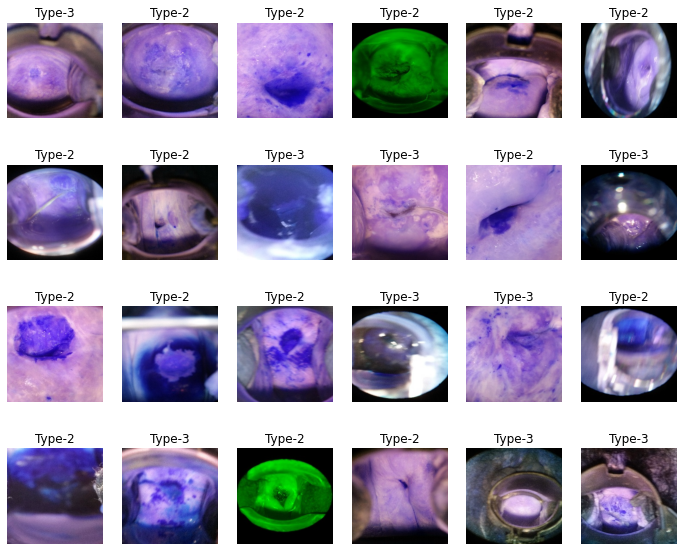

In [62]:
random_file_index = random.sample(range(len(images)), 24)
random_fig = plt.figure(figsize = (12, 10))
rows, cols = 4, 6
for i in range(24):
    random_fig.add_subplot(rows, cols, i+1)
    plt.imshow(cv2.imread(images[random_file_index[i]]))
    plt.title('Type-'+re.findall(r'.%s(\d+)' % '/Type_', images[random_file_index[i]])[0])
    plt.axis('off')
plt.show()

In [66]:
cervical_dataset_stat = {
    'train': [0, 0, 0],
    'validation': [0, 0, 0],
    'test': [0, 0, 0]
}

for index in train_dataset.__dict__['indices']:
    cervical_dataset_stat['train'][
        int(re.findall(r'.%s(\d+)' % '/Type_', images_over[index])[0])-1
    ] += 1
for index in validation_dataset.__dict__['indices']:
    cervical_dataset_stat['validation'][
        int(re.findall(r'.%s(\d+)' % '/Type_', images_over[index])[0])-1
    ] += 1
for index in test_dataset.__dict__['indices']:
    cervical_dataset_stat['test'][
        int(re.findall(r'.%s(\d+)' % '/Type_', images_over[index])[0])-1
    ] += 1

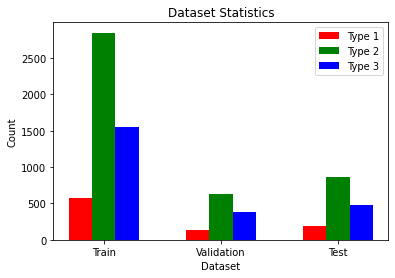

In [67]:
N = 3
ind = np.arange(N)
width = 0.2
colors = ['r', 'g', 'b']

bars = [
    plt.bar(
        ind + width*i,
        [cervical_dataset_stat['train'][i], cervical_dataset_stat['validation'][i], cervical_dataset_stat['test'][i]],
        width,
        color = colors[i],
        data = [1]
    ) for i in range(3)
]

plt.xlabel("Dataset")
plt.ylabel('Count')
plt.title("Dataset Statistics")

plt.xticks(ind+width,['Train', 'Validation', 'Test'])
plt.legend( ([*bars]), ('Type 1', 'Type 2', 'Type 3') )
plt.show()

In [68]:
Model = models.vgg16(pretrained=True)
Model.classifier[6] = nn.Linear(in_features=4096, out_features=3, bias=True)
Model = Model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(Model.parameters(),lr=lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 25, 50, 75, 120], gamma=0.5)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [69]:
# Model = models.efficientnet_b3(pretrained=True)
# Model.classifier = nn.Sequential(
#     nn.Dropout(p=0.3, inplace=True),
#     nn.Linear(in_features=1536, out_features=3, bias=True),
#     nn.Softmax(dim = 1)
# )
# Model = Model.to(device)

# loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(Model.parameters(),lr=lr, betas=(0.9,0.999))
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 10, 20, 40, 60, 70, 80, 90, 100], gamma=0.5)

In [70]:
def train_one_epoch(train_loader, model, criterion, optimizer, device):
    model.train()
    cervical_dataset.train_mode()
    
    size = len(train_loader.dataset)
    num_batches = len(train_loader)
    losses, correct = 0, 0
    ################################# train #################################
    for batch, (x, y) in enumerate(tqdm(train_loader)):
        device = torch.device(device)
        x, y = x.to(device), y.to(device)  
        optimizer.zero_grad()
        pred = model(x)
        loss = criterion(pred, y.long().squeeze())
#         loss = nn.functional.nll_loss(
#                 pred, y, weight=None, size_average=True
#         )
        current = batch * len(x)
        loss.backward()
        optimizer.step()
        y_pred, y_true = torch.argmax(pred, axis=1), y.long().squeeze()
        correct += (y_pred == y_true).type(torch.float).sum().item()
        losses += loss.item()
    correct /= size
    losses /= num_batches
    print(f"Train: Accuracy: {(100*correct):>0.2f}%, Avg loss: {losses:>5f}")
    return losses, correct

In [71]:
def valid_one_epoch(valid_loader, model, criterion, device):
    model.eval()
    cervical_dataset.test_mode()

    size = len(valid_loader.dataset)
    num_batches = len(valid_loader)
    losses, correct = 0, 0
    ################################# validation #################################
    with torch.no_grad():
        for batch, (x, y) in enumerate(tqdm(valid_loader)):
            device = torch.device(device)
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss = criterion(pred, y.long().squeeze())
#             loss = nn.functional.nll_loss(
#                 pred, y, weight=None, size_average=True
#             )
            current = batch * len(x)
            y_pred, y_true = torch.argmax(pred, axis=1), y.long().squeeze()
            correct += (y_pred == y_true).type(torch.float).sum().item()
            losses += loss.item()
    correct /= size
    losses /= num_batches
    print(f"Valid: Accuracy: {(100*correct):>0.2f}%, Avg loss: {losses:>5f} \n")
    return losses, correct

In [72]:
def train_valid(train_loader,valid_loader, model, criterion, optimizer, scheduler, device):
    liveloss = PlotLosses()
    
    tolerance = 0
    best_loss = np.inf
    best_epoch = 0
    best_acc = 0

    print('Starting Training...\n')
    for epoch in range(0, EPOCHS):
        logs = {}
        print(f"-------------------------------   Epoch {epoch + 1}   -------------------------------")

        train_loss, train_acc = train_one_epoch(train_loader, model, criterion, optimizer, device)
        valid_loss, valid_acc = valid_one_epoch(valid_loader, model, criterion, device)
        scheduler.step()
        
        # save validation loss if it was improved (reduced) & validation accuracy if it was improved (increased)
        if valid_loss < best_loss and valid_acc > best_acc:
            best_epoch = epoch + 1
            best_loss = valid_loss
            best_acc = valid_acc
            # save the model's weights and biases   
            torch.save(model.state_dict(), f"EffNetb3_ep{best_epoch}.pth")
        
        if valid_acc < best_acc:
            tolerance += 1
        
        logs['log loss'] = train_loss
        logs['accuracy'] = train_acc*100
        logs['val_log loss'] = valid_loss
        logs['val_accuracy'] = valid_acc*100
        
        liveloss.update(logs)
        liveloss.send()
    print("Done!")

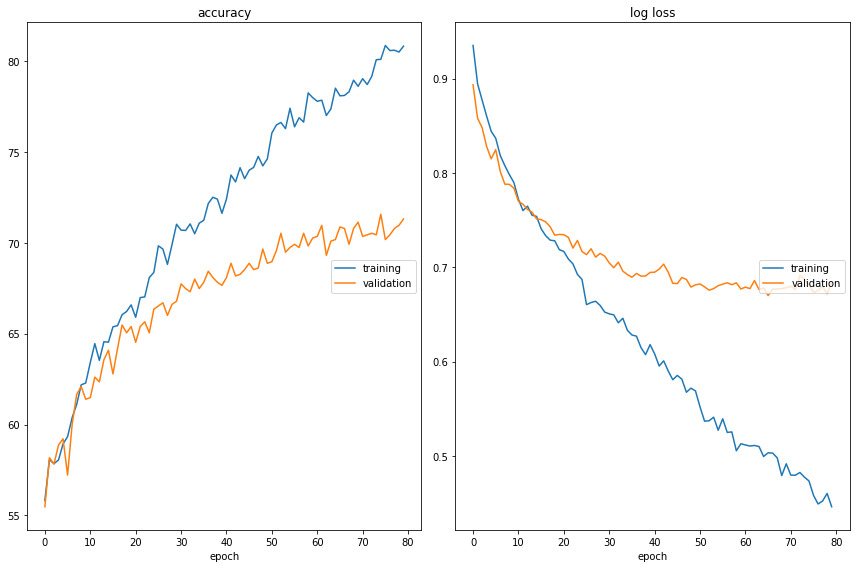

accuracy
	training         	 (min:   55.821, max:   80.851, cur:   80.811)
	validation       	 (min:   55.478, max:   71.565, cur:   71.304)
log loss
	training         	 (min:    0.446, max:    0.935, cur:    0.446)
	validation       	 (min:    0.670, max:    0.894, cur:    0.684)
-------------------------------   Epoch 81   -------------------------------


 24%|██▍       | 19/78 [00:13<00:41,  1.42it/s]

In [ ]:
train_valid(train_loader,validation_loader, Model, loss_fn, optimizer, scheduler, device)

In [ ]:
def test_model(test_loader, model, criterion, device):
    model.eval()
    cervical_dataset.test_mode()
    
    true_labels = []
    pred_labels = []
    scores = []

    size = len(test_loader.dataset)
    num_batches = len(test_loader)
    loss, correct = 0, 0
    ################################# validation #################################
    with torch.no_grad():
        for batch, (x, y) in enumerate(tqdm(test_loader)):
            device = torch.device(device)
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss = criterion(pred, y.long().squeeze()) 
            current = batch * len(x)
            scores += pred.tolist()
            y_pred, y_true = torch.argmax(pred, axis=1), y.long().squeeze()
            correct += (y_pred == y_true).type(torch.float).sum().item()
            loss, current = np.round(loss.item(), 5), batch * len(x)
            true_labels += y_true.detach().cpu().tolist()
            pred_labels += y_pred.detach().cpu().tolist()
    correct /= size
    loss /= num_batches
    print(f"Test: Accuracy: {(100*correct):>0.2f}%, Avg loss: {loss:>5f} \n")
    return np.array(true_labels), np.array(pred_labels), np.array(scores)

In [ ]:
true, pred, scores = test_model(test_loader, Model, loss_fn, device)

# Metrics

In [ ]:
cm  = confusion_matrix(true, pred)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8),cmap=plt.cm.Blues)
plt.xticks(range(3), ['Type 1', 'Type 2', 'Type 3'], fontsize=12)
plt.yticks(range(3), ['Type 1', 'Type 2', 'Type 3'], fontsize=12)
plt.xlabel('Predicted Label',fontsize=18)
plt.ylabel('True Label',fontsize=18)
plt.show()

In [ ]:
accuracy = (pred == true).sum() / len(pred)
precision, recall, f1, _ = precision_recall_fscore_support(true, pred, average='macro')

print("Accuracy of the model is {:.2f}".format(accuracy*100))
print("Recall(macro) of the model is {:.4f}".format(recall))
print("Precision(macro) of the model is {:.4f}".format(precision))
print("F1 Score(macro) of the model is {:.4f}".format(f1))
precision, recall, f1, _ = precision_recall_fscore_support(true, pred, average='micro')
print("Recall(micro) of the model is {:.4f}".format(recall))
print("Precision(micro) of the model is {:.4f}".format(precision))
print("F1 Score(micro) of the model is {:.4f}".format(f1))

In [ ]:
def counts_from_confusion(confusion):
    """
    Obtain TP, FN FP, and TN for each class in the confusion matrix
    """

    counts_list = []

    # Iterate through classes and store the counts
    for i in range(confusion.shape[0]):
        tp = confusion[i, i]

        fn_mask = np.zeros(confusion.shape)
        fn_mask[i, :] = 1
        fn_mask[i, i] = 0
        fn = np.sum(np.multiply(confusion, fn_mask))

        fp_mask = np.zeros(confusion.shape)
        fp_mask[:, i] = 1
        fp_mask[i, i] = 0
        fp = np.sum(np.multiply(confusion, fp_mask))

        tn_mask = 1 - (fn_mask + fp_mask)
        tn_mask[i, i] = 0
        tn = np.sum(np.multiply(confusion, tn_mask))

        counts_list.append({'Class': i,
                            'TP': tp,
                            'FN': fn,
                            'FP': fp,
                            'TN': tn})

    return counts_list
counts_from_confusion(cm)

In [ ]:
skplt.metrics.plot_roc(true, scores)
plt.show()

# Submissions - EXTRAS

In [ ]:
# %%capture
# !apt install -y p7zip-full
# !7z x ../input/intel-mobileodt-cervical-cancer-screening/test_stg2.7z -y -p"byecervicalcancer"

In [ ]:
test_files = os.listdir("../input/224-224-cervical-cancer-screening/kaggle/test/test/")
df_test =  pd.DataFrame(columns=["image_name","Type_1","Type_2","Type_3"])
print(f"Test files :  {len(test_files)}. ---> {test_files[:3]}")
test_files_sorted = [int(i[:-4]) for i in test_files]
test_files_sorted.sort()
with torch.no_grad():
    for p in tqdm(test_files_sorted):
        image = cv2.imread("../input/224-224-cervical-cancer-screening/kaggle/test/test/"+str(p)+'.jpg')
        image = test_transform(image).to(device)
        result = torch.nn.functional.softmax(Model(image.unsqueeze(0)), dim=1).to('cpu').numpy().reshape(-1)
        df_test = df_test.append(
            {
                "image_name": str(p)+'.jpg',
                "Type_1": result[0],
                "Type_2": result[1],
                "Type_3": result[2]
            }, ignore_index = True
        )

test_files = os.listdir("../input/224-224-cervical-cancer-screening/kaggle/test_stg2")
print(f"Test files :  {len(test_files)}. ---> {test_files[:3]}")
test_files_sorted = [int(i[:-4]) for i in test_files]
test_files_sorted.sort()
with torch.no_grad():
    for p in tqdm(test_files_sorted):
        image = cv2.imread("../input/224-224-cervical-cancer-screening/kaggle/test_stg2/"+str(p)+'.jpg')
        image = test_transform(image).to(device)
        result = torch.nn.functional.softmax(Model(image.unsqueeze(0)), dim=1).to('cpu').numpy().reshape(-1)
        df_test = df_test.append(
            {
                "image_name": str(p)+'.jpg',
                "Type_1": result[0],
                "Type_2": result[1],
                "Type_3": result[2]
            }, ignore_index = True
        )
df_test.head()


In [ ]:
df_test.to_csv('submission.csv', index = False)

In [ ]:
# Model = models.efficientnet_b3(pretrained=True)
# Model.classifier = nn.Sequential(
#     nn.Dropout(p=0.3, inplace=True),
#     nn.Linear(in_features=1536, out_features=3, bias=True),
#     nn.Softmax(dim = 1)
# )
# Model = Model.to(device)
# Model.load_state_dict(torch.load('./EffNetb3_ep5.pth'))

In [ ]:
while 1:
    pass

In [ ]:
df_test[:1]